In [1]:
#Librerias necesarias
import sys
import os
import re
import time
import datetime
import pandas as pd
import numpy as np
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scienceplots  # pip install scienceplots
from statsmodels.nonparametric.smoothers_lowess import lowess


In [2]:
#colores
color_list = [
    '#165995',  # Azul oscuro
    '#0ab049',  # Verde intenso
    '#fb950f',  # Naranja vivo
    '#d83a18',  # Rojo fuerte
    '#7b5e8b',  # Morado medio
    '#f72585',  # Rosa fucsia
    '#4cc9f0',  # Cian brillante
    '#f4d35e',  # Amarillo dorado
    '#ee964b',  # Naranja quemado
    '#a2d2ff',  # Azul pastel
    '#b5179e',  # Magenta intenso
    '#7209b7',  # Púrpura profundo
    '#3a0ca3',  # Azul violeta
    '#4361ee',  # Azul eléctrico
    '#ff595e',  # Rojo coral
    '#1982c4',  # Azul cielo
    '#6a4c93',  # Violeta oscuro
    '#ffca3a',  # Amarillo brillante
    '#8ac926',  # Verde lima
    '#ff6b6b'   # Rosa coral
]

In [3]:
# Inicializar consola
console = Console()

# Cargar datos
file_path = r"C:\Users\spinz\OneDrive\Documentos\Portafolio oficial\Segmentacion_de clientes\data\raw\Mall_Customers.csv"
df = pd.read_csv(file_path)

# Información antes de la limpieza
rows_before, cols_before = df.shape

# Proceso de limpieza:
# 1. Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# 2. Eliminar filas con NaN y filas completamente vacías
df_cleaned = df.dropna().copy()
df_cleaned = df_cleaned.loc[~(df_cleaned == "").all(axis=1)]

# Información después de la limpieza
rows_after, cols_after = df_cleaned.shape

# Tabla: Cantidad de datos antes y después
summary_table = Table(title="Resumen de Datos")
summary_table.add_column("Estado", justify="center", style="cyan")
summary_table.add_column("Filas", justify="center", style="magenta")
summary_table.add_column("Columnas", justify="center", style="magenta")

summary_table.add_row("Antes", str(rows_before), str(cols_before))
summary_table.add_row("Después", str(rows_after), str(cols_after))

console.print(summary_table)

# Tabla: Formato de cada columna (tipos de dato)
format_table = Table(title="Formato de Columnas (Tipos de Datos)")
format_table.add_column("Columna", justify="center", style="cyan")
format_table.add_column("Tipo de Dato", justify="center", style="magenta")

for col, dtype in df_cleaned.dtypes.items():
    format_table.add_row(col, str(dtype))

console.print(format_table)


       Resumen de Datos       
┏━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┓
┃ Estado  ┃ Filas ┃ Columnas ┃
┡━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━┩
│  Antes  │  200  │    5     │
│ Después │  200  │    5     │
└─────────┴───────┴──────────┘

  Formato de Columnas (Tipos de Datos)   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃        Columna         ┃ Tipo de Dato ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│       CustomerID       │    int64     │
│         Gender         │    object    │
│          Age           │    int64     │
│   Annual Income (k$)   │    int64     │
│ Spending Score (1-100) │    int64     │
└────────────────────────┴──────────────┘

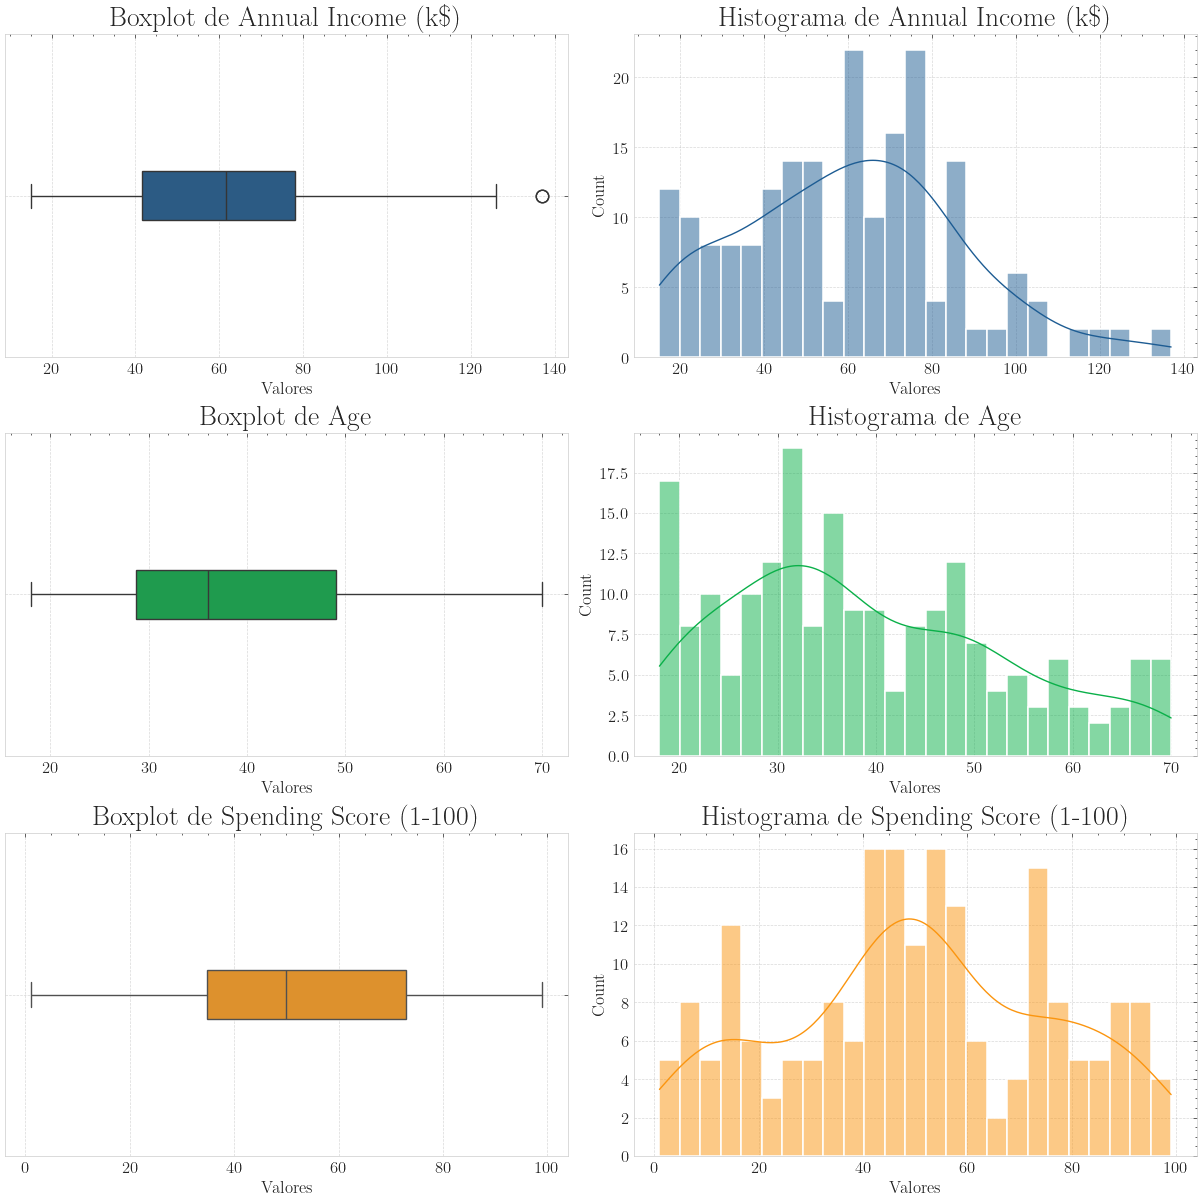

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar el estilo 'science' y ajustar parámetros de fuente para consistencia
plt.style.use('science')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

df = df_cleaned.copy()
df.columns = df.columns.str.strip()  # Elimina espacios y caracteres raros

# Seleccionar las columnas relevantes
cols = ["Annual Income (k$)", "Age", "Spending Score (1-100)"]
df_selected = df[cols]

# Definir los colores para cada variable (paleta científica)
colors = ['#1d5c93', '#0ab049', '#fb950f']

# Crear subplots: una fila por variable, dos columnas (boxplot horizontal y histograma)
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(12, 12), constrained_layout=True)

for i, col in enumerate(cols):
    custom_color = colors[i]
    
    # Escapar el símbolo $ en los títulos para evitar conflictos con LaTeX
    title_box = f"Boxplot de {col.replace('$', '\\$')}"
    title_hist = f"Histograma de {col.replace('$', '\\$')}"
    
    # Boxplot horizontal en la primera columna de la fila
    sns.boxplot(x=df_selected[col], ax=axes[i, 0], width=0.15, color=custom_color)
    axes[i, 0].set_title(title_box, fontsize=20, fontweight='bold')
    axes[i, 0].set_xlabel("Valores")
    # Agregar cuadrícula sutil para facilitar la lectura
    axes[i, 0].grid(True, linestyle='--', color='gray', alpha=0.3)
    
    # Histograma en la segunda columna de la fila con más barras (bins)
    sns.histplot(x=df_selected[col], ax=axes[i, 1], kde=True, bins=25, color=custom_color)
    axes[i, 1].set_title(title_hist, fontsize=20, fontweight='bold')
    axes[i, 1].set_xlabel("Valores")
    # Agregar cuadrícula sutil para facilitar la lectura
    axes[i, 1].grid(True, linestyle='--', color='gray', alpha=0.3)

plt.show()


In [118]:

# Seleccionamos las columnas
columns = ["Annual Income (k$)", "Age", "Spending Score (1-100)"]

# Creamos una copia del DataFrame antes de filtrar
df_before = df_cleaned.copy()

# Calculamos Q1, Q3 e IQR para las columnas seleccionadas
Q1 = df_before[columns].quantile(0.25)
Q3 = df_before[columns].quantile(0.75)
IQR = Q3 - Q1

# Contabilizamos los outliers por columna
outlier_counts = {}
for col in columns:
    outliers = df_before[(df_before[col] < (Q1[col] - 1.5 * IQR[col])) |
                         (df_before[col] > (Q3[col] + 1.5 * IQR[col]))]
    outlier_counts[col] = outliers.shape[0]

# Filtramos las filas que contienen al menos un outlier en las columnas indicadas
df_cleaned = df_before[~((df_before[columns] < (Q1 - 1.5 * IQR)) |
                           (df_before[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Número total de filas eliminadas
rows_removed = df_before.shape[0] - df_cleaned.shape[0]

# Creamos e imprimimos la tabla con rich
console = Console()
table = Table(title="Outliers Eliminados")

table.add_column("Columna", justify="left", style="cyan", no_wrap=True)
table.add_column("Cantidad de Outliers", justify="right", style="magenta")

for col, count in outlier_counts.items():
    table.add_row(col, str(count))

table.add_row("Total de filas eliminadas", str(rows_removed))

console.print(table)


                Outliers Eliminados                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Columna                   ┃ Cantidad de Outliers ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Annual Income (k$)        │                    2 │
│ Age                       │                    0 │
│ Spending Score (1-100)    │                    0 │
│ Total de filas eliminadas │                    2 │
└───────────────────────────┴──────────────────────┘

In [119]:
# Define los colores para cada dataframe
colors = ["#d83a18", "#7b5e8b"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), constrained_layout=True)

dataframes = [df, df_cleaned]
titles = ['Original DataFrame', 'Processed DataFrame']

for i, dataframe in enumerate(dataframes):
    # Boxplot con el color correspondiente
    sns.boxplot(x=dataframe["Annual Income (k$)"], ax=axes[i, 0], width=0.15, color=colors[i])
    axes[i, 0].set_title(f"Boxplot de Annual Income (k\\$) - {titles[i]}")
    axes[i, 0].set_xlabel("Valores")
    axes[i, 0].grid(False)
    
    # Histograma con el mismo color
    sns.histplot(x=dataframe["Annual Income (k$)"], ax=axes[i, 1], kde=True, bins=60, color=colors[i])
    axes[i, 1].set_title(f"Histograma de Annual Income (k\\$) - {titles[i]}")
    axes[i, 1].set_xlabel("Valores")
    axes[i, 1].grid(False)

plt.show()


ahora aplicamosla nomralizacion standar z-score
se transformo male en 0 y female en 1

In [120]:
# Primero, mapeamos los valores de la columna "Gender" a 0 y 1.
df_cleaned.loc[:, 'Gender'] = df_cleaned['Gender'].map({'Male': 0, 'Female': 1})
# Separamos las columnas numéricas (excluyendo "Gender")
cols_to_scale = df_cleaned.columns.difference(['Gender'])

# Inicializamos el escalador y ajustamos sólo las columnas numéricas
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_cleaned[cols_to_scale])

# Creamos un DataFrame con las columnas escaladas
df_scaled = pd.DataFrame(scaled_values, columns=cols_to_scale, index=df_cleaned.index)

# Concatenamos la columna "Gender" sin cambios con el DataFrame escalado
df_cleaned_standardized = pd.concat([df_scaled, df_cleaned['Gender']], axis=1)

# Opcional: para ordenar las columnas como en el DataFrame original
df_cleaned_standardized = df_cleaned_standardized[df_cleaned.columns]


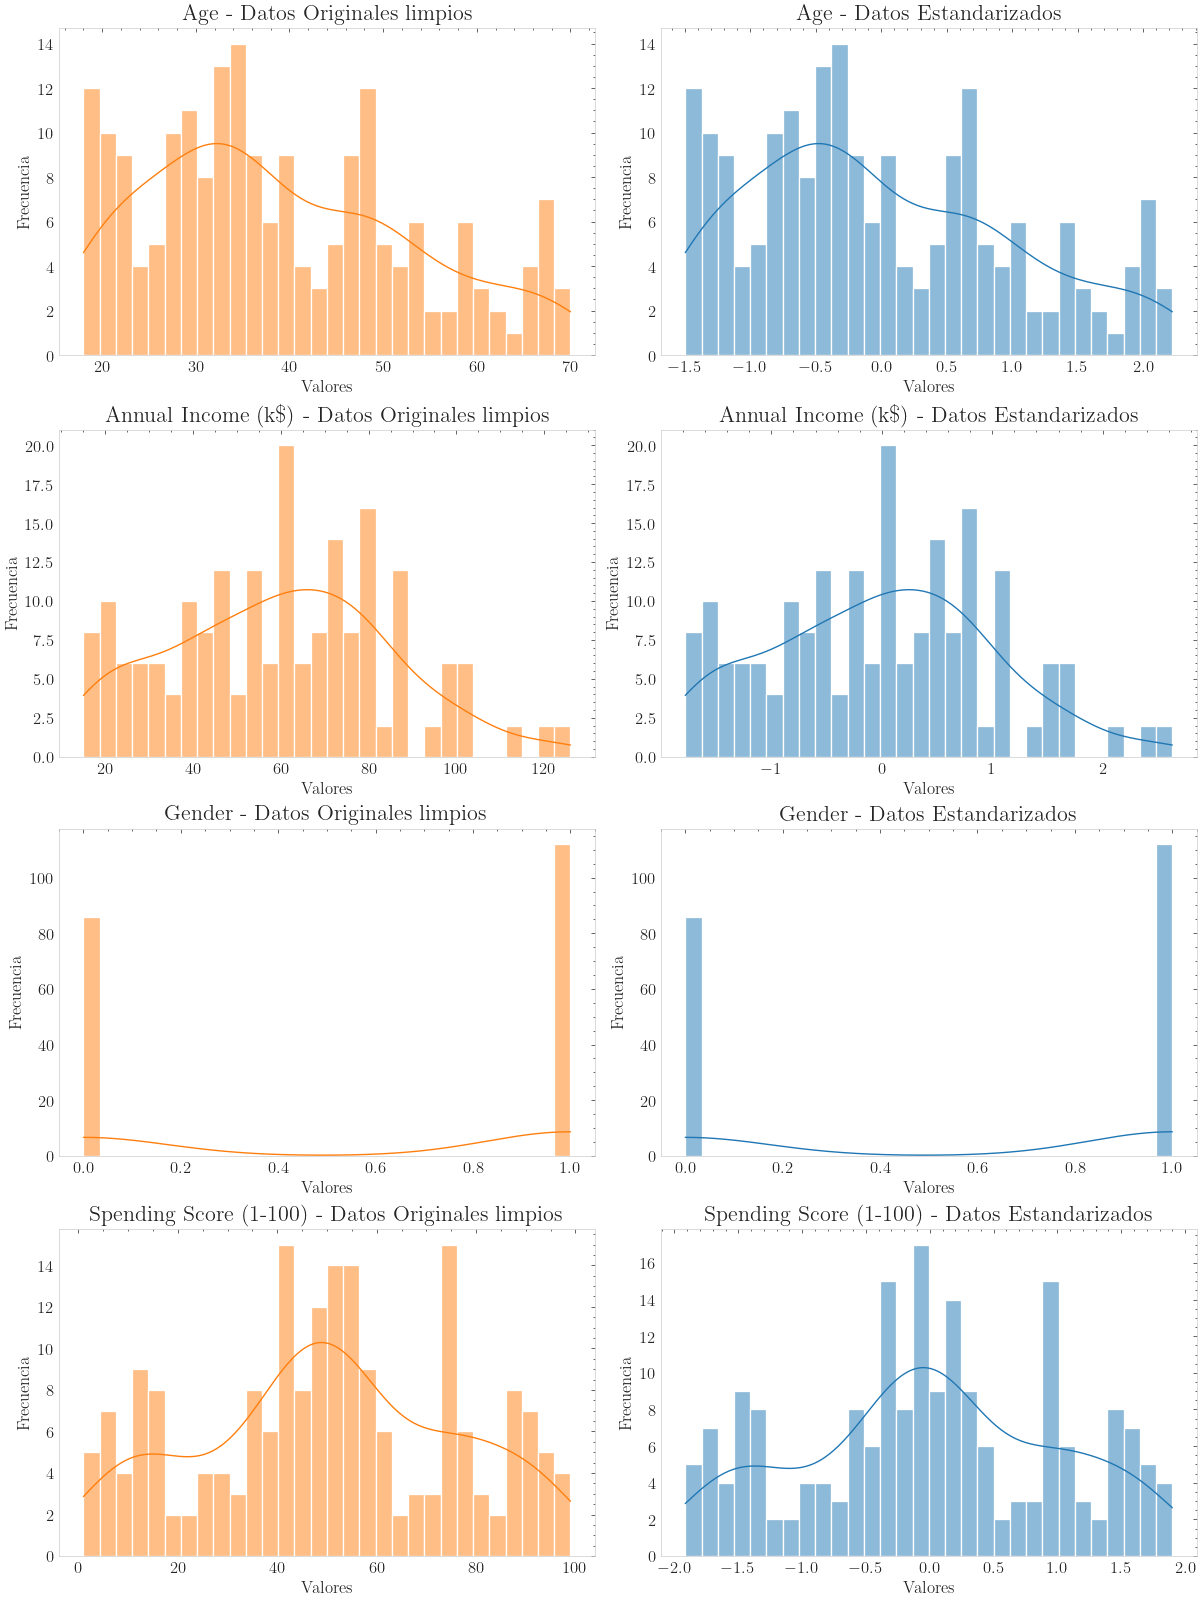

In [121]:
# Definir las columnas a comparar (excluyendo "CustomerID")
columns_to_compare = df_cleaned_standardized.columns.difference(['CustomerID'])

# Definir los colores para cada dataframe
colors = ["#1f77b4", "#ff7f0e"]

# Crear subplots: una fila por columna, dos columnas (un histograma por dataframe)
fig, axes = plt.subplots(nrows=len(columns_to_compare), ncols=2, figsize=(12, 4 * len(columns_to_compare)), constrained_layout=True)

for i, col in enumerate(columns_to_compare):
    # Para evitar problemas con el símbolo '$' en el título
    title_original = f"{col.replace('$', '\\$')} - Datos Originales limpios"
    title_standardized = f"{col.replace('$', '\\$')} - Datos Estandarizados"
    
    # Datos originales en la columna izquierda (índice 0)
    sns.histplot(df_cleaned[col], ax=axes[i, 0], kde=True, bins=30, color=colors[1])
    axes[i, 0].set_title(title_original)
    axes[i, 0].set_xlabel("Valores")
    axes[i, 0].set_ylabel("Frecuencia")
    axes[i, 0].grid(False)
    
    # Datos estandarizados en la columna derecha (índice 1)
    sns.histplot(df_cleaned_standardized[col], ax=axes[i, 1], kde=True, bins=30, color=colors[0])
    axes[i, 1].set_title(title_standardized)
    axes[i, 1].set_xlabel("Valores")
    axes[i, 1].set_ylabel("Frecuencia")
    axes[i, 1].grid(False)

plt.show()


hearmap para saber que no aya conealidad y saber si son correlacionados

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k)',
       'Spending Score (1-100)'],
      dtype='object')


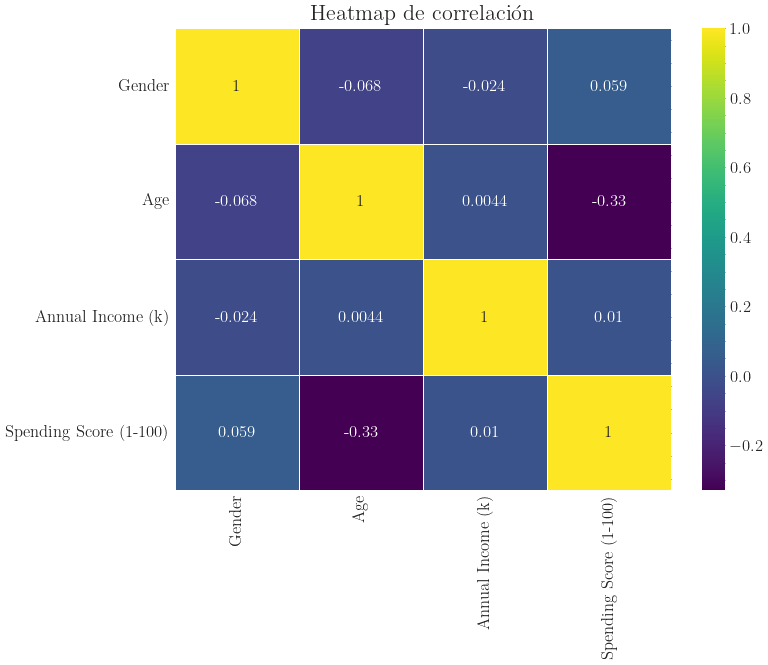

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Renombrar la columna para mayor claridad
df_cleaned_standardized.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

# Calcular la matriz de correlación para las columnas de interés
print(df_cleaned_standardized.columns)
cols = ['Gender', 'Age', 'Annual Income (k)', 'Spending Score (1-100)']
corr_matrix = df_cleaned_standardized[cols].corr()

# Configurar y mostrar el heatmap con el colormap "viridis"
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Heatmap de correlación')
plt.show()


In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Aplica el estilo de SciencePlots (asegúrate de tener instalada la librería scienceplots)
plt.style.use(['science', 'grid', 'no-latex'])

# Asegúrate de que df_cleaned está definido y agrupa los datos por Edad
df_grouped = df_cleaned.groupby("Age").agg(
    weighted_avg_spending=("Spending Score (1-100)", "mean")
).reset_index()

# Valores para el eje x e y
x = df_grouped["Age"]
y = df_grouped["weighted_avg_spending"]

# Cálculo de la regresión lineal
slope, intercept = np.polyfit(x, y, 1)
y_linear = slope * x + intercept

# Suavizado Lowess (ajusta el parámetro frac según convenga)
lowess_smoothed = lowess(y, x, frac=0.3)
x_lowess = lowess_smoothed[:, 0]
y_lowess = lowess_smoothed[:, 1]

# Cálculo del cambio porcentual entre puntos consecutivos en el suavizado Lowess
diff_pct = np.diff(y_lowess) / y_lowess[:-1] * 100

# Calculamos los puntos medios en x para colocar cada barra
x_midpoints = (x_lowess[:-1] + x_lowess[1:]) / 2

# Configuración de la figura y subgráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Gráfico de líneas: datos originales, regresión lineal y suavizado Lowess
ax1.plot(x, y, '-', color='black', linewidth=2, label="Datos Observados")
ax1.plot(x, y_linear, '--', color='#d62728', linewidth=1.5, label="Regresión Lineal")
ax1.plot(x_lowess, y_lowess, '-', color='#1f77b4', linewidth=2, label="Lowess")

ax1.set_xlabel("Edad", fontsize=14)
ax1.set_ylabel("Spending Score Promedio", fontsize=14)
ax1.set_title("Promedio Ponderado del Spending Score por Edad", fontsize=16)
ax1.legend(frameon=True, shadow=True, borderpad=1, fontsize=12)
ax1.grid(True)

# Para el histograma, definimos colores elegantes basados en el signo del cambio porcentual:
# Verde para incrementos y rojo para decrementos
colors = ['#2ca02c' if v >= 0 else '#d62728' for v in diff_pct]

# Histograma de cambio porcentual con barras estilizadas
ax2.bar(x_midpoints, diff_pct, width=0.5, color=colors, edgecolor='black', label="Cambio % (Lowess)")
ax2.set_xlabel("Edad", fontsize=14)
ax2.set_ylabel("Cambio %", fontsize=14)
ax2.set_title("Histograma de Cambio Porcentual entre Puntos Consecutivos (Lowess)", fontsize=16)
ax2.axhline(0, color='black', linewidth=1)
ax2.legend(frameon=True, shadow=True, borderpad=1, fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\566718357.py:60: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.



In [124]:

# Agrupamos los cambios porcentuales consecutivos en segmentos de tendencia
segments = []
current_trend = None
start_idx = 0

# diff_pct tiene longitud len(x_lowess)-1, ya que representa el cambio entre puntos consecutivos
for i, pct in enumerate(diff_pct):
    trend = "Alcista" if pct >= 0 else "Bajista"
    if current_trend is None:
        current_trend = trend
        start_idx = i
    elif trend != current_trend:
        # Se cierra el segmento actual: de x_lowess[start_idx] a x_lowess[i+1]
        segments.append((current_trend, start_idx, i))
        current_trend = trend
        start_idx = i
# Agregar el último segmento
if current_trend is not None:
    segments.append((current_trend, start_idx, len(diff_pct) - 1))

# Para cada segmento se determina el rango de edad y se calcula el promedio ponderado del spending score
results = []
for trend, start_diff, end_diff in segments:
    # El segmento cubre desde x_lowess[start_diff] hasta x_lowess[end_diff+1]
    age_start = x_lowess[start_diff]
    age_end = x_lowess[end_diff + 1]
    
    # Seleccionamos las filas de df_grouped que estén dentro del rango de edad
    mask = (df_grouped["Age"] >= age_start) & (df_grouped["Age"] <= age_end)
    avg_spending = df_grouped.loc[mask, "weighted_avg_spending"].mean()
    
    results.append((trend, f"{age_start:.1f} - {age_end:.1f}", avg_spending))

# Creamos la tabla con rich
console = Console()
table = Table(show_header=True, header_style="bold magenta")
table.add_column("Tendencia", style="cyan")
table.add_column("Rango de Edad")
table.add_column("Spending Score Promedio Ponderado", justify="right")

# Añadimos las filas a la tabla
for trend, age_range, avg_spending in results:
    table.add_row(trend, age_range, f"{avg_spending:.2f}")

console.print(table)


┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tendencia ┃ Rango de Edad ┃ Spending Score Promedio Ponderado ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Alcista   │ 18.0 - 29.0   │                             59.39 │
│ Bajista   │ 28.0 - 45.0   │                             50.74 │
│ Alcista   │ 44.0 - 53.0   │                             32.38 │
│ Bajista   │ 52.0 - 57.0   │                             33.79 │
│ Alcista   │ 56.0 - 70.0   │                             37.04 │
└───────────┴───────────────┴───────────────────────────────────┘

# Study global unisex

In [125]:
import plotly.express as px

fig = px.scatter_3d(
    df_cleaned_standardized, 
    x="Annual Income (k)", 
    y="Age", 
    z="Spending Score (1-100)",
    title="Gráfico de Dispersión 3D Interactivo",
    labels={
        "Annual Income (k)": "Ingreso Anual (k$)", 
        "Age": "Edad", 
        "Spending Score (1-100)": "Puntuación de Gasto"
    },
    template="plotly_white",  # Fondo claro similar al gráfico estático
    color="Spending Score (1-100)",  # Colorear según la misma variable
    color_continuous_scale="viridis"  # Usar la misma escala de colores "viridis"
)

# Configurar los marcadores: opacidad y bordes negros
fig.update_traces(marker=dict(
    opacity=0.8,
    line=dict(color='black', width=1)
))

# Ajustar tamaño, márgenes y vista de la cámara
fig.update_layout(
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40),
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1))
)

fig.show()


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos
sc = ax.scatter(
    df_cleaned_standardized["Annual Income (k)"],
    df_cleaned_standardized["Age"],
    df_cleaned_standardized["Spending Score (1-100)"],
    c=df_cleaned_standardized["Spending Score (1-100)"],
    cmap="viridis",  # Colormap perceptual
    alpha=0.8,  # Transparencia para mejor visibilidad
    edgecolors='k'  # Bordes negros para contraste
)

# Etiquetas y título
ax.set_xlabel("Ingreso Anual (k)")
ax.set_ylabel("Edad")
ax.set_zlabel("Spending Score")
ax.set_title("Grafico de dispersion \n(Dataframe Unisex)")

# Barra de color
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=15)
cbar.set_label("Puntuación de Gasto")

# Ajustar ángulo de vista
ax.view_init(elev=20, azim=135)

# Mostrar el gráfico
plt.show()


c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.



In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import os

os.environ["OMP_NUM_THREADS"] = "1"      # Fija el número de hilos para MKL
os.environ["LOKY_MAX_CPU_COUNT"] = "4"    # Limita el número de núcleos lógicos

# Extraemos únicamente las columnas de interés
df_cluster = df_cleaned_standardized[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Rango de clusters
k_values = range(2, 101)

# Listas para almacenar los índices
inertia = []
silhouette = []
dunn = []
calinski_harabasz = []
davies_bouldin = []

# Colores personalizados
color_list = [
    '#165995', '#0ab049', '#fb950f', '#d83a18', '#7b5e8b'
]

# Función para calcular el índice de Dunn
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    intra_dists = [np.max(cdist(X[labels == label], [centroids[i]])) for i, label in enumerate(unique_labels)]
    inter_dists = cdist(centroids, centroids)
    np.fill_diagonal(inter_dists, np.inf)  # Evitamos ceros en la diagonal
    return np.min(inter_dists) / np.max(intra_dists)

# Cálculo de los índices para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_cluster, labels))
    calinski_harabasz.append(calinski_harabasz_score(df_cluster, labels))
    davies_bouldin.append(davies_bouldin_score(df_cluster, labels))
    
    try:
        dunn.append(dunn_index(df_cluster.to_numpy(), labels))
    except Exception as e:
        dunn.append(np.nan)

# Graficamos los resultados con colores personalizados
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel()

metrics = [
    (inertia, "Método del Codo (Inercia)", "Inercia"),
    (silhouette, "Coeficiente de Silueta", "Silueta"),
    (dunn, "Índice de Dunn", "Dunn"),
    (calinski_harabasz, "Índice de Calinski-Harabasz", "Calinski-Harabasz"),
    (davies_bouldin, "Índice de Davies-Bouldin", "Davies-Bouldin")
]

for i, (data, title, ylabel) in enumerate(metrics):
    axes[i].plot(k_values, data, marker="o", color=color_list[i], linestyle="-")
    axes[i].set_title(title)
    axes[i].set_xlabel("Número de clusters (k)")
    axes[i].set_ylabel(ylabel)
    axes[i].grid(True)

# Elimina el último subgráfico vacío
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

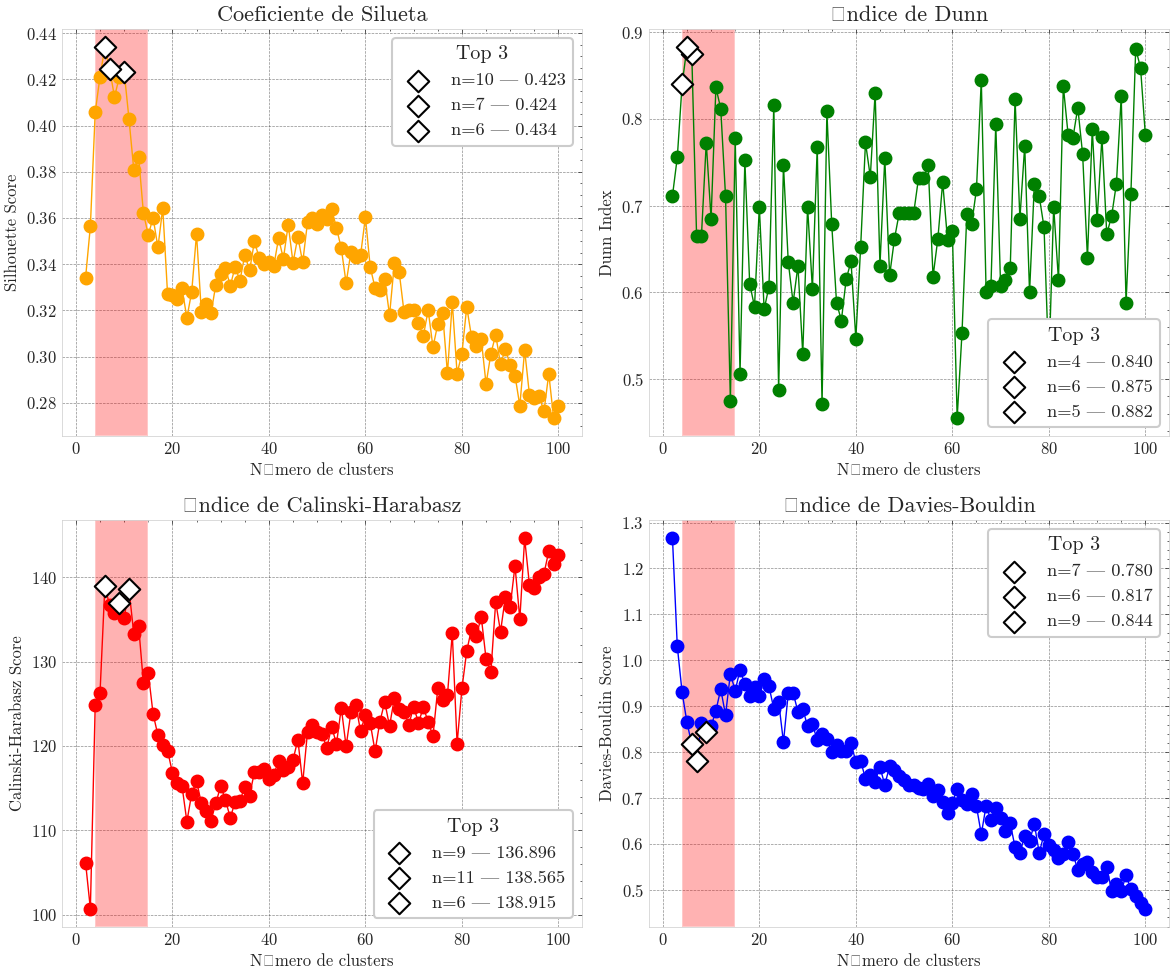

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import os

# Configuraciones para limitar el número de hilos
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Seleccionamos únicamente las columnas de interés
df_cluster = df_cleaned_standardized[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definimos el rango de clusters (k de 2 a 100)
k_values = np.array(list(range(2, 101)))

# Listas para almacenar las métricas que nos interesan
silhouette_values = []
dunn_values = []
calinski_values = []
davies_values = []  # Nueva métrica

# Función para calcular el índice de Dunn
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    intra_dists = [np.max(cdist(X[labels == label], [centroids[i]])) for i, label in enumerate(unique_labels)]
    inter_dists = cdist(centroids, centroids)
    np.fill_diagonal(inter_dists, np.inf)
    return np.min(inter_dists) / np.max(intra_dists)

# Cálculo de las métricas para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    
    silhouette_values.append(silhouette_score(df_cluster, labels))
    calinski_values.append(calinski_harabasz_score(df_cluster, labels))
    davies_values.append(davies_bouldin_score(df_cluster, labels))  # Nueva métrica
    try:
        dunn_values.append(dunn_index(df_cluster.to_numpy(), labels))
    except Exception:
        dunn_values.append(np.nan)

# Función para marcar los valores máximos y mínimos
def marcar_top(ax, x_vals, y_vals, n_points=3, minimo=False):
    mask = (x_vals >= 4) & (x_vals <= 15)
    x_area = x_vals[mask]
    y_area = np.array(y_vals)[mask]
    
    if len(y_area) >= n_points:
        top_indices = np.argsort(y_area)[:n_points] if minimo else np.argsort(y_area)[-n_points:]
    else:
        top_indices = np.argsort(y_area)
    
    handles = []
    labels_leg = []
    for idx in top_indices:
        x_pt = x_area[idx]
        y_pt = y_area[idx]
        sc = ax.scatter(x_pt, y_pt, s=120, marker='D', facecolors='white', edgecolors='black', zorder=5)
        handles.append(sc)
        labels_leg.append(f"n={x_pt} | {y_pt:.3f}")
    ax.legend(handles, labels_leg, title=f"Top {n_points}", loc="best")

# Graficamos las métricas en subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# 1. Coeficiente de Silueta
axs[0].plot(k_values, silhouette_values, marker='o', color='orange')
axs[0].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[0], k_values, silhouette_values, n_points=3)
axs[0].set_title("Coeficiente de Silueta")
axs[0].set_xlabel("Número de clusters")
axs[0].set_ylabel("Silhouette Score")

# 2. Índice de Dunn
axs[1].plot(k_values, dunn_values, marker='o', color='green')
axs[1].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[1], k_values, dunn_values, n_points=3)
axs[1].set_title("Índice de Dunn")
axs[1].set_xlabel("Número de clusters")
axs[1].set_ylabel("Dunn Index")

# 3. Índice de Calinski-Harabasz
axs[2].plot(k_values, calinski_values, marker='o', color='red')
axs[2].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[2], k_values, calinski_values, n_points=3)
axs[2].set_title("Índice de Calinski-Harabasz")
axs[2].set_xlabel("Número de clusters")
axs[2].set_ylabel("Calinski-Harabasz Score")

# 4. Índice de Davies-Bouldin (mínimos)
axs[3].plot(k_values, davies_values, marker='o', color='blue')
axs[3].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[3], k_values, davies_values, n_points=3, minimo=True)
axs[3].set_title("Índice de Davies-Bouldin")
axs[3].set_xlabel("Número de clusters")
axs[3].set_ylabel("Davies-Bouldin Score")

plt.tight_layout()
plt.show()


In [129]:
from rich.table import Table
from rich.console import Console
import numpy as np

console = Console()

# Creamos la tabla con las columnas deseadas
table = Table(title="Clusters óptimos por Métrica (rango [4,15])")
table.add_column("Métrica", style="bold")
table.add_column("Cluster óptimo 1", justify="center")
table.add_column("Cluster óptimo 2", justify="center")
table.add_column("Cluster óptimo 3", justify="center")

n_points = 3  # Número de clusters destacados a mostrar
mask = (k_values >= 4) & (k_values <= 15)
k_area = k_values[mask]

def obtener_clusters_optimos(metric_values, minimo=False):
    metric_area = np.array(metric_values)[mask]
    # Para métricas a maximizar, seleccionamos los índices con valores mayores;
    # para métricas a minimizar (como Davies-Bouldin) seleccionamos los índices con valores menores.
    if minimo:
        top_indices = np.argsort(metric_area)[:n_points]
    else:
        top_indices = np.argsort(metric_area)[-n_points:]
    # Ordenamos los clusters para que se muestren en forma creciente
    return np.sort(k_area[top_indices])

# Obtenemos los clusters óptimos para cada métrica
clusters_silhouette = obtener_clusters_optimos(silhouette_values, minimo=False)
clusters_dunn = obtener_clusters_optimos(dunn_values, minimo=False)
clusters_calinski = obtener_clusters_optimos(calinski_values, minimo=False)
clusters_davies = obtener_clusters_optimos(davies_values, minimo=True)

# Agregamos las filas a la tabla
table.add_row("Coeficiente de Silueta",
              str(clusters_silhouette[0]),
              str(clusters_silhouette[1]),
              str(clusters_silhouette[2]))
table.add_row("Índice de Dunn",
              str(clusters_dunn[0]),
              str(clusters_dunn[1]),
              str(clusters_dunn[2]))
table.add_row("Calinski-Harabasz",
              str(clusters_calinski[0]),
              str(clusters_calinski[1]),
              str(clusters_calinski[2]))
table.add_row("Davies-Bouldin",
              str(clusters_davies[0]),
              str(clusters_davies[1]),
              str(clusters_davies[2]))

console.print(table)

# Calculamos la intersección de los clusters obtenidos en cada métrica
clusters_comunes = set(clusters_silhouette) & set(clusters_dunn) & set(clusters_calinski) & set(clusters_davies)

# Convertimos el conjunto a una lista ordenada (si no está vacío)
clusters_comunes = sorted(list(clusters_comunes))

# Creamos una nueva tabla para mostrar los clusters comunes
table_comunes = Table(title="Cluster(s) que aparecen en todas las métricas")
table_comunes.add_column("Cluster Común", justify="center", style="bold cyan")

# Si se encontró al menos un cluster común, lo agregamos a la tabla
if clusters_comunes:
    for cluster in clusters_comunes:
        table_comunes.add_row(str(cluster))
else:
    table_comunes.add_row("No hay clusters comunes")

console.print(table_comunes)



                    Clusters óptimos por Métrica (rango [4,15])                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Métrica                ┃ Cluster óptimo 1 ┃ Cluster óptimo 2 ┃ Cluster óptimo 3 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Coeficiente de Silueta │        6         │        7         │        10        │
│ Índice de Dunn         │        4         │        5         │        6         │
│ Calinski-Harabasz      │        6         │        9         │        11        │
│ Davies-Bouldin         │        6         │        7         │        9         │
└────────────────────────┴──────────────────┴──────────────────┴──────────────────┘

 Cluster(s) que  
aparecen en todas
  las métricas   
┏━━━━━━━━━━━━━━━┓
┃ Cluster Común ┃
┡━━━━━━━━━━━━━━━┩
│       6       │
└───────────────┘

por lo que vemos el numero de cluster optimo es 6 ahora procederemos a utilizar y graficar los k-mens con esto

In [130]:
from sklearn.cluster import KMeans

# Seleccionar las columnas de interés
features = df_cleaned_standardized[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definir el modelo K-means con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Entrenar el modelo
kmeans.fit(features)

# Asignar la etiqueta de cluster a cada observación (opcional)
df_cleaned_standardized['Cluster'] = kmeans.labels_


c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



ahora graficamos el dataframe ya clasificado.

In [131]:
import plotly.graph_objects as go
import plotly.express as px

# Obtener clusters únicos
clusters = sorted(df_cleaned_standardized['Cluster'].unique())

# Usar la paleta de colores "Set1" para mayor contraste
contrast_colors = px.colors.qualitative.Set1

# Crear figura
fig = go.Figure()

# Agregar una traza para cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized[df_cleaned_standardized['Cluster'] == cluster]
    color = contrast_colors[i % len(contrast_colors)]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data["Annual Income (k)"],
        y=cluster_data["Age"],
        z=cluster_data["Spending Score (1-100)"],
        mode='markers',
        marker=dict(
            size=5,
            color=color,
            opacity=0.8,
            line=dict(color='black', width=1)  # Borde negro similar al 'edgecolor' en matplotlib
        ),
        name=f'Cluster {cluster}'
    ))

# Configurar layout con estilo profesional y científico
fig.update_layout(
    title='Clusters en 3D',
    scene=dict(
        xaxis=dict(title='Ingreso Anual (k)', titlefont=dict(size=12)),
        yaxis=dict(title='Edad', titlefont=dict(size=12)),
        zaxis=dict(title='Puntuación de Gasto (1-100)', titlefont=dict(size=12)),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1))
    ),
    legend=dict(
        title=dict(text='Cluster', font=dict(size=12)),
        font=dict(size=10)
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


este grafico es el que se va a anexar en el informe

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\824421834.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.



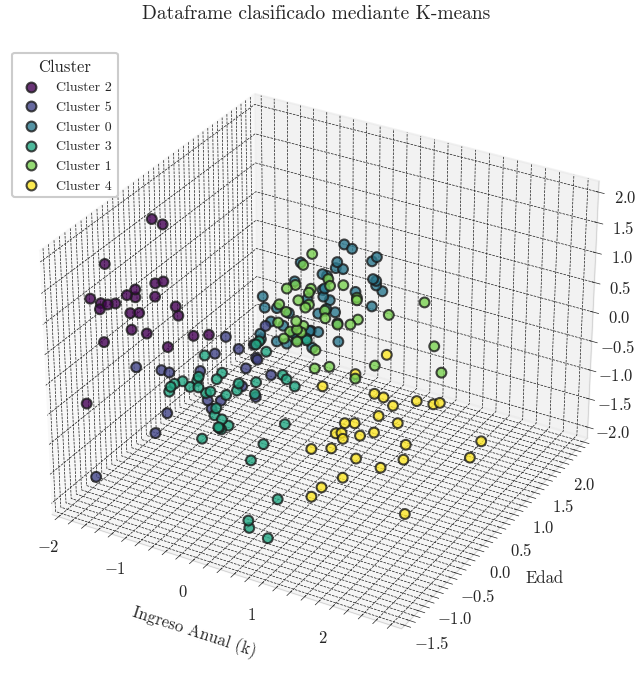

In [132]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Crear figura y eje 3D
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Obtener clusters únicos y definir un mapa de colores profesional
clusters = df_cleaned_standardized['Cluster'].unique()
colors = plt.cm.get_cmap('viridis', len(clusters))  # Mapa de colores 'viridis' es elegante y profesional

# Graficar cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized[df_cleaned_standardized['Cluster'] == cluster]
    ax.scatter(
        cluster_data["Annual Income (k)"],
        cluster_data["Age"],
        cluster_data["Spending Score (1-100)"],
        s=50,
        alpha=0.8,
        edgecolor='k',
        color=colors(i),
        label=f'Cluster {cluster}'
    )

# Configurar etiquetas y título con estilo científico
ax.set_xlabel('Ingreso Anual (k)', fontsize=12, labelpad=10)
ax.set_ylabel('Edad', fontsize=12, labelpad=10)
ax.set_zlabel('Puntuación de Gasto (1-100)', fontsize=12, labelpad=10)
ax.set_title('Dataframe clasificado mediante K-means', fontsize=14, pad=20)

# Configurar leyenda con estilo
ax.legend(title='Cluster', title_fontsize=12, fontsize=10, loc='upper left')

# Mejorar el layout para una presentación más limpia
plt.tight_layout()

plt.show()


In [133]:
# Copiar el DataFrame original para no modificarlo
df_cleaned_cluster_3D_unisex = df_cleaned.copy()

# Agregar la columna de cluster
df_cleaned_cluster_3D_unisex['Cluster'] = df_cleaned_standardized['Cluster']

In [134]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_unisex = df_cleaned_cluster_3D_unisex.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_unisex.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_unisex.groupby('Cluster').agg(lambda x: skew(x, bias=False, nan_policy='omit'))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la tabla con rich
console = Console()
table = Table(title="Estadísticas por Cluster Unisex")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla en la consola
console.print(table)


                                          Estadísticas por Cluster Unisex                                          
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃   (k$) ┃   (k$) ┃   (k$) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃  (k$) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  56.34 │   8.55 │  54.00 │  53.70 │   8.24 │  54.00 │ 49.39 │   5.99 │ 49.00 │   0.27 │ -0.06 │  -0.02 │
│   1    │  32.76 │   3.75 │  32.00 │  85.21 │  14.24 │  78.50 │ 82.11 │   9.49 │ 84.00 │   0.38 │  1.23 │  -0.10 │
│   2    │  25.56 │   5.44 │  24.00 │  26.48 │   8.53 │  25.00 │ 76.24 │  13.56 │ 76.00 │   0.56 │  0.30 │  -0.52 │
│   3    │  26.12 │   7.03 │  25.00 │  59.42 │  10.59 │  60.00 │ 44.45 │  14.28 │ 48.00 │   0.71 │ -0.12 │  -1.65 │
│   4    │  44.80 │   8.04 │  44.00 │  88.20 │  14.52 │  86.50 │ 18.50 │  10.37 │ 16.50 │   0.33 │  1.00 │   0.31 │
│   5    │  45.52 │  11.77 │  46.00 │  26.29 │   7.44 │  25.00 │ 19.38 │  12.56 │ 15.00 │  -0.08 │  0.34 │   0.17 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

In [135]:
#Cambiamos el nombre de una columna que contiene un símbolo especial 
df_cleaned_cluster_3D_unisex.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

Estadísticos Originales (Cluster 1 - Annual Income (k)):
Min: 69, Max: 126
Media: 85.211, Mediana: 78.500, Desviación estándar: 14.236
Skewness: 1.229

Estadísticos Winsorizados (Cluster 1 - Annual Income (k)):
Min: 69, Max: 103
Media: 83.895, Mediana: 78.500, Desviación estándar: 11.313
Skewness: 0.561


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

c:

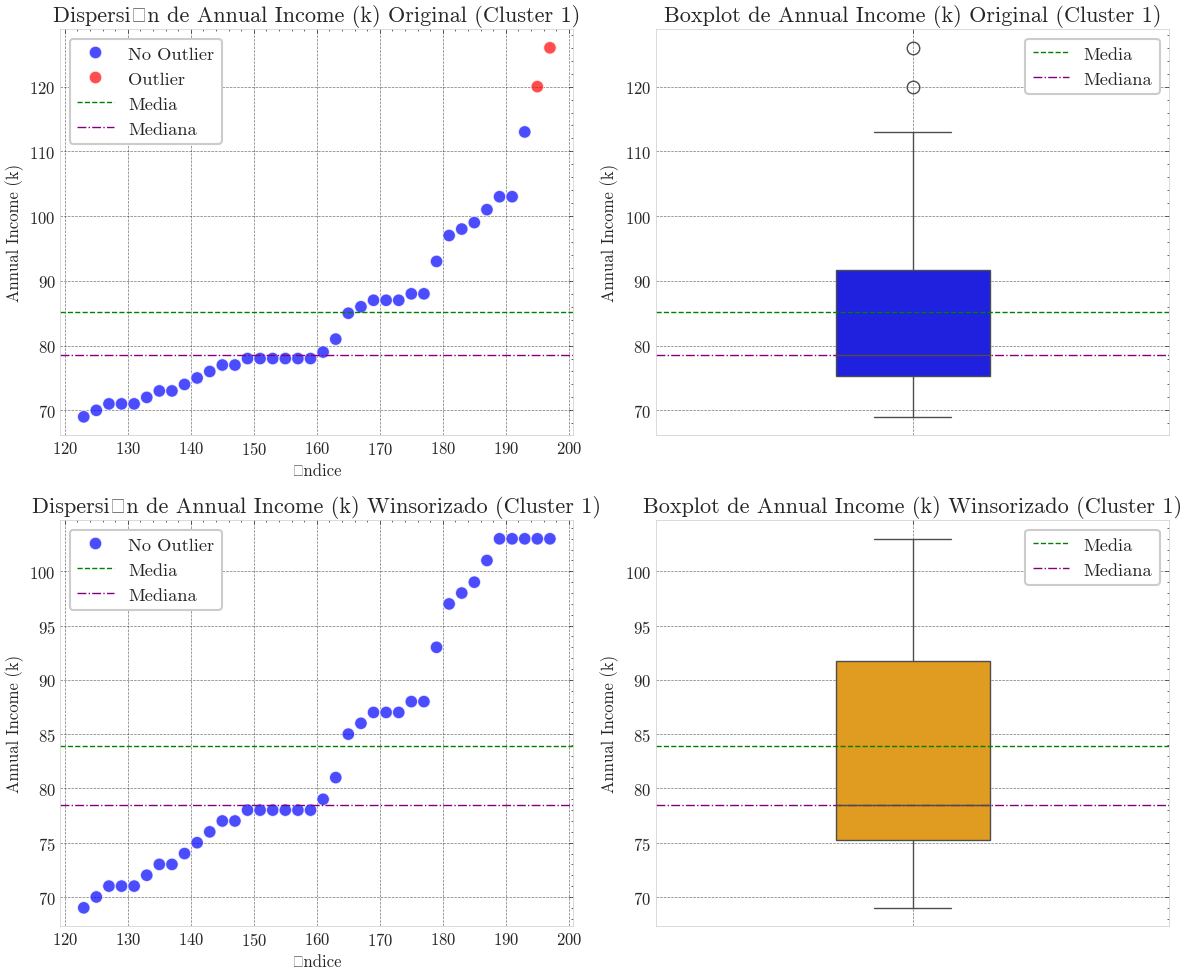

Estadísticos Originales (Cluster 3 - Spending Score (1-100)):
Min: 5, Max: 60
Media: 44.450, Mediana: 48.000, Desviación estándar: 14.279
Skewness: -1.652

Estadísticos Winsorizados (Cluster 3 - Spending Score (1-100)):
Min: 29, Max: 60
Media: 46.550, Mediana: 48.000, Desviación estándar: 9.307
Skewness: -0.560


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

c:

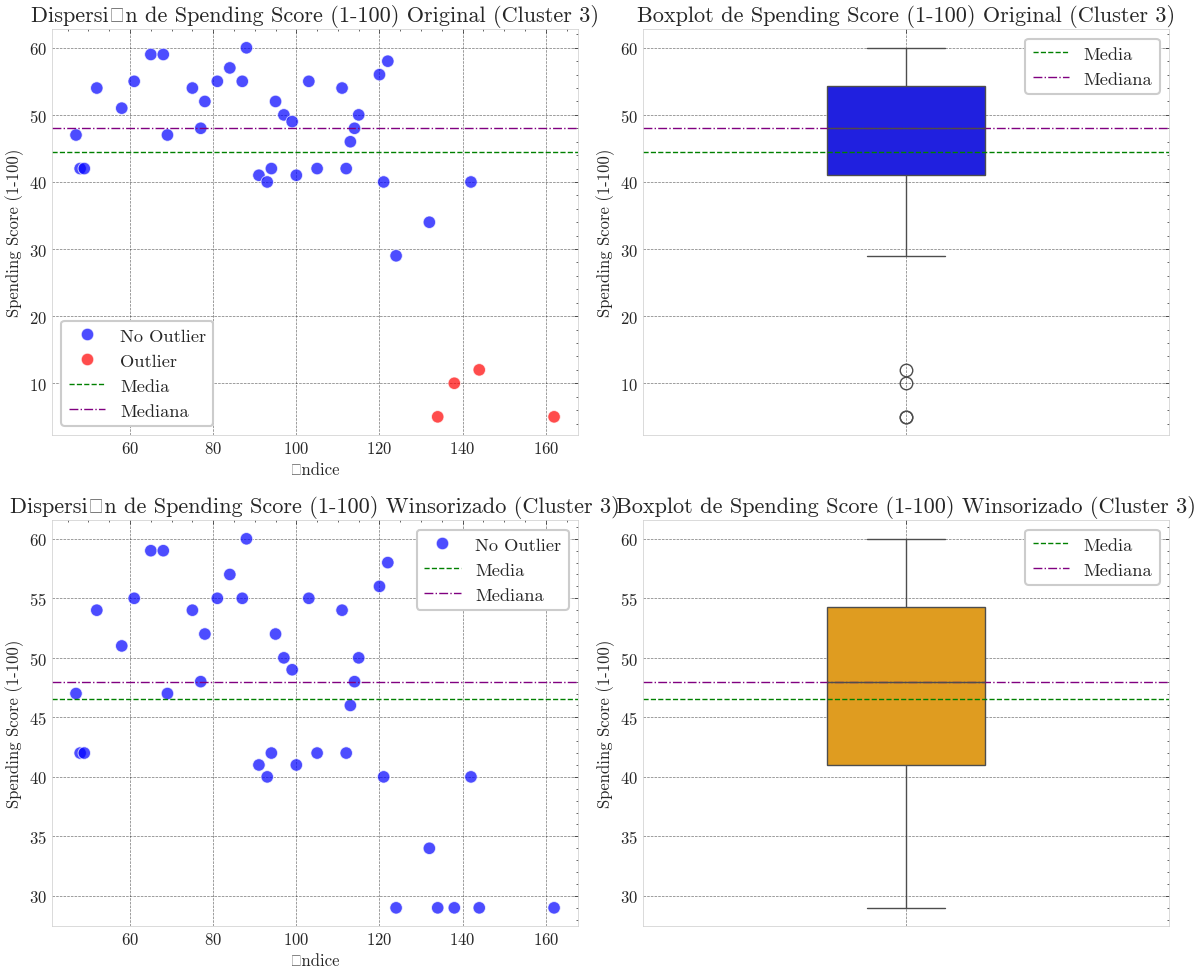

Estadísticos Originales (Cluster 3 - Age):
Min: 18, Max: 40
Media: 26.125, Mediana: 25.000, Desviación estándar: 7.032
Skewness: 0.710

Estadísticos Winsorizados (Cluster 3 - Age):
Min: 18, Max: 32
Media: 25.025, Mediana: 25.000, Desviación estándar: 5.211
Skewness: 0.113


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

c:

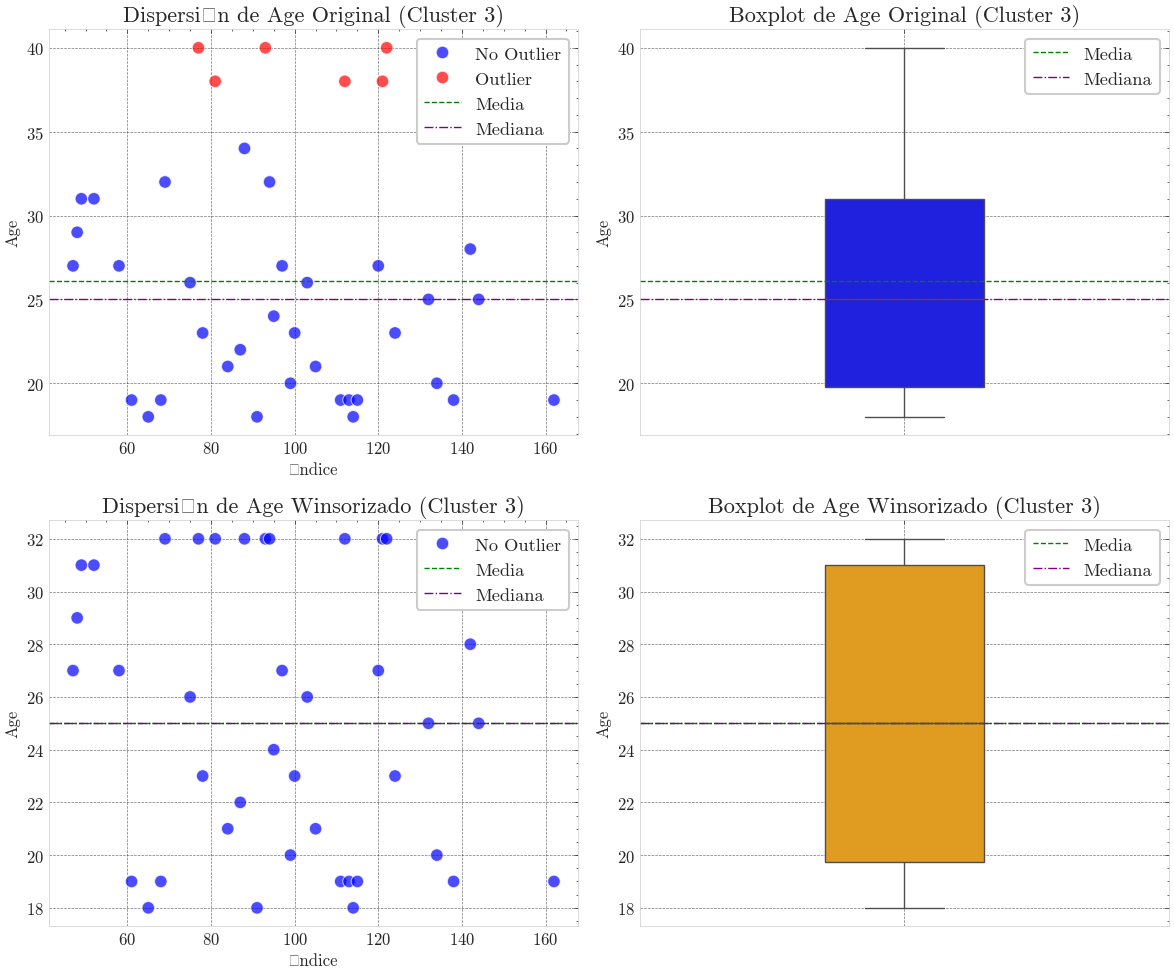

Estadísticos Originales (Cluster 4 - Annual Income (k)):
Min: 71, Max: 126
Media: 88.200, Mediana: 86.500, Desviación estándar: 14.523
Skewness: 1.005

Estadísticos Winsorizados (Cluster 4 - Annual Income (k)):
Min: 71, Max: 103
Media: 86.533, Mediana: 86.500, Desviación estándar: 11.196
Skewness: 0.262


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:146: UserWarning:

Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.

c:\Users\spinz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 205 (\N{LATIN CAPITAL LETTER I WITH ACUTE}) missing from font(s) cmr10.

c:

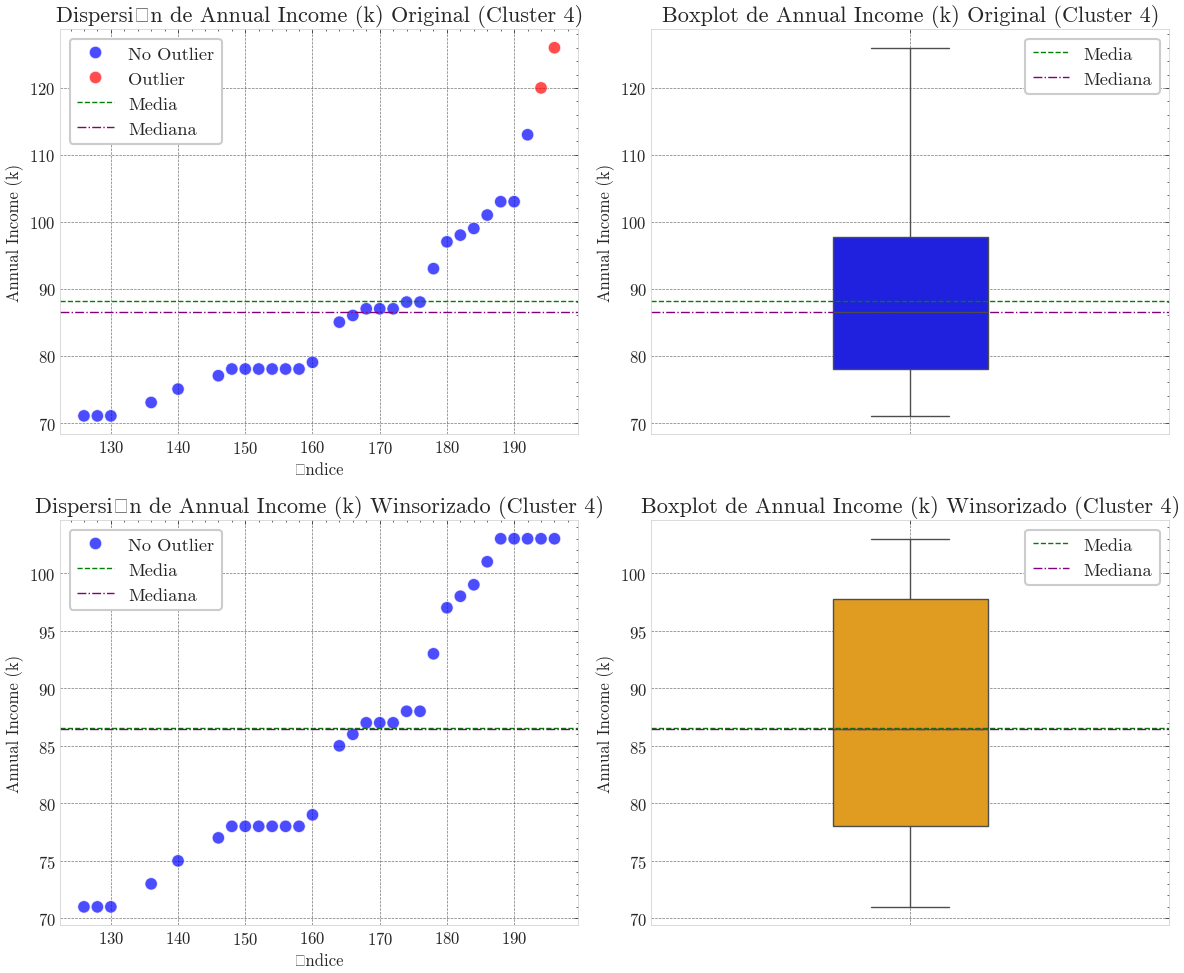

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
from scipy.stats.mstats import winsorize

def procesar_cluster(dataframe, cluster_valor, columna, win_limits, iqr_factor=1, titulo_extra=""):
    """
    Procesa los datos de un cluster aplicando winsorización, calculando estadísticas,
    detectando outliers y generando gráficos.

    Parámetros:
    - dataframe: DataFrame original.
    - cluster_valor: Valor del cluster a filtrar.
    - columna: Nombre de la columna a procesar.
    - win_limits: Lista con los límites para la winsorización (ej: [0.2, 0.2]).
    - iqr_factor: Factor para detectar outliers (por defecto 1; en algunos casos puede ser 0.5).
    - titulo_extra: Texto adicional para personalizar títulos de gráficos.
    """
    # Filtrar el DataFrame para obtener solo las filas del cluster
    df_original = dataframe[dataframe["Cluster"] == cluster_valor].copy()
    
    # Guardar una copia de la columna original
    datos_originales = df_original[columna].copy()
    
    # Aplicar winsorización a la columna
    datos_winsorizados = winsorize(datos_originales, limits=win_limits)
    
    # Reemplazar los valores de la columna en el dataframe original para el cluster
    dataframe.loc[dataframe["Cluster"] == cluster_valor, columna] = datos_winsorizados
    
    # Actualizar el DataFrame winsorizado para el cluster
    df_winsorizado = dataframe[dataframe["Cluster"] == cluster_valor].copy()
    
    # Calcular estadísticas para el conjunto original
    media_orig = np.mean(datos_originales)
    mediana_orig = np.median(datos_originales)
    std_orig = np.std(datos_originales, ddof=1)
    skew_orig = skew(datos_originales, bias=False)
    
    # Calcular estadísticas para el conjunto winsorizado
    media_win = np.mean(df_winsorizado[columna])
    mediana_win = np.median(df_winsorizado[columna])
    std_win = np.std(df_winsorizado[columna], ddof=1)
    skew_win = skew(df_winsorizado[columna], bias=False)
    
    # Imprimir estadísticas para comparar
    print(f"Estadísticos Originales (Cluster {cluster_valor} - {columna}):")
    print(f"Min: {datos_originales.min()}, Max: {datos_originales.max()}")
    print(f"Media: {media_orig:.3f}, Mediana: {mediana_orig:.3f}, Desviación estándar: {std_orig:.3f}")
    print(f"Skewness: {skew_orig:.3f}\n")
    
    print(f"Estadísticos Winsorizados (Cluster {cluster_valor} - {columna}):")
    print(f"Min: {df_winsorizado[columna].min()}, Max: {df_winsorizado[columna].max()}")
    print(f"Media: {media_win:.3f}, Mediana: {mediana_win:.3f}, Desviación estándar: {std_win:.3f}")
    print(f"Skewness: {skew_win:.3f}")
    
    # Detectar outliers usando el método IQR en ambos conjuntos
    Q1_orig = datos_originales.quantile(0.25)
    Q3_orig = datos_originales.quantile(0.75)
    IQR_orig = Q3_orig - Q1_orig
    lower_bound_orig = Q1_orig - iqr_factor * IQR_orig
    upper_bound_orig = Q3_orig + iqr_factor * IQR_orig
    
    df_original["outlier_status"] = np.where(
        (datos_originales < lower_bound_orig) | (datos_originales > upper_bound_orig),
        "Outlier",
        "No Outlier"
    )
    
    Q1_win = df_winsorizado[columna].quantile(0.25)
    Q3_win = df_winsorizado[columna].quantile(0.75)
    IQR_win = Q3_win - Q1_win
    lower_bound_win = Q1_win - iqr_factor * IQR_win
    upper_bound_win = Q3_win + iqr_factor * IQR_win
    
    df_winsorizado["outlier_status"] = np.where(
        (df_winsorizado[columna] < lower_bound_win) | (df_winsorizado[columna] > upper_bound_win),
        "Outlier",
        "No Outlier"
    )
    
    # Crear figura con 2 filas y 2 columnas para visualizar ambas distribuciones
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Gráficos para los datos originales
    sns.scatterplot(
        ax=axes[0, 0],
        x=df_original.index,
        y=df_original[columna],
        hue=df_original["outlier_status"],
        palette={"Outlier": "red", "No Outlier": "blue"},
        alpha=0.7
    )
    axes[0, 0].axhline(media_orig, color='green', linestyle='--', label='Media')
    axes[0, 0].axhline(mediana_orig, color='purple', linestyle='-.', label='Mediana')
    axes[0, 0].set_title(f"Dispersión de {columna} Original {titulo_extra}")
    axes[0, 0].set_xlabel("Índice")
    axes[0, 0].set_ylabel(columna)
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.6)
    
    sns.boxplot(
        ax=axes[0, 1],
        y=df_original[columna],
        width=0.3,
        palette=["blue"]
    )
    axes[0, 1].axhline(media_orig, color='green', linestyle='--', label='Media')
    axes[0, 1].axhline(mediana_orig, color='purple', linestyle='-.', label='Mediana')
    axes[0, 1].set_title(f"Boxplot de {columna} Original {titulo_extra}")
    axes[0, 1].set_ylabel(columna)
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle="--", alpha=0.6)
    
    # Gráficos para los datos winsorizados
    sns.scatterplot(
        ax=axes[1, 0],
        x=df_winsorizado.index,
        y=df_winsorizado[columna],
        hue=df_winsorizado["outlier_status"],
        palette={"Outlier": "red", "No Outlier": "blue"},
        alpha=0.7
    )
    axes[1, 0].axhline(media_win, color='green', linestyle='--', label='Media')
    axes[1, 0].axhline(mediana_win, color='purple', linestyle='-.', label='Mediana')
    axes[1, 0].set_title(f"Dispersión de {columna} Winsorizado {titulo_extra}")
    axes[1, 0].set_xlabel("Índice")
    axes[1, 0].set_ylabel(columna)
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle="--", alpha=0.6)
    
    sns.boxplot(
        ax=axes[1, 1],
        y=df_winsorizado[columna],
        width=0.3,
        palette=["orange"]
    )
    axes[1, 1].axhline(media_win, color='green', linestyle='--', label='Media')
    axes[1, 1].axhline(mediana_win, color='purple', linestyle='-.', label='Mediana')
    axes[1, 1].set_title(f"Boxplot de {columna} Winsorizado {titulo_extra}")
    axes[1, 1].set_ylabel(columna)
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.6)
    
    plt.tight_layout()
    plt.show()

#Cluster 1 columna Annual Income (k)
procesar_cluster(df_cleaned_cluster_3D_unisex, cluster_valor=1, columna="Annual Income (k)", win_limits=[0, 0.1], iqr_factor=1.5, titulo_extra="(Cluster 1)")

#Cluster 3 columna Spending Score
procesar_cluster(df_cleaned_cluster_3D_unisex, cluster_valor=3, columna="Spending Score (1-100)", win_limits=[0.1, 0], iqr_factor=1.5, titulo_extra="(Cluster 3)")
#Cluster 3 columna Age
procesar_cluster(df_cleaned_cluster_3D_unisex, cluster_valor=3, columna="Age", win_limits=[0, 0.2], iqr_factor=0.5, titulo_extra="(Cluster 3)")

#Cluster 4 columna Spending Score
procesar_cluster(df_cleaned_cluster_3D_unisex, cluster_valor=4, columna="Annual Income (k)", win_limits=[0, 0.1], iqr_factor=1, titulo_extra="(Cluster 4)")

Volvemos a calcular las estadisticas para ver las nuevas condicionales de los clusters

In [137]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_unisex = df_cleaned_cluster_3D_unisex.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_unisex.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_unisex.groupby('Cluster').agg(lambda x: skew(x, bias=False, nan_policy='omit'))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la tabla con rich
console = Console()
table = Table(title="Estadísticas por Cluster Unisex")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla en la consola
console.print(table)


                                          Estadísticas por Cluster Unisex                                          
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃    (k) ┃    (k) ┃    (k) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃   (k) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  56.34 │   8.55 │  54.00 │  53.70 │   8.24 │  54.00 │ 49.39 │   5.99 │ 49.00 │   0.27 │ -0.06 │  -0.02 │
│   1    │  32.76 │   3.75 │  32.00 │  83.89 │  11.31 │  78.50 │ 82.11 │   9.49 │ 84.00 │   0.38 │  0.56 │  -0.10 │
│   2    │  25.56 │   5.44 │  24.00 │  26.48 │   8.53 │  25.00 │ 76.24 │  13.56 │ 76.00 │   0.56 │  0.30 │  -0.52 │
│   3    │  25.02 │   5.21 │  25.00 │  59.42 │  10.59 │  60.00 │ 46.55 │   9.31 │ 48.00 │   0.11 │ -0.12 │  -0.56 │
│   4    │  44.80 │   8.04 │  44.00 │  86.53 │  11.20 │  86.50 │ 18.50 │  10.37 │ 16.50 │   0.33 │  0.26 │   0.31 │
│   5    │  45.52 │  11.77 │  46.00 │  26.29 │   7.44 │  25.00 │ 19.38 │  12.56 │ 15.00 │  -0.08 │  0.34 │   0.17 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

ahora veremos la correlacion de cada cluster. con heatmap

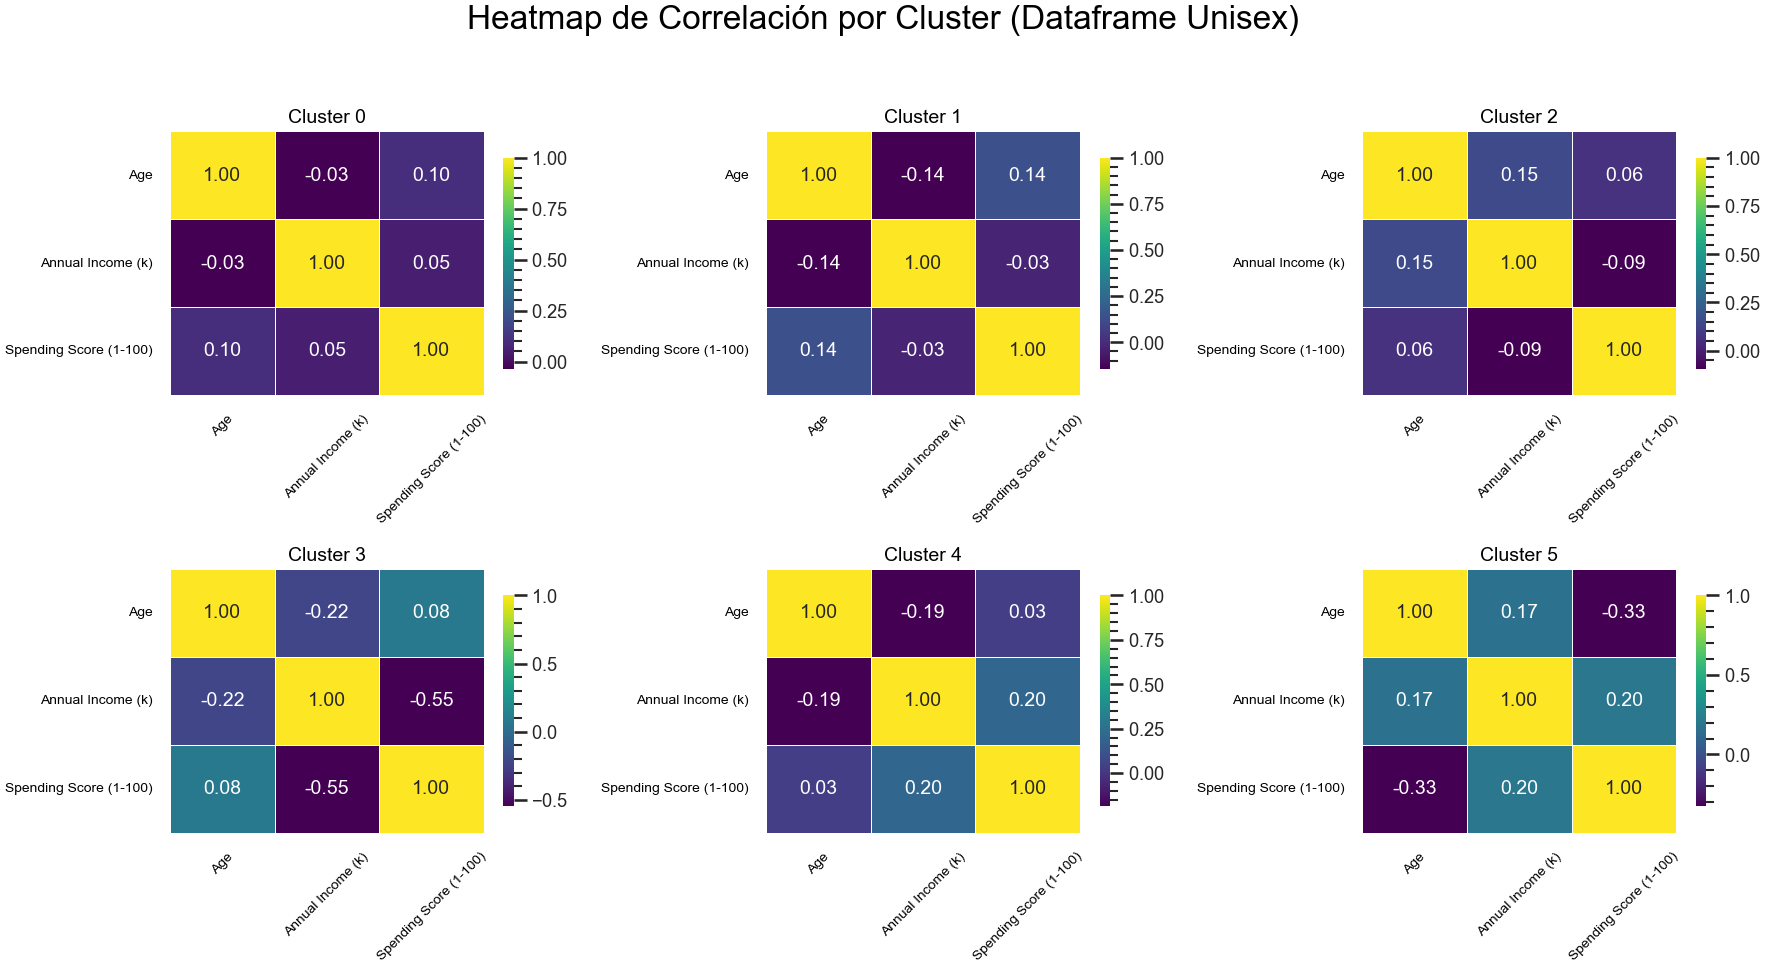

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aplicar estilo oscuro con viridis
sns.set_theme(style="darkgrid")
sns.set_context("talk", font_scale=0.8)

# Excluir 'CustomerID' y 'Gender'
df_filtered = df_cleaned_cluster_3D_unisex.drop(columns=['CustomerID', 'Gender'])

# Obtener los clusters únicos
clusters = sorted(df_filtered['Cluster'].unique())

# Crear figura con 2 filas y 3 columnas de subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Iterar por cada cluster y generar heatmaps
for idx, cluster in enumerate(clusters):
    row, col = divmod(idx, 3)  # Calcular fila y columna
    ax = axes[row, col]
    
    # Filtrar datos por cluster
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster].drop(columns=['Cluster'])
    
    # Crear heatmap con viridis
    sns.heatmap(
        cluster_data.corr(),
        annot=True,
        cmap="viridis",  # Paleta elegida
        linewidths=0.5,  # Bordes de celdas
        fmt=".2f",
        ax=ax,
        annot_kws={"size": 14},  # Tamaño de texto
        cbar_kws={"shrink": 0.8}
    )
    ax.set_title(f"Cluster {cluster}", fontsize=14, color="black")
    ax.tick_params(axis='x', rotation=45, labelsize=10, colors="black")
    ax.tick_params(axis='y', rotation=0, labelsize=10, colors="black")

# Título general
fig.suptitle("Heatmap de Correlación por Cluster (Dataframe Unisex)", fontsize=24, color="black")

# Ajuste del diseño
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [139]:
from rich.console import Console
from rich.table import Table
import pandas as pd

# Filtrar los datos para edades entre 18 y 32 años
df_filtered = df_cleaned[(df_cleaned["Age"] >= 18) & (df_cleaned["Age"] <= 45)]

# Definir los rangos de Annual Income usando el dataframe filtrado
bins = [0, 49, 68, df_filtered["Annual Income (k$)"].max()]
labels = ["0-49", "50-68", "69+"]

# Crear una nueva columna con los grupos basados en Annual Income
df_filtered["Income Group"] = pd.cut(df_filtered["Annual Income (k$)"], bins=bins, labels=labels, right=True)

# Calcular el promedio simple del Spending Score para cada grupo
spending_mean = df_filtered.groupby("Income Group")["Spending Score (1-100)"].mean()

# Crear la tabla con rich para mostrar los resultados
console = Console()
table = Table(title="Promedio Simple del Gasto por Grupo de Ingreso (Edades 18-32)")

# Agregar columnas a la tabla
table.add_column("Income Group", justify="center", style="cyan", no_wrap=True)
table.add_column("Spending Mean", justify="center", style="magenta")

# Agregar filas con los datos calculados
for group, spending in spending_mean.items():
    table.add_row(str(group), f"{spending:.2f}")

# Mostrar la tabla en consola
console.print(table)


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\298827061.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\298827061.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



 Promedio Simple del Gasto por  
Grupo de Ingreso (Edades 18-32) 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Income Group ┃ Spending Mean ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│     0-49     │     58.96     │
│    50-68     │     49.25     │
│     69+      │     57.67     │
└──────────────┴───────────────┘

# Male

In [140]:
# Lista de columnas a excluir
columns_to_exclude = ["grupo_ingresos", "Spending Group", "Income Group"]

# Filtrar sin copiar las columnas no deseadas
df_cleaned_masculine = df_cleaned[df_cleaned['Gender'] == 0]

# Filtrar con datos estandarizados sin copiar las columnas no deseadas
df_cleaned_standardized_masculine = df_cleaned_standardized[df_cleaned_standardized['Gender'] == 0]


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\2583863250.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k)',
       'Spending Score (1-100)', 'Cluster'],
      dtype='object')


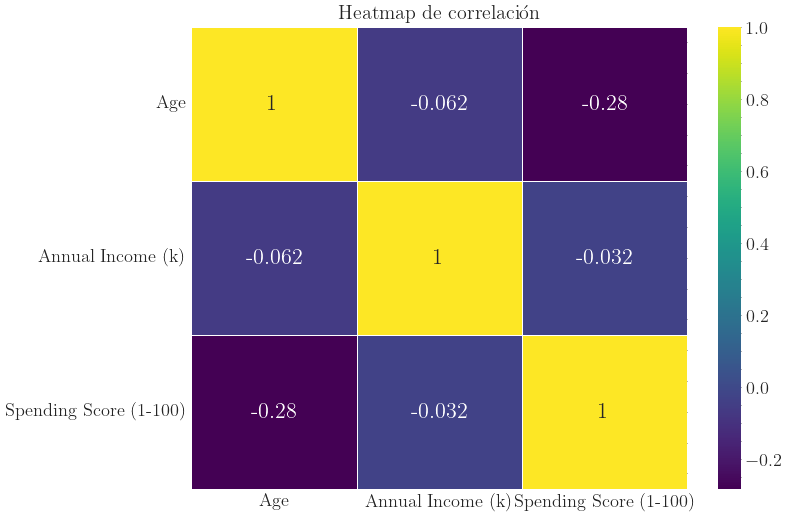

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar el estilo "science" de SciencePlots
plt.style.use(['science'])

# Renombrar la columna
df_cleaned_standardized_masculine.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

# Calcular la matriz de correlación para las columnas de interés
print(df_cleaned_standardized_masculine.columns)
cols = ['Age', 'Annual Income (k)', 'Spending Score (1-100)']
corr_matrix = df_cleaned_standardized_masculine[cols].corr()

# Configurar y mostrar el heatmap utilizando el colormap "viridis"
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap="viridis",
            linewidths=0.5,
            annot_kws={"size": 16})  # Aumenta el tamaño de los números
plt.title('Heatmap de correlación')
plt.show()


In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import os

# Reiniciamos los rcParams a sus valores por defecto
plt.rcdefaults()
# Aplicamos el estilo 'science'
plt.style.use('science')

# Forzamos fondo blanco en ejes y figura
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"

# Configuraciones para limitar el número de hilos
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Seleccionamos únicamente las columnas de interés
df_cluster = df_cleaned_standardized_masculine[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definimos el rango de clusters (k de 2 a 40)
k_values = np.array(list(range(2, 40)))

# Listas para almacenar las métricas que nos interesan
silhouette_values = []
dunn_values = []
calinski_values = []
davies_values = []  # Nueva métrica

# Función para calcular el índice de Dunn
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    intra_dists = [np.max(cdist(X[labels == label], [centroids[i]])) for i, label in enumerate(unique_labels)]
    inter_dists = cdist(centroids, centroids)
    np.fill_diagonal(inter_dists, np.inf)
    return np.min(inter_dists) / np.max(intra_dists)

# Cálculo de las métricas para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    
    silhouette_values.append(silhouette_score(df_cluster, labels))
    calinski_values.append(calinski_harabasz_score(df_cluster, labels))
    davies_values.append(davies_bouldin_score(df_cluster, labels))  # Nueva métrica
    try:
        dunn_values.append(dunn_index(df_cluster.to_numpy(), labels))
    except Exception:
        dunn_values.append(np.nan)

# Función para marcar los valores máximos y mínimos
def marcar_top(ax, x_vals, y_vals, n_points=3, minimo=False):
    mask = (x_vals >= 4) & (x_vals <= 15)
    x_area = x_vals[mask]
    y_area = np.array(y_vals)[mask]
    
    if len(y_area) >= n_points:
        top_indices = np.argsort(y_area)[:n_points] if minimo else np.argsort(y_area)[-n_points:]
    else:
        top_indices = np.argsort(y_area)
    
    handles = []
    labels_leg = []
    for idx in top_indices:
        x_pt = x_area[idx]
        y_pt = y_area[idx]
        sc = ax.scatter(x_pt, y_pt, s=120, marker='D', facecolors='white', edgecolors='black', zorder=5)
        handles.append(sc)
        labels_leg.append(f"n={x_pt} | {y_pt:.3f}")
    ax.legend(handles, labels_leg, title=f"Top {n_points}", loc="best")

# Graficamos las métricas en subplots de 2 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Coeficiente de Silueta
axs[0, 0].plot(k_values, silhouette_values, marker='o', color='orange')
axs[0, 0].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[0, 0], k_values, silhouette_values, n_points=3)
axs[0, 0].set_title("Coeficiente de Silueta")
axs[0, 0].set_xlabel("Número de clusters")
axs[0, 0].set_ylabel("Silhouette Score")

# 2. Índice de Dunn
axs[0, 1].plot(k_values, dunn_values, marker='o', color='green')
axs[0, 1].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[0, 1], k_values, dunn_values, n_points=3)
axs[0, 1].set_title("Índice de Dunn")
axs[0, 1].set_xlabel("Número de clusters")
axs[0, 1].set_ylabel("Dunn Index")

# 3. Índice de Calinski-Harabasz
axs[1, 0].plot(k_values, calinski_values, marker='o', color='red')
axs[1, 0].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[1, 0], k_values, calinski_values, n_points=3)
axs[1, 0].set_title("Índice de Calinski-Harabasz")
axs[1, 0].set_xlabel("Número de clusters")
axs[1, 0].set_ylabel("Calinski-Harabasz Score")

# 4. Índice de Davies-Bouldin (mínimos)
axs[1, 1].plot(k_values, davies_values, marker='o', color='blue')
axs[1, 1].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[1, 1], k_values, davies_values, n_points=3, minimo=True)
axs[1, 1].set_title("Índice de Davies-Bouldin")
axs[1, 1].set_xlabel("Número de clusters")
axs[1, 1].set_ylabel("Davies-Bouldin Score")

plt.tight_layout()
plt.show()


c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

ahora veremos donde convergen

aunque me parece un poco curioso que este necesite mas clusterde clasificacion y eso que son la mitad de los datos

In [143]:
from rich.table import Table
from rich.console import Console
import numpy as np

console = Console()

# Creamos la tabla con las columnas deseadas
table = Table(title="Clusters óptimos por Métrica (rango [4,15])")
table.add_column("Métrica", style="bold")
table.add_column("Cluster óptimo 1", justify="center")
table.add_column("Cluster óptimo 2", justify="center")
table.add_column("Cluster óptimo 3", justify="center")

n_points = 3  # Número de clusters destacados a mostrar
mask = (k_values >= 4) & (k_values <= 15)
k_area = k_values[mask]

def obtener_clusters_optimos(metric_values, minimo=False):
    metric_area = np.array(metric_values)[mask]
    # Para métricas a maximizar, seleccionamos los índices con valores mayores;
    # para métricas a minimizar (como Davies-Bouldin) seleccionamos los índices con valores menores.
    if minimo:
        top_indices = np.argsort(metric_area)[:n_points]
    else:
        top_indices = np.argsort(metric_area)[-n_points:]
    # Ordenamos los clusters para que se muestren en forma creciente
    return np.sort(k_area[top_indices])

# Obtenemos los clusters óptimos para cada métrica
clusters_silhouette = obtener_clusters_optimos(silhouette_values, minimo=False)
clusters_dunn = obtener_clusters_optimos(dunn_values, minimo=False)
clusters_calinski = obtener_clusters_optimos(calinski_values, minimo=False)
clusters_davies = obtener_clusters_optimos(davies_values, minimo=True)

# Agregamos las filas a la tabla
table.add_row("Coeficiente de Silueta",
              str(clusters_silhouette[0]),
              str(clusters_silhouette[1]),
              str(clusters_silhouette[2]))
table.add_row("Índice de Dunn",
              str(clusters_dunn[0]),
              str(clusters_dunn[1]),
              str(clusters_dunn[2]))
table.add_row("Calinski-Harabasz",
              str(clusters_calinski[0]),
              str(clusters_calinski[1]),
              str(clusters_calinski[2]))
table.add_row("Davies-Bouldin",
              str(clusters_davies[0]),
              str(clusters_davies[1]),
              str(clusters_davies[2]))

console.print(table)

# Calculamos la intersección de los clusters obtenidos en cada métrica
clusters_comunes = set(clusters_silhouette) & set(clusters_dunn) & set(clusters_calinski) & set(clusters_davies)

# Convertimos el conjunto a una lista ordenada (si no está vacío)
clusters_comunes = sorted(list(clusters_comunes))

# Creamos una nueva tabla para mostrar los clusters comunesa
table_comunes = Table(title="Cluster(s) que aparecen en todas las métricas")
table_comunes.add_column("Cluster Común", justify="center", style="bold cyan")

# Si se encontró al menos un cluster común, lo agregamos a la tabla
if clusters_comunes:
    for cluster in clusters_comunes:
        table_comunes.add_row(str(cluster))
else:
    table_comunes.add_row("No hay clusters comunes")

console.print(table_comunes)



                    Clusters óptimos por Métrica (rango [4,15])                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Métrica                ┃ Cluster óptimo 1 ┃ Cluster óptimo 2 ┃ Cluster óptimo 3 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Coeficiente de Silueta │        5         │        9         │        11        │
│ Índice de Dunn         │        4         │        5         │        11        │
│ Calinski-Harabasz      │        10        │        11        │        12        │
│ Davies-Bouldin         │        8         │        11        │        14        │
└────────────────────────┴──────────────────┴──────────────────┴──────────────────┘

 Cluster(s) que  
aparecen en todas
  las métricas   
┏━━━━━━━━━━━━━━━┓
┃ Cluster Común ┃
┡━━━━━━━━━━━━━━━┩
│      11       │
└───────────────┘

el parameto optimo de cluster es 11

In [144]:
from sklearn.cluster import KMeans

# Seleccionar las columnas de interés
features = df_cleaned_standardized_masculine[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definir el modelo K-means con 11 clusters
kmeans = KMeans(n_clusters=11, random_state=42)

# Entrenar el modelo
kmeans.fit(features)

# Asignar la etiqueta de cluster a cada observación (opcional)
df_cleaned_standardized_masculine['Cluster'] = kmeans.labels_


c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\225703725.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:
import plotly.graph_objects as go
import plotly.express as px

# Obtener clusters únicos
clusters = sorted(df_cleaned_standardized_masculine['Cluster'].unique())

# Usar la paleta de colores "Set1" para mayor contraste
contrast_colors = px.colors.qualitative.Set1

# Crear figura
fig = go.Figure()

# Agregar una traza para cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized_masculine[df_cleaned_standardized_masculine['Cluster'] == cluster]
    color = contrast_colors[i % len(contrast_colors)]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data["Annual Income (k)"],
        y=cluster_data["Age"],
        z=cluster_data["Spending Score (1-100)"],
        mode='markers',
        marker=dict(
            size=5,
            color=color,
            opacity=0.8,
            line=dict(color='black', width=1)  # Borde negro similar al 'edgecolor' en matplotlib
        ),
        name=f'Cluster {cluster}'
    ))

# Configurar layout con estilo profesional y científico
fig.update_layout(
    title='Clusters en 3D',
    scene=dict(
        xaxis=dict(title='Ingreso Anual (k)', titlefont=dict(size=12)),
        yaxis=dict(title='Edad', titlefont=dict(size=12)),
        zaxis=dict(title='Puntuación de Gasto (1-100)', titlefont=dict(size=12)),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1))
    ),
    legend=dict(
        title=dict(text='Cluster', font=dict(size=12)),
        font=dict(size=10)
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\3796484818.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



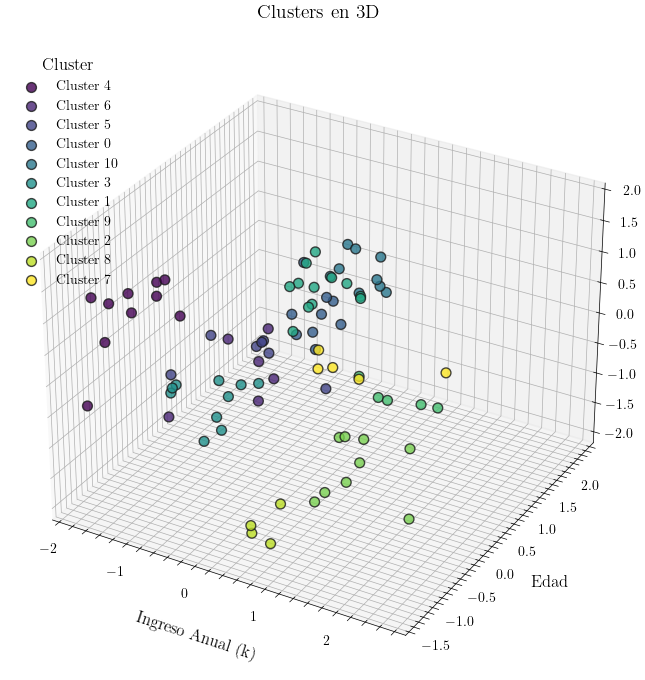

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# Reiniciamos los rcParams a sus valores por defecto
plt.rcdefaults()
# Aplicamos el estilo 'science'
plt.style.use('science')
# Crear figura y eje 3D
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Obtener clusters únicos y definir un mapa de colores profesional
clusters = df_cleaned_standardized_masculine['Cluster'].unique()
colors = plt.cm.get_cmap('viridis', len(clusters))  # Mapa de colores 'viridis' es elegante y profesional

# Graficar cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized_masculine[df_cleaned_standardized_masculine['Cluster'] == cluster]
    ax.scatter(
        cluster_data["Annual Income (k)"],
        cluster_data["Age"],
        cluster_data["Spending Score (1-100)"],
        s=50,
        alpha=0.8,
        edgecolor='k',
        color=colors(i),
        label=f'Cluster {cluster}'
    )

# Configurar etiquetas y título con estilo científico
ax.set_xlabel('Ingreso Anual (k)', fontsize=12, labelpad=10)
ax.set_ylabel('Edad', fontsize=12, labelpad=10)
ax.set_zlabel('Puntuación de Gasto (1-100)', fontsize=12, labelpad=10)
ax.set_title('Clusters en 3D', fontsize=14, pad=20)

# Configurar leyenda con estilo
ax.legend(title='Cluster', title_fontsize=12, fontsize=10, loc='upper left')

# Mejorar el layout para una presentación más limpia
plt.tight_layout()

plt.show()


In [147]:
# Copiar el DataFrame original para no modificarlo
df_cleaned_cluster_3D_masculine = df_cleaned_masculine.copy()

# Agregar la columna de cluster
df_cleaned_cluster_3D_masculine['Cluster'] = df_cleaned_standardized_masculine['Cluster'].copy()

In [148]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_masculine = df_cleaned_cluster_3D_masculine.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_masculine.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_masculine.groupby('Cluster').agg(lambda x: skew(x, nan_policy='omit', bias=False))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la tabla con rich
console = Console()
table = Table(title="Estadísticas por Cluster Unisex")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla en la consola
console.print(table)


                                          Estadísticas por Cluster Unisex                                          
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃   (k$) ┃   (k$) ┃   (k$) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃  (k$) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  52.78 │   4.74 │  53.00 │  55.22 │   7.08 │  54.00 │ 49.22 │   5.63 │ 47.00 │   0.27 │ -0.69 │   0.97 │
│   1    │  35.17 │   4.00 │  35.50 │  78.50 │   9.57 │  76.00 │ 88.00 │   8.70 │ 90.50 │  -0.45 │  1.24 │  -0.95 │
│   2    │  39.78 │   5.09 │  40.00 │  86.22 │  12.71 │  86.00 │ 10.44 │   6.60 │ 10.00 │   0.10 │  1.23 │  -0.24 │
│   3    │  21.60 │   3.69 │  19.50 │  56.90 │   7.42 │  59.50 │ 52.60 │   5.76 │ 54.50 │   0.53 │ -0.37 │  -0.95 │
│   4    │  24.40 │   5.62 │  23.00 │  24.70 │   7.39 │  24.50 │ 73.80 │  15.80 │ 76.00 │   0.80 │  0.35 │  -1.11 │
│   5    │  40.57 │   5.74 │  40.00 │  46.71 │  14.76 │  43.00 │ 44.29 │  10.23 │ 41.00 │   0.08 │  0.20 │   0.65 │
│   6    │  55.50 │  10.82 │  56.50 │  24.00 │   6.07 │  21.50 │ 11.17 │   9.99 │  8.50 │  -0.99 │  0.85 │   1.33 │
│   7    │  29.40 │   2.41 │  28.00 │  97.80 │  16.84 │  88.00 │ 69.80 │   4.87 │ 69.00 │   0.47 │  1.66 │  -0.38 │
│   8    │  20.75 │   2.87 │  19.50 │  76.25 │   3.59 │  75.50 │  8.00 │   3.56 │  7.50 │   1.85 │  0.89 │   0.27 │
│   9    │  54.80 │   5.36 │  58.00 │  82.80 │   8.79 │  85.00 │ 20.40 │  10.41 │ 15.00 │  -0.66 │ -0.38 │   1.01 │
│   10   │  67.22 │   2.33 │  67.00 │  54.67 │   8.12 │  54.00 │ 50.11 │   6.09 │ 51.00 │  -0.50 │ -0.06 │  -0.12 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

In [149]:
#Cambiamos el nombre de una columna que contiene un símbolo especial 
df_cleaned_cluster_3D_masculine.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

bueno tenemos varios cluster asimetricos siendo un total de 8 cluster asimetricos el cual son 0,1,2,3,4,6,7,8

Estadísticos Originales (Cluster 0 - Spending Score (1-100)):
Min: 42, Max: 60
Media: 49.222, Mediana: 47.000, Desviación estándar: 5.630
Skewness: 0.974

Estadísticos Winsorizados (Cluster 0 - Spending Score (1-100)):
Min: 42, Max: 56
Media: 48.778, Mediana: 47.000, Desviación estándar: 4.764
Skewness: 0.570


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




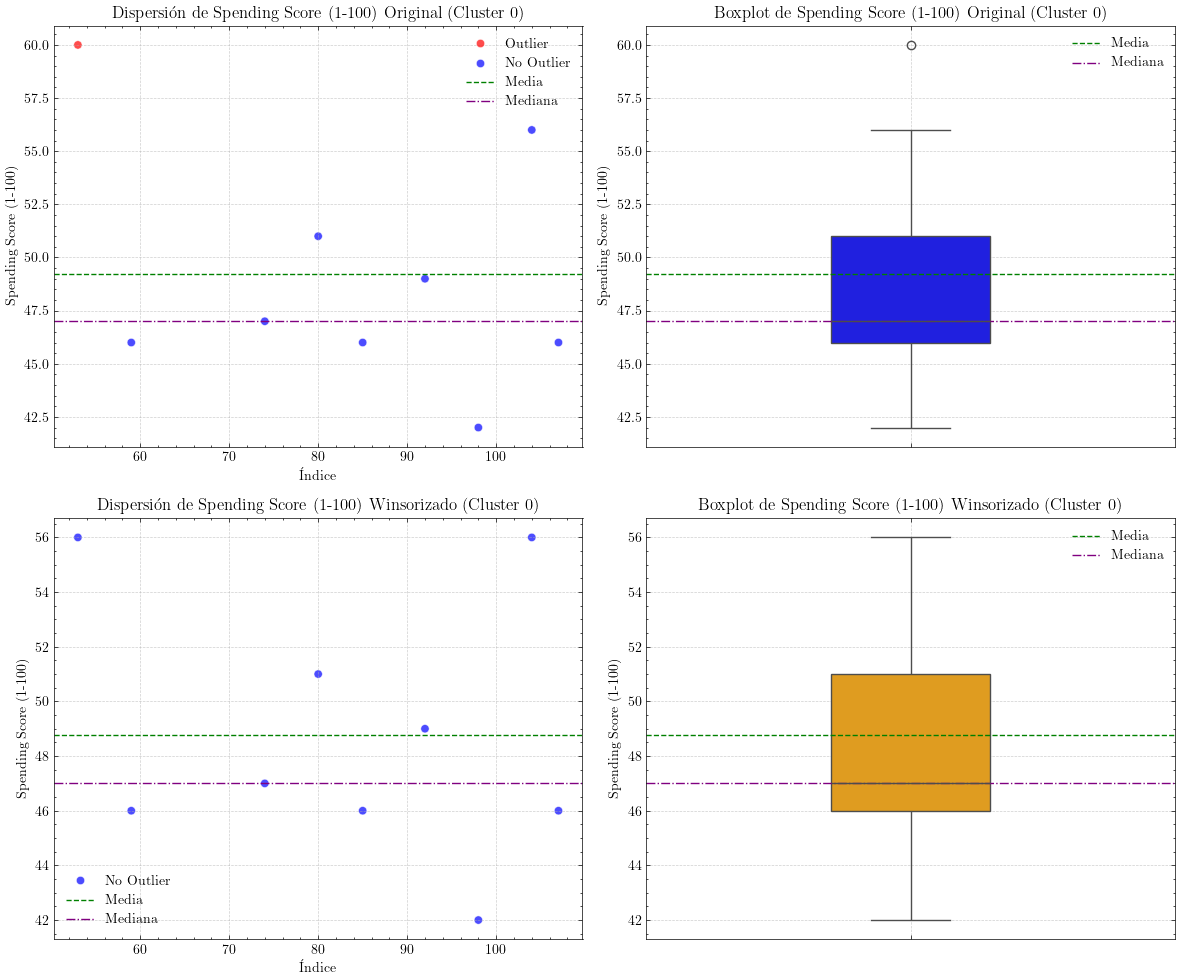

Estadísticos Originales (Cluster 1 - Annual Income (k)):
Min: 69, Max: 99
Media: 78.500, Mediana: 76.000, Desviación estándar: 9.568
Skewness: 1.238

Estadísticos Winsorizados (Cluster 1 - Annual Income (k)):
Min: 69, Max: 87
Media: 77.000, Mediana: 76.000, Desviación estándar: 6.701
Skewness: 0.642


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




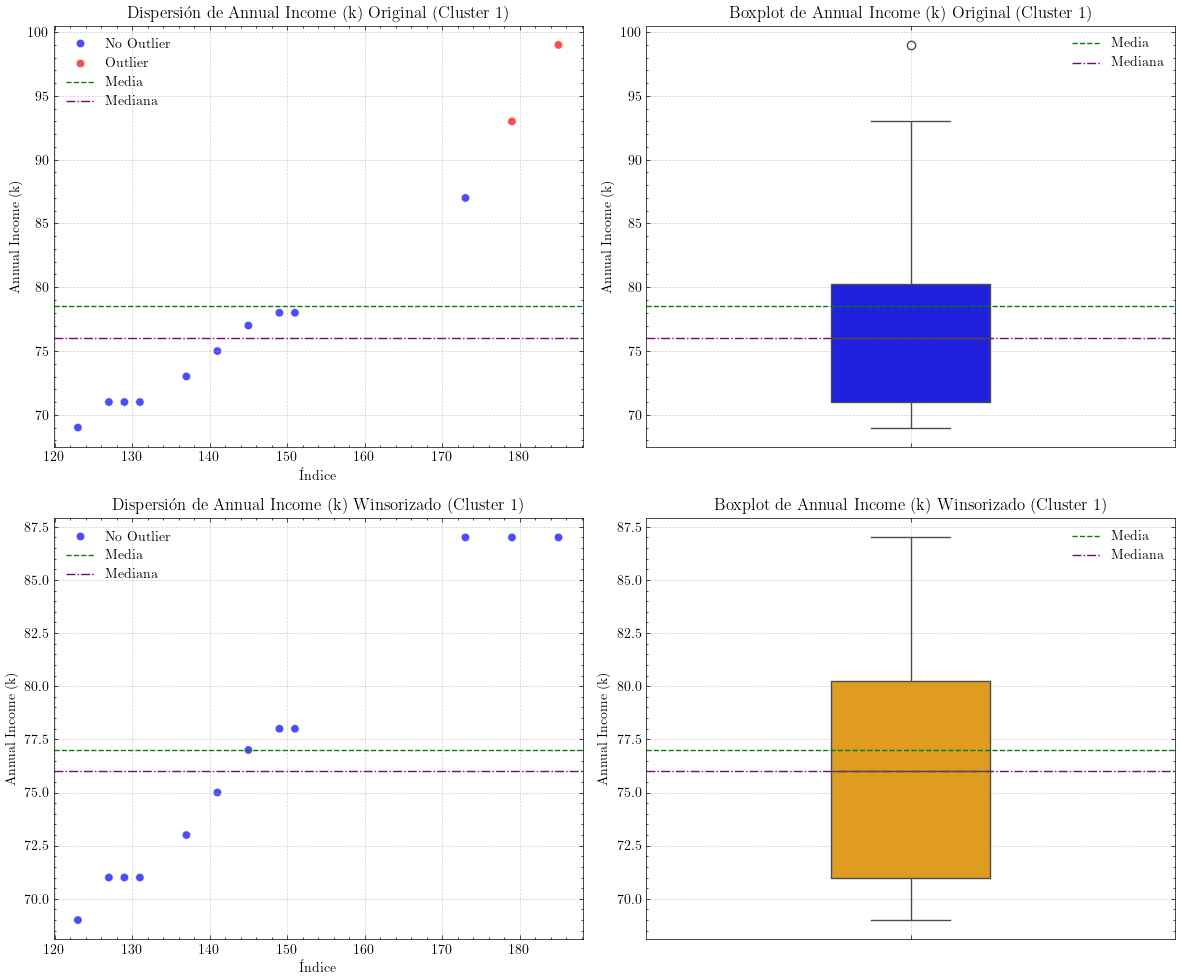

Estadísticos Originales (Cluster 1 - Spending Score (1-100)):
Min: 73, Max: 97
Media: 88.000, Mediana: 90.500, Desviación estándar: 8.697
Skewness: -0.951

Estadísticos Winsorizados (Cluster 1 - Spending Score (1-100)):
Min: 88, Max: 97
Media: 91.417, Mediana: 90.500, Desviación estándar: 3.423
Skewness: 0.633


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




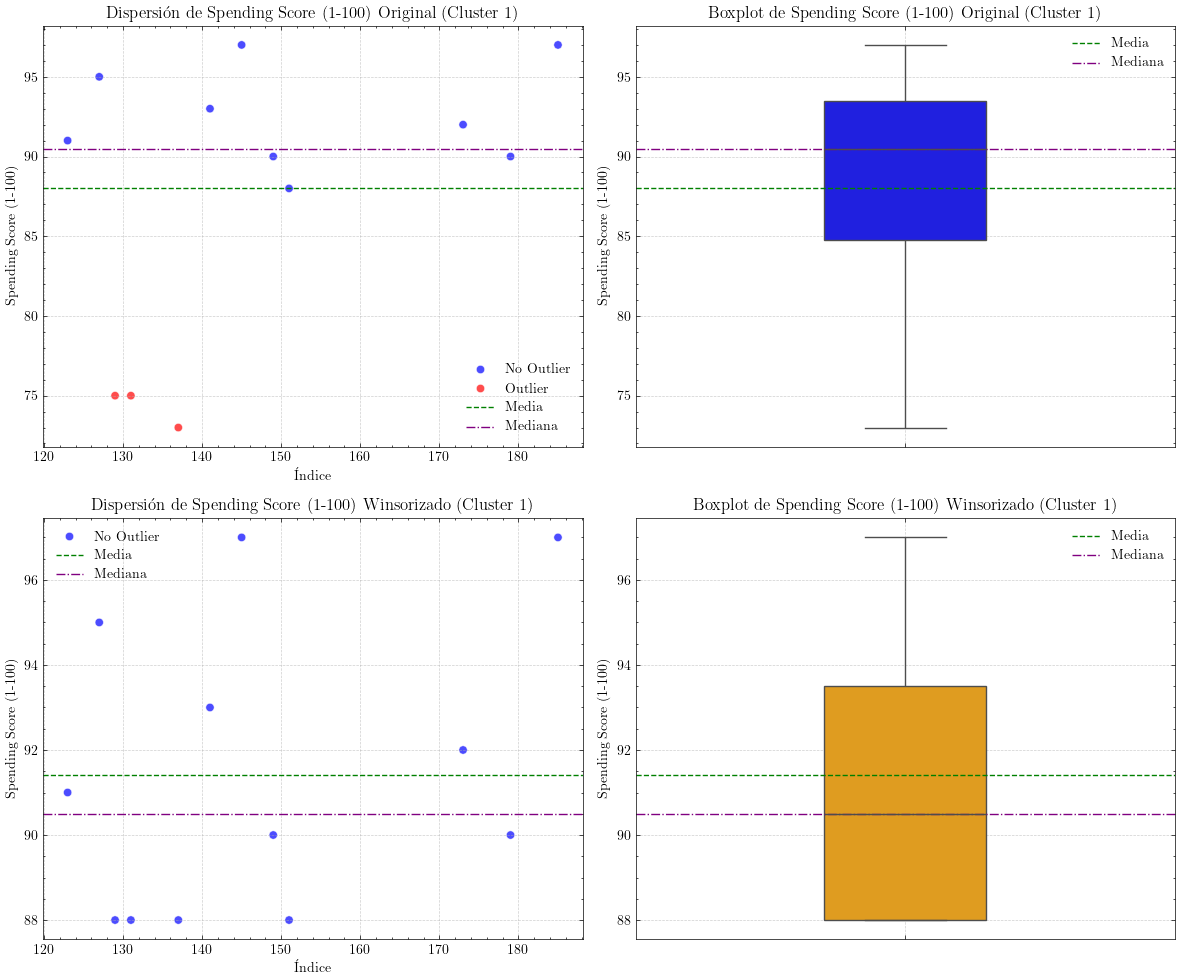

Estadísticos Originales (Cluster 2 - Annual Income (k)):
Min: 71, Max: 113
Media: 86.222, Mediana: 86.000, Desviación estándar: 12.706
Skewness: 1.225

Estadísticos Winsorizados (Cluster 2 - Annual Income (k)):
Min: 71, Max: 98
Media: 84.556, Mediana: 86.000, Desviación estándar: 9.275
Skewness: 0.313


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




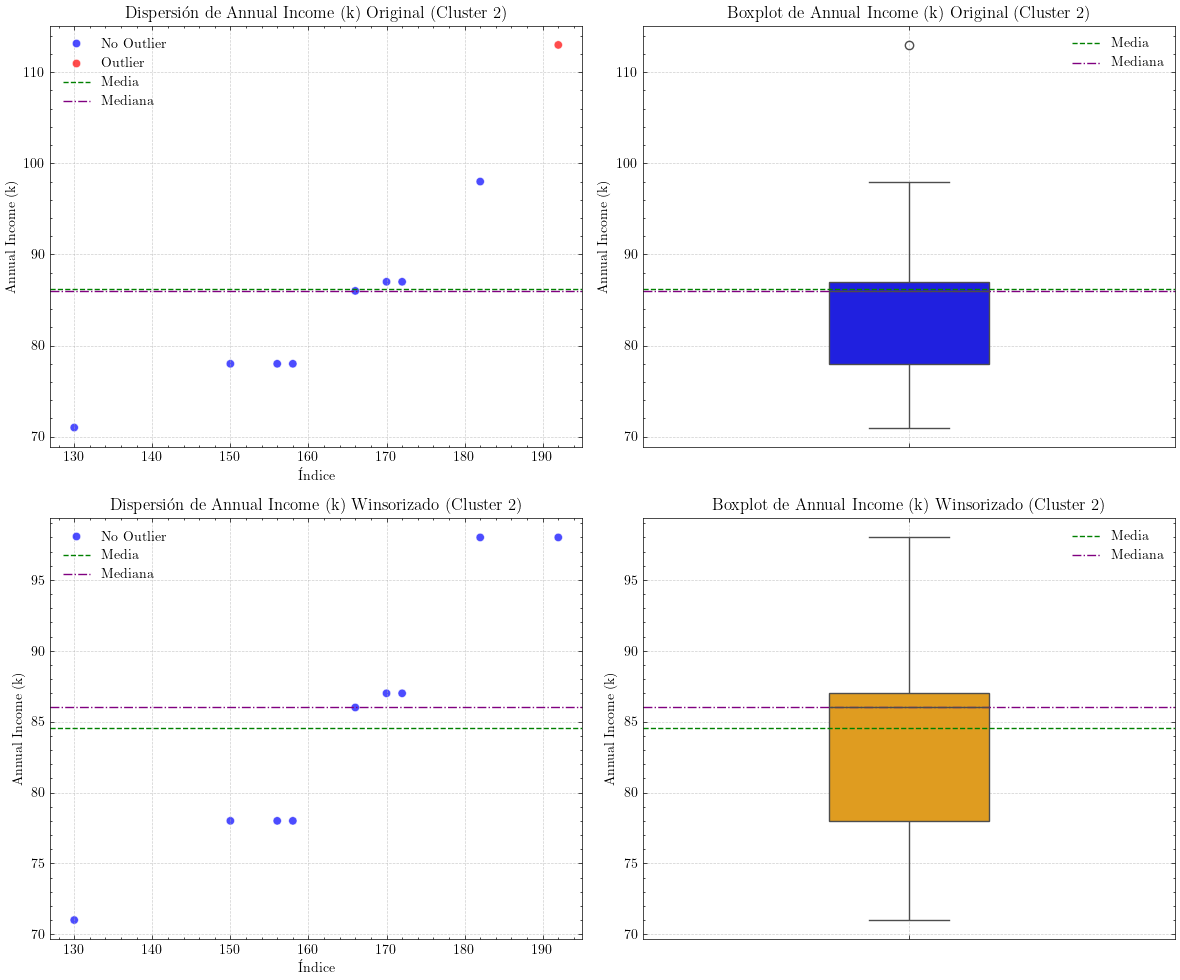

Estadísticos Originales (Cluster 3 - Spending Score (1-100)):
Min: 41, Max: 59
Media: 52.600, Mediana: 54.500, Desviación estándar: 5.758
Skewness: -0.947

Estadísticos Winsorizados (Cluster 3 - Spending Score (1-100)):
Min: 46, Max: 59
Media: 53.100, Mediana: 54.500, Desviación estándar: 4.771
Skewness: -0.430


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Estadísticos Originales (Cluster 4 - Spending Score (1-100)):
Min: 39, Max: 92
Media: 73.800, Mediana: 76.000, Desviación estándar: 15.796
Skewness: -1.113

Estadísticos Winsorizados (Cluster 4 - Spending Score (1-100)):
Min: 61, Max: 92
Media: 76.000, Mediana: 76.000, Desviación estándar: 11.304
Skewness: 0.073


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




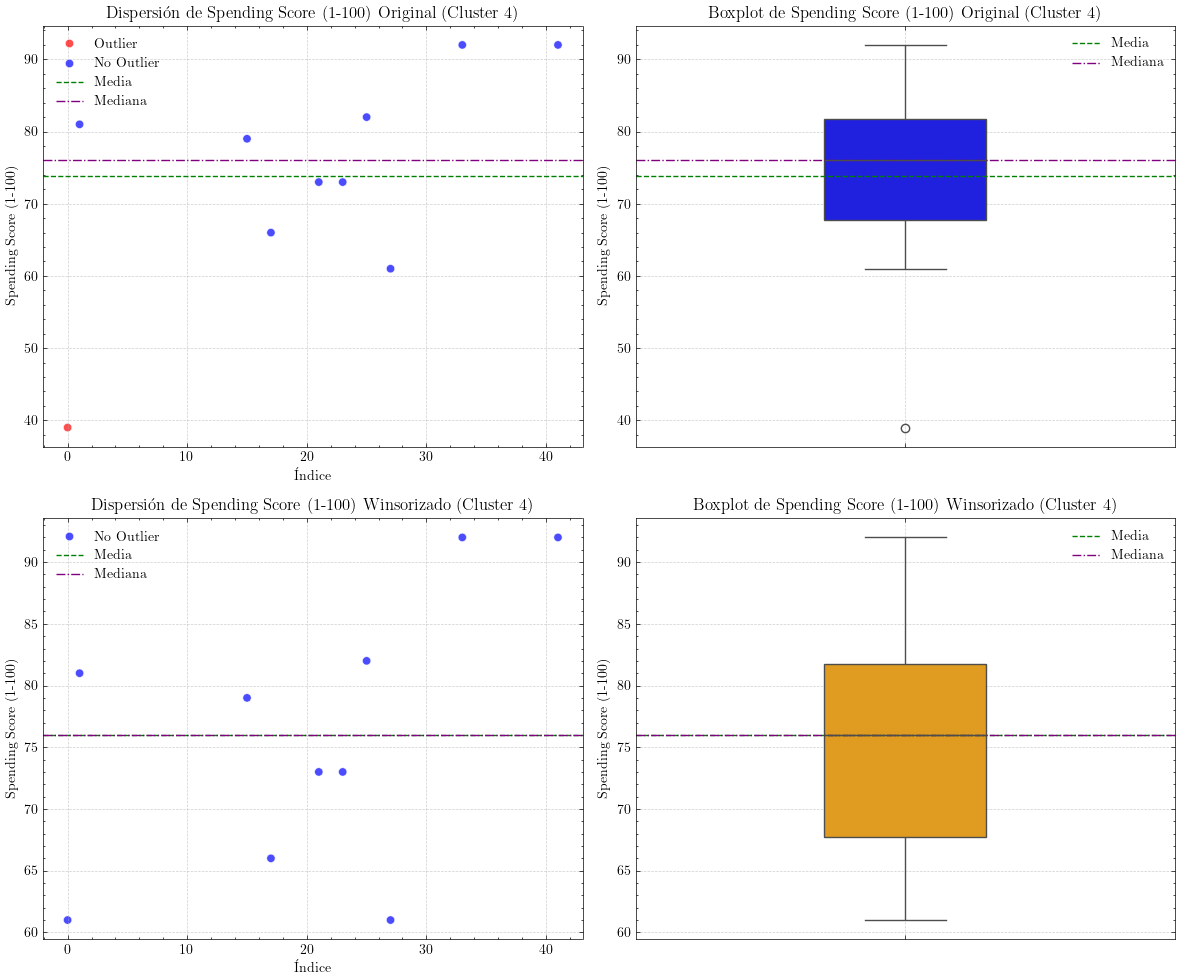

Estadísticos Originales (Cluster 4 - Age):
Min: 18, Max: 35
Media: 24.400, Mediana: 23.000, Desviación estándar: 5.621
Skewness: 0.796

Estadísticos Winsorizados (Cluster 4 - Age):
Min: 18, Max: 31
Media: 24.000, Mediana: 23.000, Desviación estándar: 4.876
Skewness: 0.446


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




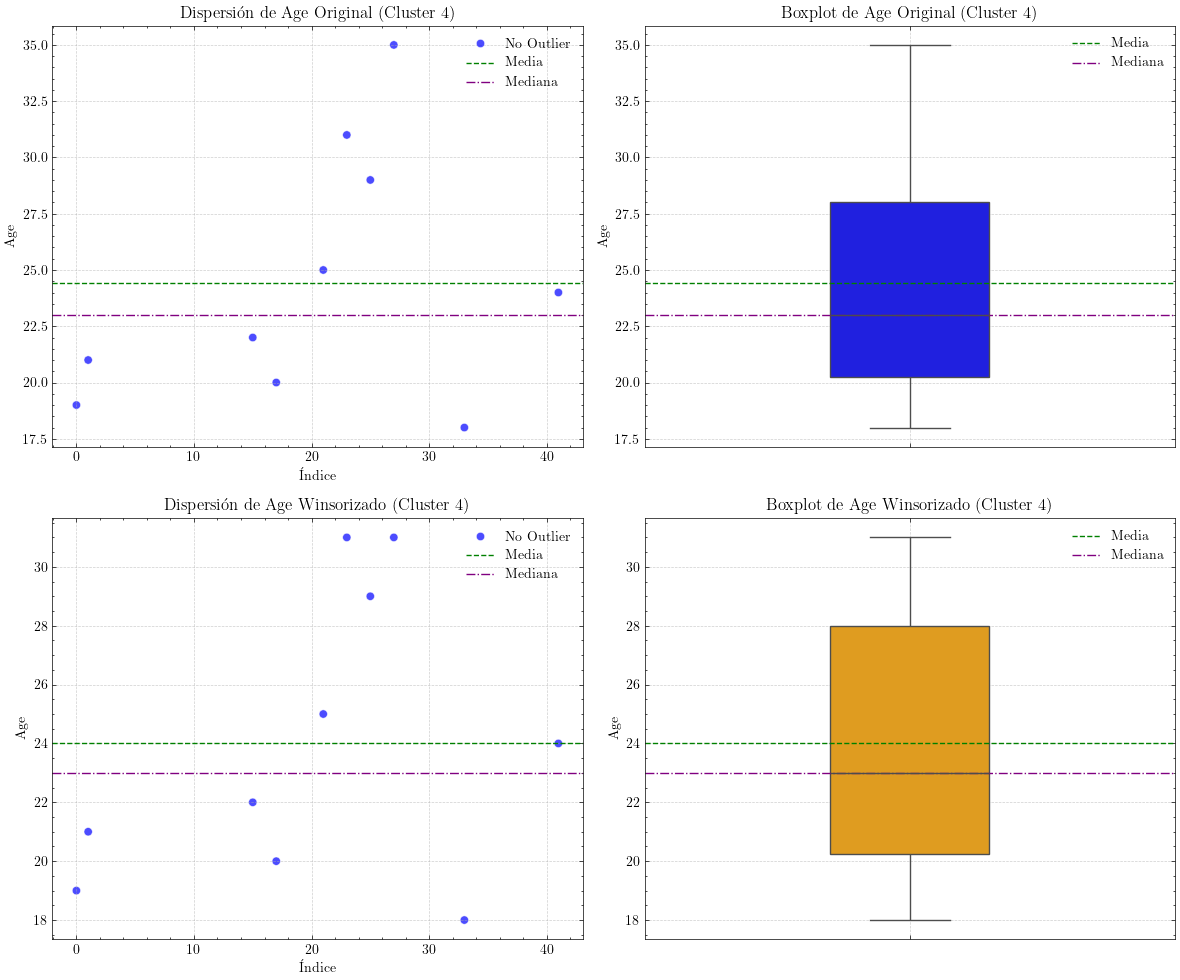

Estadísticos Originales (Cluster 6 - Age):
Min: 37, Max: 67
Media: 55.500, Mediana: 56.500, Desviación estándar: 10.821
Skewness: -0.986

Estadísticos Winsorizados (Cluster 6 - Age):
Min: 52, Max: 67
Media: 58.000, Mediana: 56.500, Desviación estándar: 6.603
Skewness: 0.413


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




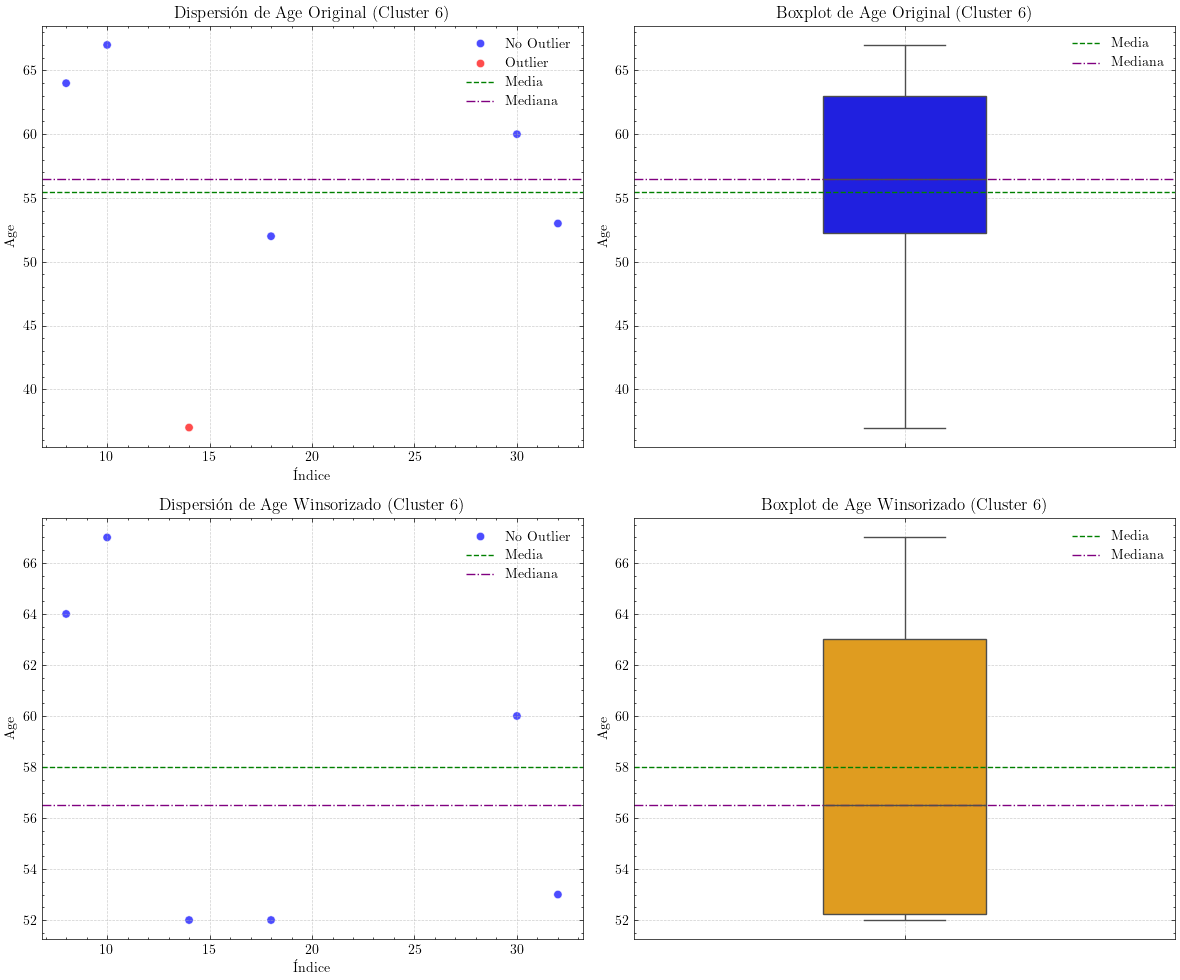

Estadísticos Originales (Cluster 6 - Spending Score (1-100)):
Min: 3, Max: 29
Media: 11.167, Mediana: 8.500, Desviación estándar: 9.988
Skewness: 1.331

Estadísticos Winsorizados (Cluster 6 - Spending Score (1-100)):
Min: 3, Max: 14
Media: 8.667, Mediana: 8.500, Desviación estándar: 5.502
Skewness: -0.001


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




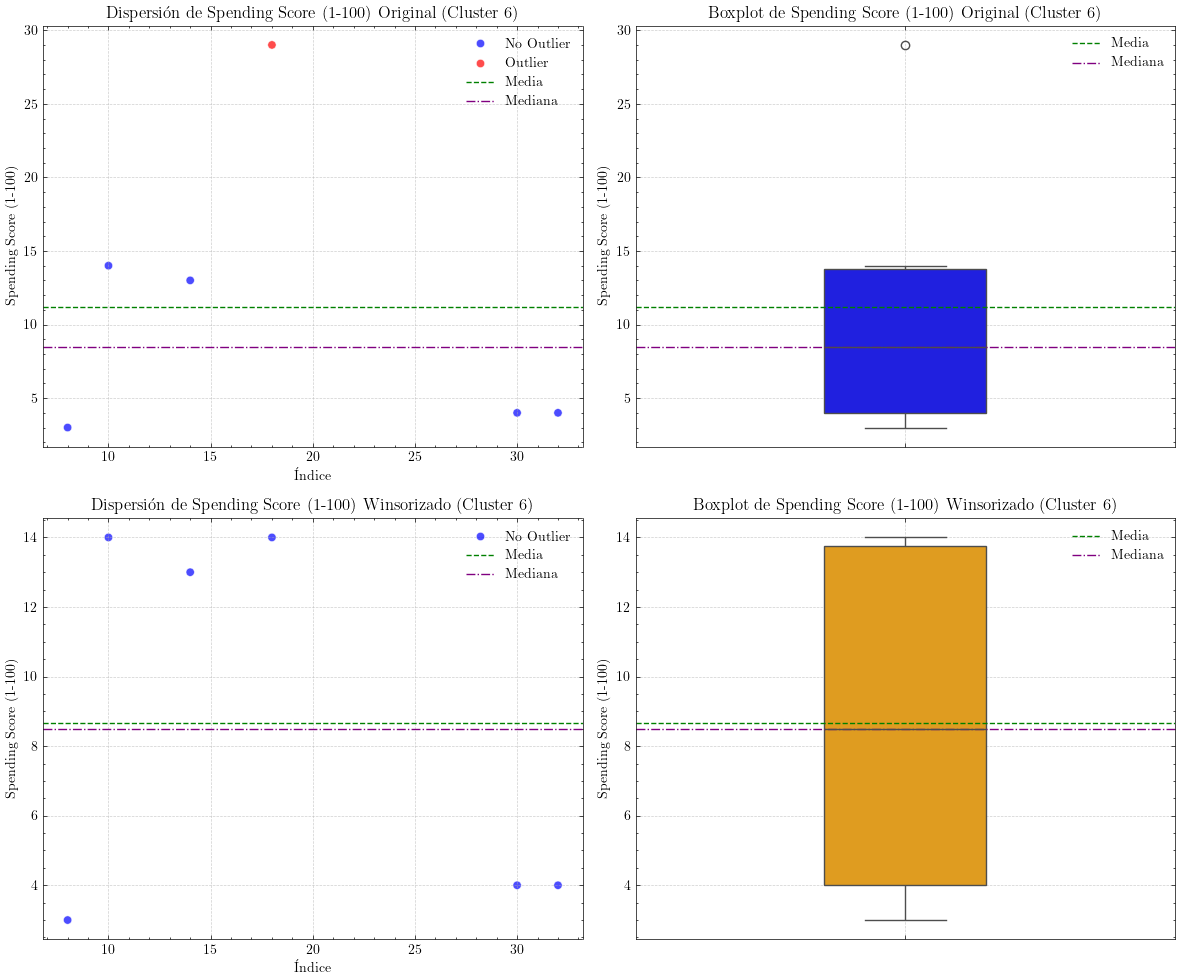

Estadísticos Originales (Cluster 6 - Annual Income (k)):
Min: 19, Max: 33
Media: 24.000, Mediana: 21.500, Desviación estándar: 6.066
Skewness: 0.847

Estadísticos Winsorizados (Cluster 6 - Annual Income (k)):
Min: 19, Max: 30
Media: 23.500, Mediana: 21.500, Desviación estándar: 5.244
Skewness: 0.674


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




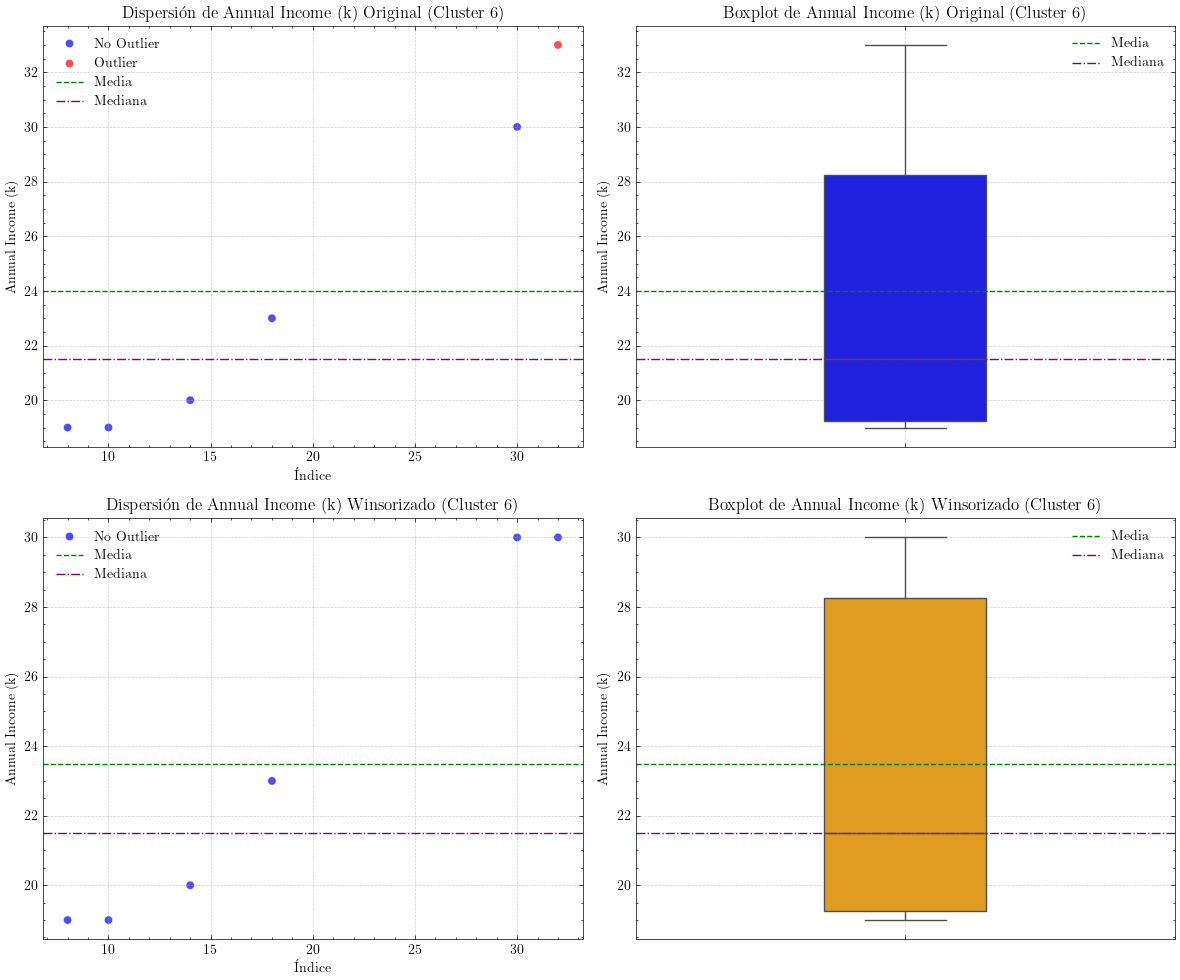

Estadísticos Originales (Cluster 7 - Annual Income (k)):
Min: 87, Max: 126
Media: 97.800, Mediana: 88.000, Desviación estándar: 16.843
Skewness: 1.657

Estadísticos Winsorizados (Cluster 7 - Annual Income (k)):
Min: 87, Max: 101
Media: 92.800, Mediana: 88.000, Desviación estándar: 7.497
Skewness: 0.595


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




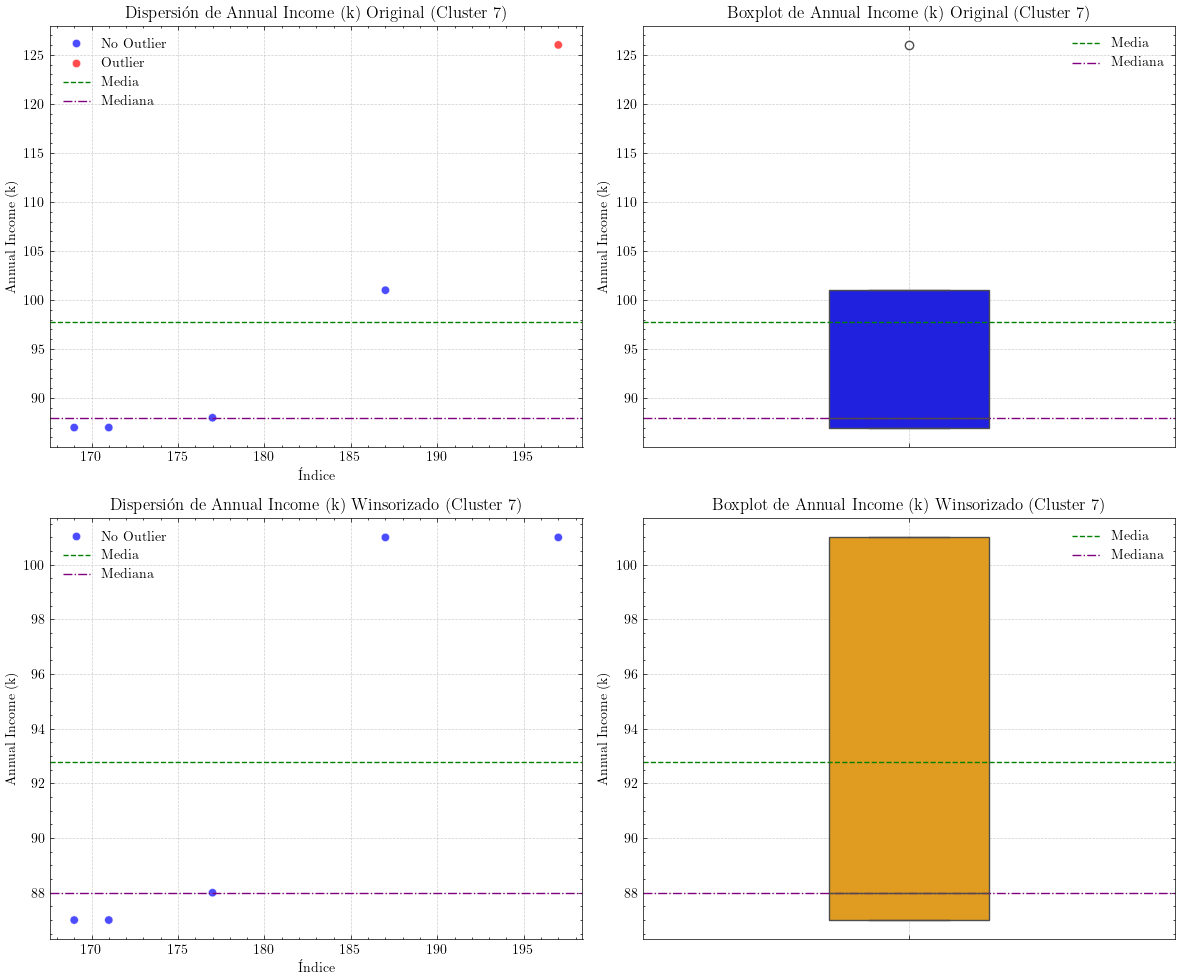

Estadísticos Originales (Cluster 8 - Age):
Min: 19, Max: 25
Media: 20.750, Mediana: 19.500, Desviación estándar: 2.872
Skewness: 1.846

Estadísticos Winsorizados (Cluster 8 - Age):
Min: 19, Max: 20
Media: 19.500, Mediana: 19.500, Desviación estándar: 0.577
Skewness: 0.000


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




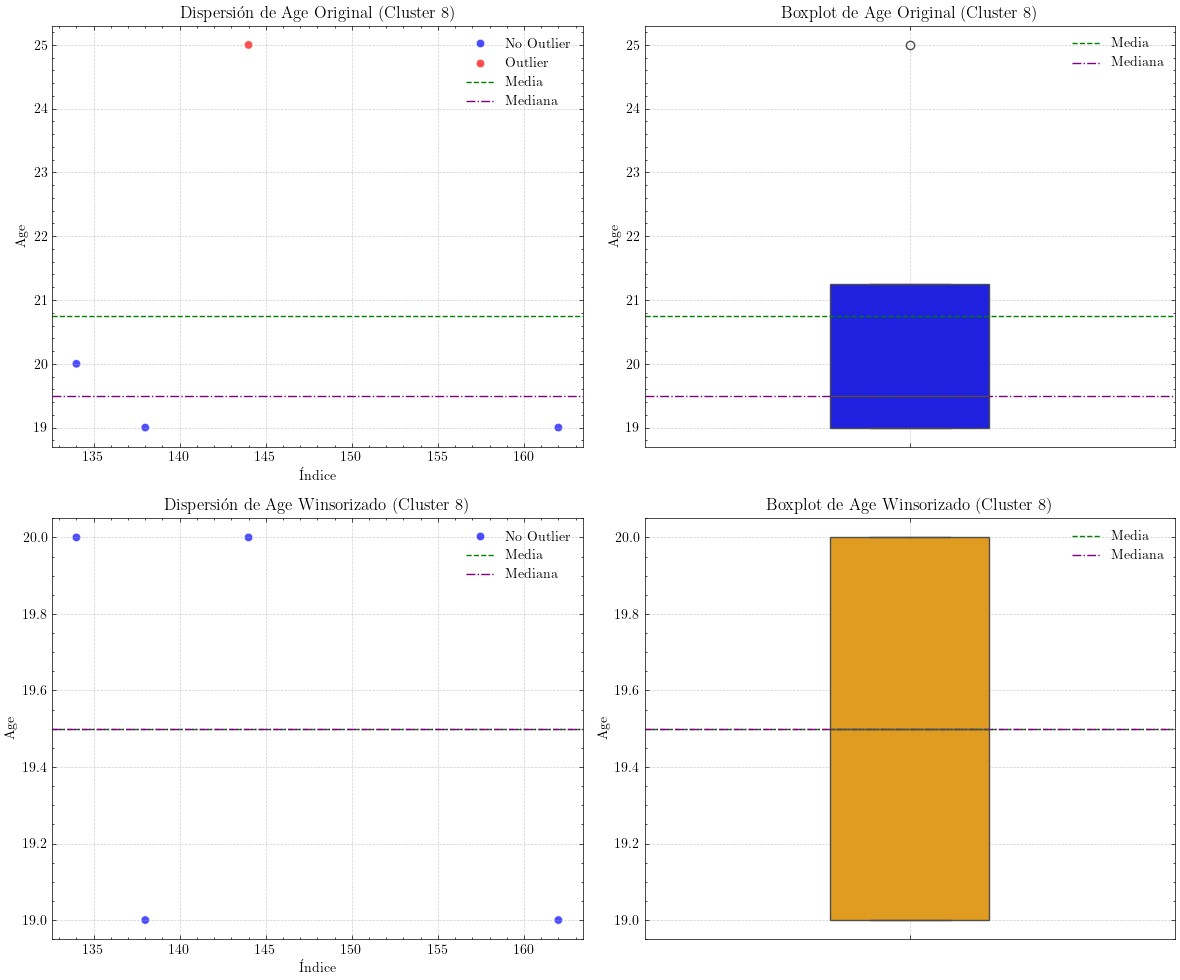

Estadísticos Originales (Cluster 8 - Annual Income (k)):
Min: 73, Max: 81
Media: 76.250, Mediana: 75.500, Desviación estándar: 3.594
Skewness: 0.889

Estadísticos Winsorizados (Cluster 8 - Annual Income (k)):
Min: 73, Max: 77
Media: 75.250, Mediana: 75.500, Desviación estándar: 2.062
Skewness: -0.200


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




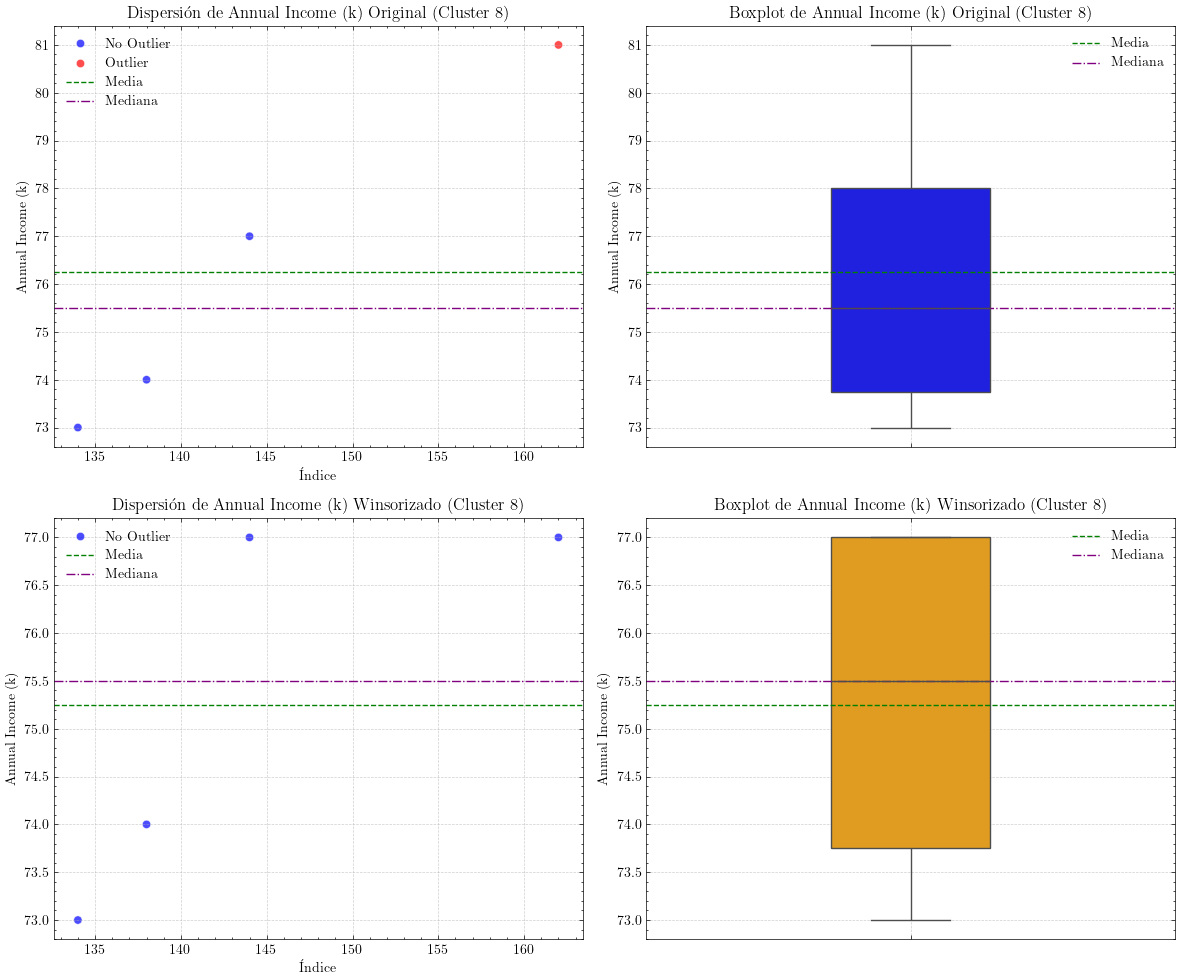

Estadísticos Originales (Cluster 9 - Spending Score (1-100)):
Min: 11, Max: 36
Media: 20.400, Mediana: 15.000, Desviación estándar: 10.407
Skewness: 1.006

Estadísticos Winsorizados (Cluster 9 - Spending Score (1-100)):
Min: 11, Max: 26
Media: 18.400, Mediana: 15.000, Desviación estándar: 7.092
Skewness: 0.407


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




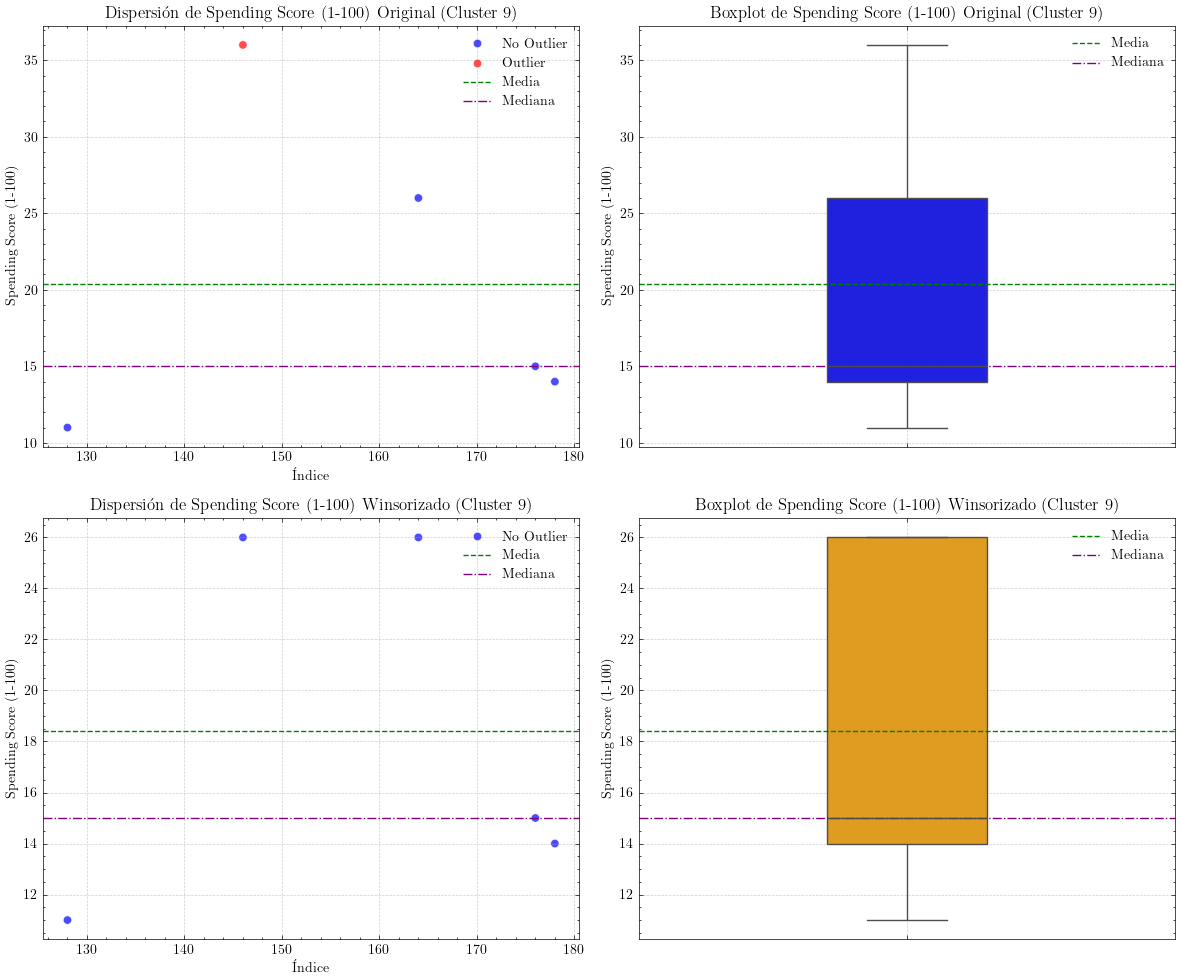

In [150]:
#Cluster 0 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=0, columna="Spending Score (1-100)", win_limits=[0, 0.2], iqr_factor=1.5, titulo_extra="(Cluster 0)")


#Cluster 1 columna Spending Annual Income (k)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=1, columna="Annual Income (k)", win_limits=[0, 0.2], iqr_factor=1, titulo_extra="(Cluster 1)")
#Cluster 1 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=1, columna="Spending Score (1-100)", win_limits=[0.3, 0], iqr_factor=1, titulo_extra="(Cluster 1)")

#Cluster 2 columna Annual Income (k)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=2, columna="Annual Income (k)", win_limits=[0, 0.2], iqr_factor=1.5, titulo_extra="(Cluster 2)")

#Cluster 3 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=3, columna="Spending Score (1-100)", win_limits=[0.1, 0], iqr_factor=1, titulo_extra="(Cluster 3)")

#Cluster 4 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=4, columna="Spending Score (1-100)", win_limits=[0.1, 0], iqr_factor=1.5, titulo_extra="(Cluster 4)")
#Cluster 4 columna Age
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=4, columna="Age", win_limits=[0, 0.1], iqr_factor=1.5, titulo_extra="(Cluster 4)")

#Cluster 6 columna Age
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=6, columna="Age", win_limits=[0.2, 0], iqr_factor=1, titulo_extra="(Cluster 6)")
#Cluster 6 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=6, columna="Spending Score (1-100)", win_limits=[0, 0.2], iqr_factor=1.5, titulo_extra="(Cluster 6)")
#Cluster 6 columna Age
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=6, columna="Annual Income (k)", win_limits=[0, 0.2], iqr_factor=0.5, titulo_extra="(Cluster 6)")

#Cluster 7 columna Annual Income (k)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=7, columna="Annual Income (k)", win_limits=[0, 0.2], iqr_factor=1.5, titulo_extra="(Cluster 7)")

#Cluster 8 columna Age
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=8, columna="Age", win_limits=[0, 0.3], iqr_factor=1, titulo_extra="(Cluster 8)")
#Cluster 8 columna Annual Income
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=8, columna="Annual Income (k)", win_limits=[0, 0.3], iqr_factor=0.5, titulo_extra="(Cluster 8)")

#Cluster 9 columna Spending Score (1-100)
procesar_cluster(df_cleaned_cluster_3D_masculine, cluster_valor=9, columna="Spending Score (1-100)", win_limits=[0, 0.2], iqr_factor=0.5, titulo_extra="(Cluster 9)")



In [151]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_masculine = df_cleaned_cluster_3D_masculine.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_masculine.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_masculine.groupby('Cluster').agg(lambda x: skew(x, nan_policy='omit',bias=False))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la consola de Rich
console = Console()

# ───────────────────────────────────────────────────
# TABLA PRINCIPAL DE ESTADÍSTICAS
# ───────────────────────────────────────────────────
table_stats = Table(title="Estadísticas por Cluster Masculine")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table_stats.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table_stats.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table_stats.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla de estadísticas
console.print(table_stats)

# ───────────────────────────────────────────────────
# TABLA DE RANGOS (Media ± Desviación Estándar)
# ───────────────────────────────────────────────────
table_ranges = Table(title="Rangos de Edad, Ingreso y Gasto")

# Columnas principales
table_ranges.add_column("Cluster", justify="center", style="bold cyan")
table_ranges.add_column("Age Range", justify="right", style="yellow")
table_ranges.add_column("Annual Income Range", justify="right", style="green")
table_ranges.add_column("Spending Score Range", justify="right", style="blue")

# Agregar filas con los rangos calculados
for cluster, row in estadisticas.iterrows():
    age_mean = row[('Age', 'mean')]
    age_std = row[('Age', 'std')]
    
    income_mean = row[('Annual Income (k)', 'mean')]
    income_std = row[('Annual Income (k)', 'std')]
    
    spending_mean = row[('Spending Score (1-100)', 'mean')]
    spending_std = row[('Spending Score (1-100)', 'std')]
    
    # Calcular rangos
    age_range = f"{age_mean - age_std:.1f} - {age_mean + age_std:.1f}"
    income_range = f"{income_mean - income_std:.1f} - {income_mean + income_std:.1f}"
    spending_range = f"{spending_mean - spending_std:.1f} - {spending_mean + spending_std:.1f}"
    
    # Agregar fila
    table_ranges.add_row(str(cluster), age_range, income_range, spending_range)

# Mostrar la tabla de rangos
console.print(table_ranges)


                                        Estadísticas por Cluster Masculine                                         
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃    (k) ┃    (k) ┃    (k) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃   (k) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  52.78 │   4.74 │  53.00 │  55.22 │   7.08 │  54.00 │ 48.78 │   4.76 │ 47.00 │   0.27 │ -0.69 │   0.57 │
│   1    │  35.17 │   4.00 │  35.50 │  77.00 │   6.70 │  76.00 │ 91.42 │   3.42 │ 90.50 │  -0.45 │  0.64 │   0.63 │
│   2    │  39.78 │   5.09 │  40.00 │  84.56 │   9.28 │  86.00 │ 10.44 │   6.60 │ 10.00 │   0.10 │  0.31 │  -0.24 │
│   3    │  21.60 │   3.69 │  19.50 │  56.90 │   7.42 │  59.50 │ 53.10 │   4.77 │ 54.50 │   0.53 │ -0.37 │  -0.43 │
│   4    │  24.00 │   4.88 │  23.00 │  24.70 │   7.39 │  24.50 │ 76.00 │  11.30 │ 76.00 │   0.45 │  0.35 │   0.07 │
│   5    │  40.57 │   5.74 │  40.00 │  46.71 │  14.76 │  43.00 │ 44.29 │  10.23 │ 41.00 │   0.08 │  0.20 │   0.65 │
│   6    │  58.00 │   6.60 │  56.50 │  23.50 │   5.24 │  21.50 │  8.67 │   5.50 │  8.50 │   0.41 │  0.67 │  -0.00 │
│   7    │  29.40 │   2.41 │  28.00 │  92.80 │   7.50 │  88.00 │ 69.80 │   4.87 │ 69.00 │   0.47 │  0.60 │  -0.38 │
│   8    │  19.50 │   0.58 │  19.50 │  75.25 │   2.06 │  75.50 │  8.00 │   3.56 │  7.50 │   0.00 │ -0.20 │   0.27 │
│   9    │  54.80 │   5.36 │  58.00 │  82.80 │   8.79 │  85.00 │ 18.40 │   7.09 │ 15.00 │  -0.66 │ -0.38 │   0.41 │
│   10   │  67.22 │   2.33 │  67.00 │  54.67 │   8.12 │  54.00 │ 50.11 │   6.09 │ 51.00 │  -0.50 │ -0.06 │  -0.12 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

                   Rangos de Edad, Ingreso y Gasto                    
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃   Age Range ┃ Annual Income Range ┃ Spending Score Range ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│    0    │ 48.0 - 57.5 │         48.1 - 62.3 │          44.0 - 53.5 │
│    1    │ 31.2 - 39.2 │         70.3 - 83.7 │          88.0 - 94.8 │
│    2    │ 34.7 - 44.9 │         75.3 - 93.8 │           3.8 - 17.0 │
│    3    │ 17.9 - 25.3 │         49.5 - 64.3 │          48.3 - 57.9 │
│    4    │ 19.1 - 28.9 │         17.3 - 32.1 │          64.7 - 87.3 │
│    5    │ 34.8 - 46.3 │         32.0 - 61.5 │          34.1 - 54.5 │
│    6    │ 51.4 - 64.6 │         18.3 - 28.7 │           3.2 - 14.2 │
│    7    │ 27.0 - 31.8 │        85.3 - 100.3 │          64.9 - 74.7 │
│    8    │ 18.9 - 20.1 │         73.2 - 77.3 │           4.4 - 11.6 │
│    9    │ 49.4 - 60.2 │         74.0 - 91.6 │          11.3 - 25.5 │
│   10    │ 64.9 - 69.6 │         46.5 - 62.8 │          44.0 - 56.2 │
└─────────┴─────────────┴─────────────────────┴──────────────────────┘

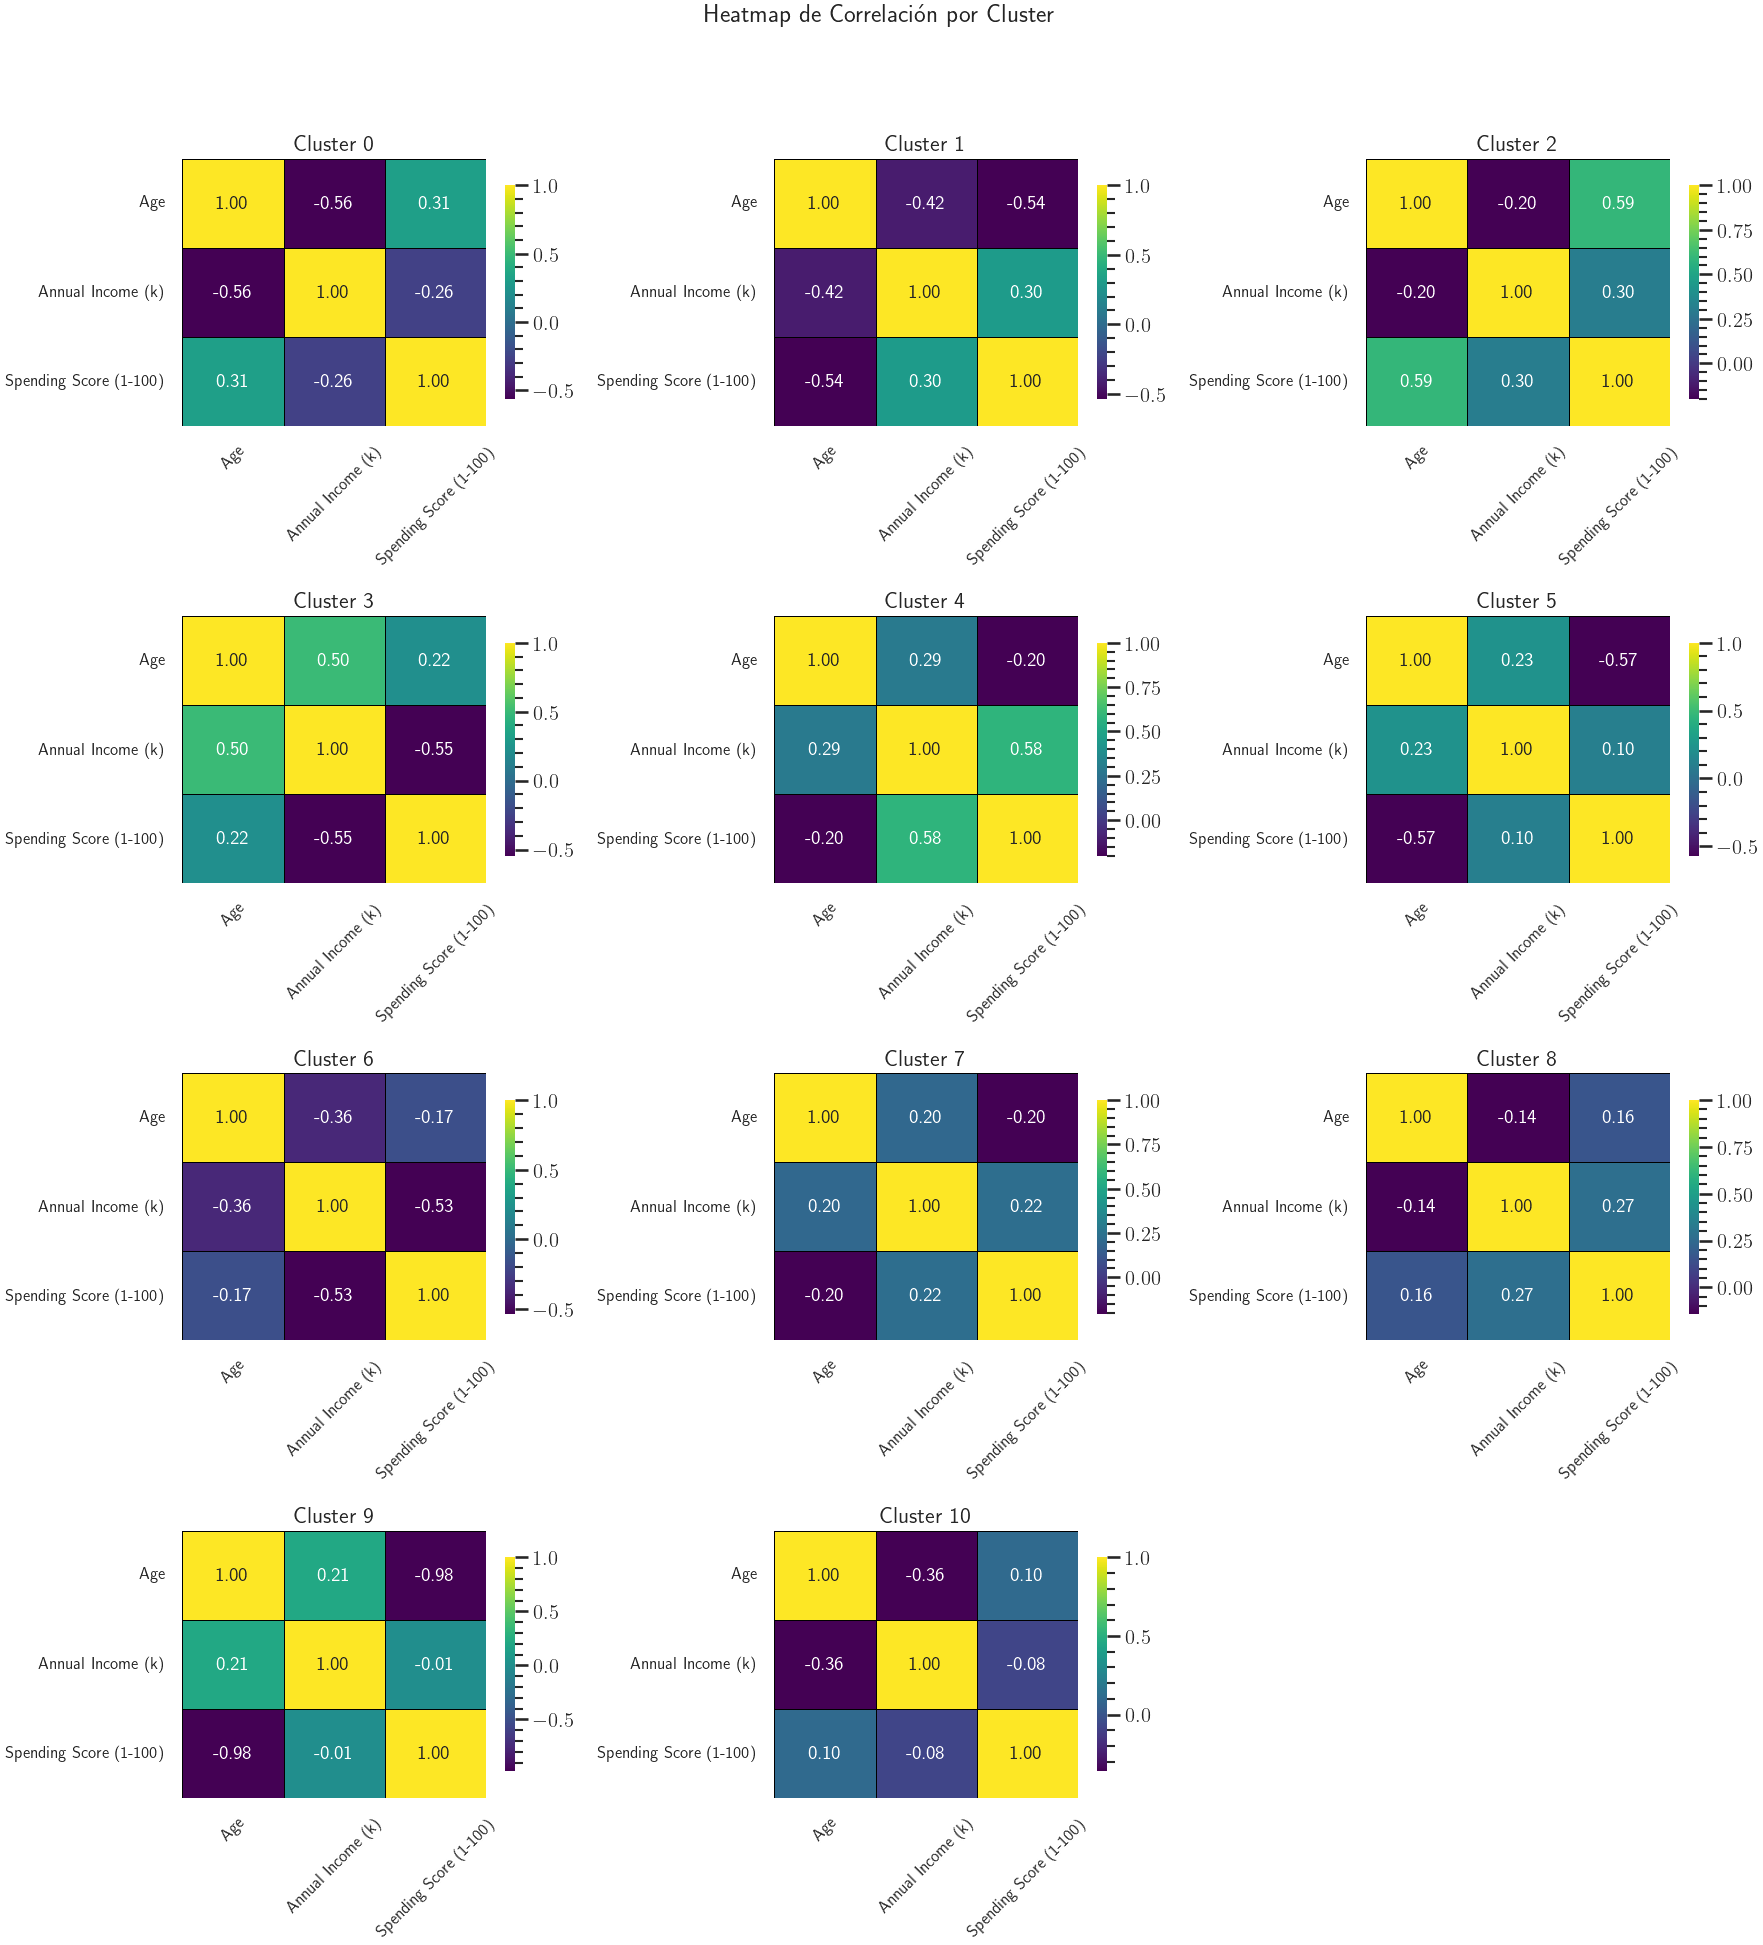

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ajustar el estilo y contexto de Seaborn
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=0.9)

# Excluir 'CustomerID' y 'Gender'
df_filtered = df_cleaned_cluster_3D_masculine.drop(columns=['CustomerID', 'Gender'])

# Obtener los clusters únicos (ordenados)
clusters = sorted(df_filtered['Cluster'].unique())

# Determinar el número de filas y columnas necesarias
num_clusters = len(clusters)
cols = 3  # Puedes cambiarlo según prefieras
rows = int(np.ceil(num_clusters / cols))  # Calcula el número de filas necesarias

# Crear figura con los subplots adecuados
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))

# Asegurar que `axes` es un array plano si tiene solo una fila
axes = np.array(axes).flatten()

# Iterar por cada cluster y ubicarlos en el subplot correspondiente
for idx, cluster in enumerate(clusters):
    ax = axes[idx]  # Acceder directamente sin calcular filas y columnas
    
    # Filtrar los datos para el cluster actual
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster].drop(columns=['Cluster'])
    
    # Crear heatmap de correlación con estilo 'viridis'
    sns.heatmap(
        cluster_data.corr(),
        annot=True,
        cmap="viridis",  # Cambio de color
        fmt=".2f",
        ax=ax,
        annot_kws={"size": 14, "weight": "bold"},  # Tamaño de los valores dentro de los cuadros aumentado
        cbar_kws={"shrink": 0.8},
        linewidths=0.5,  # Agregar separación entre los cuadros
        linecolor="black"
    )
    
    ax.set_title(f"Cluster {cluster}", fontsize=16, fontweight="bold")
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', rotation=0, labelsize=12)

# Eliminar subplots vacíos (si hay más espacios de los necesarios)
for idx in range(num_clusters, len(axes)):
    fig.delaxes(axes[idx])

# Título general
fig.suptitle("Heatmap de Correlación por Cluster", fontsize=18, fontweight="bold")

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [153]:
correlation_dict = {}

# Iterar por cada cluster
for cluster in clusters:
    # Filtrar los datos para el cluster actual
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster].drop(columns=['Cluster'])
    
    # Calcular la matriz de correlación y almacenarla en el diccionario
    correlation_dict[cluster] = cluster_data.corr()

# Ahora `correlation_dict` contiene las correlaciones de cada cluster


In [154]:
# Función para determinar el color según las correlaciones importantes
def get_color_for_variable(cluster, variable, corr_dict):
    # Obtener la matriz de correlación para el cluster
    corr_matrix = corr_dict[cluster]
    
    # Lista para almacenar las correlaciones significativas
    significativas = []
    
    # Recorrer cada variable (omitiendo la diagonal)
    for other in corr_matrix.columns:
        if other == variable:
            continue
        valor = corr_matrix.loc[variable, other]
        # Si la correlación es menor a -0.4 o mayor a 0.4 se considera significativa
        if valor < -0.4 or valor > 0.4:
            significativas.append(valor)
    
    # Si hay al menos dos correlaciones significativas, se asigna color anaranjado claro
    if len(significativas) >= 2:
        return "orange1"
    
    # Si hay exactamente una correlación significativa, se asigna
    # rojo brillante si es negativa o verde brillante si es positiva
    elif len(significativas) == 1:
        if significativas[0] < 0:
            return "bright_red"
        else:
            return "bright_green"
    
    # Si no hay correlaciones significativas, se asigna blanco
    return "white"


# Suponiendo que 'estadisticas' es el DataFrame con la media y std calculados por cluster,
# y que 'corr_dict' contiene la matriz de correlación para cada cluster.
# Además, supongamos que los nombres de las columnas en la matriz de correlación son:
# "Age", "Annual Income (k)" y "Spending Score (1-100)"

from rich.table import Table
from rich.console import Console

console = Console()
table_ranges = Table(title="Rangos de Edad, Ingreso y Gasto")

# Columnas principales y columnas adicionales para mostrar el color
table_ranges.add_column("Cluster", justify="center", style="bold cyan")
table_ranges.add_column("Age Range", justify="right")
table_ranges.add_column("Annual Income Range", justify="right")
table_ranges.add_column("Spending Score Range", justify="right")
table_ranges.add_column("Age Color", justify="center")
table_ranges.add_column("Annual Income Color", justify="center")
table_ranges.add_column("Spending Score Color", justify="center")

# Agregar filas con los rangos calculados y aplicando el color según correlación
for cluster, row in estadisticas.iterrows():
    # Calcular media y desviación estándar
    age_mean = row[('Age', 'mean')]
    age_std = row[('Age', 'std')]
    
    income_mean = row[('Annual Income (k)', 'mean')]
    income_std = row[('Annual Income (k)', 'std')]
    
    spending_mean = row[('Spending Score (1-100)', 'mean')]
    spending_std = row[('Spending Score (1-100)', 'std')]
    
    # Calcular rangos
    age_range = f"{age_mean - age_std:.1f} - {age_mean + age_std:.1f}"
    income_range = f"{income_mean - income_std:.1f} - {income_mean + income_std:.1f}"
    spending_range = f"{spending_mean - spending_std:.1f} - {spending_mean + spending_std:.1f}"
    
    # Obtener colores para cada variable basados en la correlación en el cluster
    age_color = get_color_for_variable(cluster, "Age", correlation_dict)
    income_color = get_color_for_variable(cluster, "Annual Income (k)", correlation_dict)
    spending_color = get_color_for_variable(cluster, "Spending Score (1-100)", correlation_dict)
    
    # Aplicar formato de color a los textos (Rich interpreta [color] ... [/color])
    colored_age_range = f"[{age_color}]{age_range}[/{age_color}]"
    colored_income_range = f"[{income_color}]{income_range}[/{income_color}]"
    colored_spending_range = f"[{spending_color}]{spending_range}[/{spending_color}]"
    
    # Agregar fila a la tabla con las columnas de rangos y las de color (se muestran como texto plano)
    table_ranges.add_row(
        str(cluster),
        colored_age_range,
        colored_income_range,
        colored_spending_range,
        age_color,
        income_color,
        spending_color
    )

# Mostrar la tabla de rangos
console.print(table_ranges)


                                          Rangos de Edad, Ingreso y Gasto                                          
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃         ┃             ┃    Annual Income ┃   Spending Score ┃              ┃  Annual Income  ┃  Spending Score  ┃
┃ Cluster ┃   Age Range ┃            Range ┃            Range ┃  Age Color   ┃      Color      ┃      Color       ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│    0    │ 48.0 - 57.5 │      48.1 - 62.3 │      44.0 - 53.5 │  bright_red  │   bright_red    │      white       │
│    1    │ 31.2 - 39.2 │      70.3 - 83.7 │      88.0 - 94.8 │   orange1    │   bright_red    │    bright_red    │
│    2    │ 34.7 - 44.9 │      75.3 - 93.8 │       3.8 - 17.0 │ bright_green │      white      │   bright_green   │
│    3    │ 17.9 - 25.3 │      49.5 - 64.3 │      48.3 - 57.9 │ bright_green │     orange1     │    bright_red    │
│    4    │ 19.1 - 28.9 │      17.3 - 32.1 │      64.7 - 87.3 │    white     │  bright_green   │   bright_green   │
│    5    │ 34.8 - 46.3 │      32.0 - 61.5 │      34.1 - 54.5 │  bright_red  │      white      │    bright_red    │
│    6    │ 51.4 - 64.6 │      18.3 - 28.7 │       3.2 - 14.2 │    white     │   bright_red    │    bright_red    │
│    7    │ 27.0 - 31.8 │     85.3 - 100.3 │      64.9 - 74.7 │    white     │      white      │      white       │
│    8    │ 18.9 - 20.1 │      73.2 - 77.3 │       4.4 - 11.6 │    white     │      white      │      white       │
│    9    │ 49.4 - 60.2 │      74.0 - 91.6 │      11.3 - 25.5 │  bright_red  │      white      │    bright_red    │
│   10    │ 64.9 - 69.6 │      46.5 - 62.8 │      44.0 - 56.2 │    white     │      white      │      white       │
└─────────┴─────────────┴──────────────────┴──────────────────┴──────────────┴─────────────────┴──────────────────┘

# Women

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\1174324709.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k)',
       'Spending Score (1-100)', 'Cluster'],
      dtype='object')


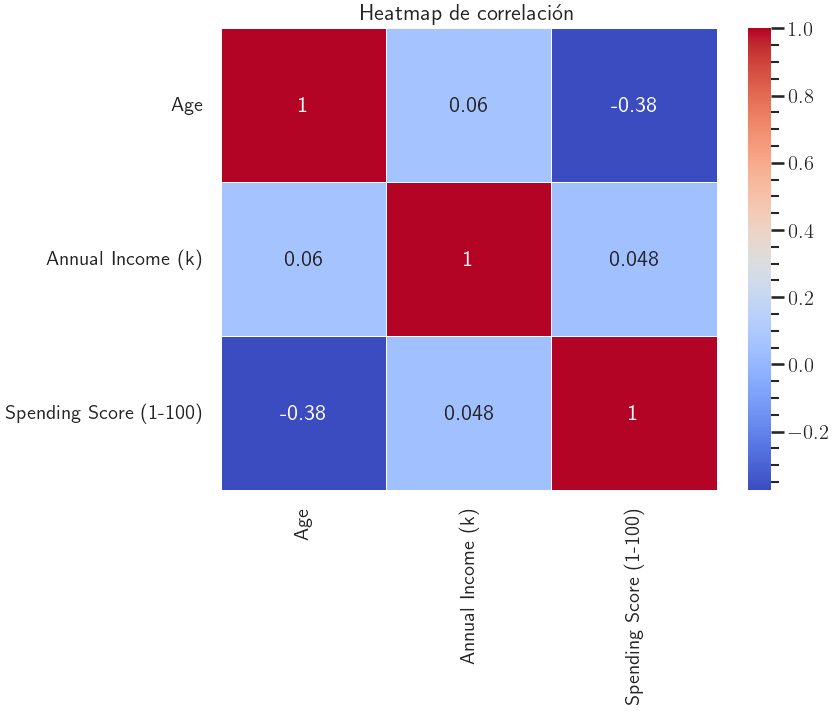

In [156]:
df_cleaned_standardized_femenine.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

# Calcular la matriz de correlación para las columnas de interés
print(df_cleaned_standardized_femenine.columns)
cols = ['Age','Annual Income (k)', 'Spending Score (1-100)']
corr_matrix = df_cleaned_standardized_femenine[cols].corr()

# Configurar y mostrar el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de correlación')
plt.show()

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import os

# Configuraciones para limitar el número de hilos
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Seleccionamos únicamente las columnas de interés
df_cluster = df_cleaned_standardized_femenine[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definimos el rango de clusters (k de 2 a 40)
k_values = np.array(list(range(2, 56)))

# Listas para almacenar las métricas que nos interesan
silhouette_values = []
dunn_values = []
calinski_values = []
davies_values = []  # Nueva métrica

# Función para calcular el índice de Dunn
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    intra_dists = [np.max(cdist(X[labels == label], [centroids[i]])) for i, label in enumerate(unique_labels)]
    inter_dists = cdist(centroids, centroids)
    np.fill_diagonal(inter_dists, np.inf)
    return np.min(inter_dists) / np.max(intra_dists)

# Cálculo de las métricas para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    
    silhouette_values.append(silhouette_score(df_cluster, labels))
    calinski_values.append(calinski_harabasz_score(df_cluster, labels))
    davies_values.append(davies_bouldin_score(df_cluster, labels))  # Nueva métrica
    try:
        dunn_values.append(dunn_index(df_cluster.to_numpy(), labels))
    except Exception:
        dunn_values.append(np.nan)

# Función para marcar los valores máximos y mínimos
def marcar_top(ax, x_vals, y_vals, n_points=3, minimo=False):
    mask = (x_vals >= 4) & (x_vals <= 15)
    x_area = x_vals[mask]
    y_area = np.array(y_vals)[mask]
    
    if len(y_area) >= n_points:
        top_indices = np.argsort(y_area)[:n_points] if minimo else np.argsort(y_area)[-n_points:]
    else:
        top_indices = np.argsort(y_area)
    
    handles = []
    labels_leg = []
    for idx in top_indices:
        x_pt = x_area[idx]
        y_pt = y_area[idx]
        sc = ax.scatter(x_pt, y_pt, s=120, marker='D', facecolors='white', edgecolors='black', zorder=5)
        handles.append(sc)
        labels_leg.append(f"n={x_pt} | {y_pt:.3f}")
    ax.legend(handles, labels_leg, title=f"Top {n_points}", loc="best")

# Graficamos las métricas en una cuadrícula 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Coeficiente de Silueta
axs[0, 0].plot(k_values, silhouette_values, marker='o', color='orange')
axs[0, 0].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[0, 0], k_values, silhouette_values, n_points=3)
axs[0, 0].set_title("Coeficiente de Silueta")
axs[0, 0].set_xlabel("Número de clusters")
axs[0, 0].set_ylabel("Silhouette Score")

# 2. Índice de Dunn
axs[0, 1].plot(k_values, dunn_values, marker='o', color='green')
axs[0, 1].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[0, 1], k_values, dunn_values, n_points=3)
axs[0, 1].set_title("Índice de Dunn")
axs[0, 1].set_xlabel("Número de clusters")
axs[0, 1].set_ylabel("Dunn Index")

# 3. Índice de Calinski-Harabasz
axs[1, 0].plot(k_values, calinski_values, marker='o', color='red')
axs[1, 0].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[1, 0], k_values, calinski_values, n_points=3)
axs[1, 0].set_title("Índice de Calinski-Harabasz")
axs[1, 0].set_xlabel("Número de clusters")
axs[1, 0].set_ylabel("Calinski-Harabasz Score")

# 4. Índice de Davies-Bouldin (mínimos)
axs[1, 1].plot(k_values, davies_values, marker='o', color='blue')
axs[1, 1].axvspan(4, 15, facecolor='red', alpha=0.3)
marcar_top(axs[1, 1], k_values, davies_values, n_points=3, minimo=True)
axs[1, 1].set_title("Índice de Davies-Bouldin")
axs[1, 1].set_xlabel("Número de clusters")
axs[1, 1].set_ylabel("Davies-Bouldin Score")

plt.tight_layout()
plt.show()

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

In [158]:
from rich.table import Table
from rich.console import Console
import numpy as np

console = Console()

# Creamos la tabla con las columnas deseadas
table = Table(title="Clusters óptimos por Métrica (rango [4,15])")
table.add_column("Métrica", style="bold")
table.add_column("Cluster óptimo 1", justify="center")
table.add_column("Cluster óptimo 2", justify="center")
table.add_column("Cluster óptimo 3", justify="center")

n_points = 3  # Número de clusters destacados a mostrar
mask = (k_values >= 4) & (k_values <= 15)
k_area = k_values[mask]

def obtener_clusters_optimos(metric_values, minimo=False):
    metric_area = np.array(metric_values)[mask]
    # Para métricas a maximizar, seleccionamos los índices con valores mayores;
    # para métricas a minimizar (como Davies-Bouldin) seleccionamos los índices con valores menores.
    if minimo:
        top_indices = np.argsort(metric_area)[:n_points]
    else:
        top_indices = np.argsort(metric_area)[-n_points:]
    # Ordenamos los clusters para que se muestren en forma creciente
    return np.sort(k_area[top_indices])

# Obtenemos los clusters óptimos para cada métrica
clusters_silhouette = obtener_clusters_optimos(silhouette_values, minimo=False)
clusters_dunn = obtener_clusters_optimos(dunn_values, minimo=False)
clusters_calinski = obtener_clusters_optimos(calinski_values, minimo=False)
clusters_davies = obtener_clusters_optimos(davies_values, minimo=True)

# Agregamos las filas a la tabla
table.add_row("Coeficiente de Silueta",
              str(clusters_silhouette[0]),
              str(clusters_silhouette[1]),
              str(clusters_silhouette[2]))
table.add_row("Índice de Dunn",
              str(clusters_dunn[0]),
              str(clusters_dunn[1]),
              str(clusters_dunn[2]))
table.add_row("Calinski-Harabasz",
              str(clusters_calinski[0]),
              str(clusters_calinski[1]),
              str(clusters_calinski[2]))
table.add_row("Davies-Bouldin",
              str(clusters_davies[0]),
              str(clusters_davies[1]),
              str(clusters_davies[2]))

console.print(table)

# Calculamos la intersección de los clusters obtenidos en cada métrica
clusters_comunes = set(clusters_silhouette) & set(clusters_dunn) & set(clusters_calinski) & set(clusters_davies)

# Convertimos el conjunto a una lista ordenada (si no está vacío)
clusters_comunes = sorted(list(clusters_comunes))

# Creamos una nueva tabla para mostrar los clusters comunesa
table_comunes = Table(title="Cluster(s) que aparecen en todas las métricas")
table_comunes.add_column("Cluster Común", justify="center", style="bold cyan")

# Si se encontró al menos un cluster común, lo agregamos a la tabla
if clusters_comunes:
    for cluster in clusters_comunes:
        table_comunes.add_row(str(cluster))
else:
    table_comunes.add_row("No hay clusters comunes")

console.print(table_comunes)



                    Clusters óptimos por Métrica (rango [4,15])                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Métrica                ┃ Cluster óptimo 1 ┃ Cluster óptimo 2 ┃ Cluster óptimo 3 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Coeficiente de Silueta │        6         │        7         │        8         │
│ Índice de Dunn         │        6         │        11        │        14        │
│ Calinski-Harabasz      │        6         │        7         │        14        │
│ Davies-Bouldin         │        6         │        7         │        8         │
└────────────────────────┴──────────────────┴──────────────────┴──────────────────┘

 Cluster(s) que  
aparecen en todas
  las métricas   
┏━━━━━━━━━━━━━━━┓
┃ Cluster Común ┃
┡━━━━━━━━━━━━━━━┩
│       6       │
└───────────────┘

In [159]:
from sklearn.cluster import KMeans

# Seleccionar las columnas de interés
features = df_cleaned_standardized_femenine[["Annual Income (k)", "Age", "Spending Score (1-100)"]]

# Definir el modelo K-means con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Entrenar el modelo
kmeans.fit(features)

# Asignar la etiqueta de cluster a cada observación (opcional)
df_cleaned_standardized_femenine['Cluster'] = kmeans.labels_


c:\Users\spinz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\1960011780.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
import plotly.graph_objects as go
import plotly.express as px

# Obtener clusters únicos
clusters = sorted(df_cleaned_standardized_femenine['Cluster'].unique())

# Usar la paleta de colores "Set1" para mayor contraste
contrast_colors = px.colors.qualitative.Set1

# Crear figura
fig = go.Figure()

# Agregar una traza para cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized_femenine[df_cleaned_standardized_femenine['Cluster'] == cluster]
    color = contrast_colors[i % len(contrast_colors)]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data["Annual Income (k)"],
        y=cluster_data["Age"],
        z=cluster_data["Spending Score (1-100)"],
        mode='markers',
        marker=dict(
            size=5,
            color=color,
            opacity=0.8,
            line=dict(color='black', width=1)  # Borde negro similar al 'edgecolor' en matplotlib
        ),
        name=f'Cluster {cluster}'
    ))

# Configurar layout con estilo profesional y científico
fig.update_layout(
    title='Clusters en 3D',
    scene=dict(
        xaxis=dict(title='Ingreso Anual (k)', titlefont=dict(size=12)),
        yaxis=dict(title='Edad', titlefont=dict(size=12)),
        zaxis=dict(title='Puntuación de Gasto (1-100)', titlefont=dict(size=12)),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1))
    ),
    legend=dict(
        title=dict(text='Cluster', font=dict(size=12)),
        font=dict(size=10)
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\1318438103.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



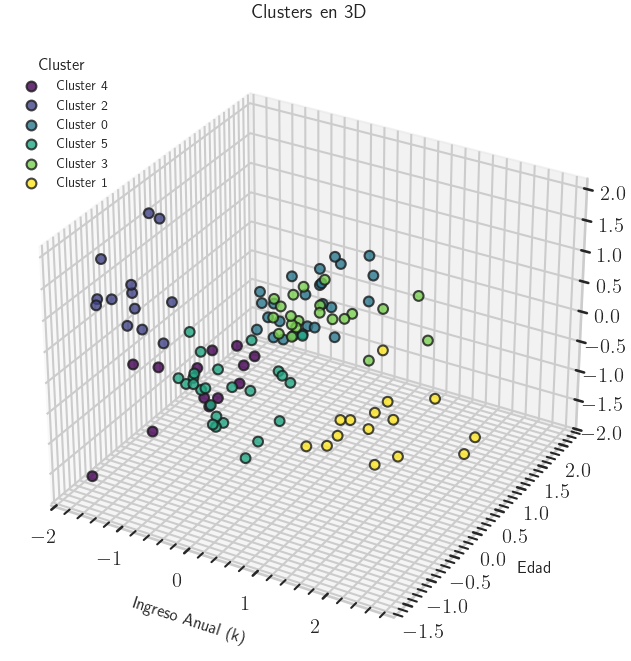

In [161]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Crear figura y eje 3D
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Obtener clusters únicos y definir un mapa de colores profesional
clusters = df_cleaned_standardized_femenine['Cluster'].unique()
colors = plt.cm.get_cmap('viridis', len(clusters))  # Mapa de colores 'viridis' es elegante y profesional

# Graficar cada cluster
for i, cluster in enumerate(clusters):
    cluster_data = df_cleaned_standardized_femenine[df_cleaned_standardized_femenine['Cluster'] == cluster]
    ax.scatter(
        cluster_data["Annual Income (k)"],
        cluster_data["Age"],
        cluster_data["Spending Score (1-100)"],
        s=50,
        alpha=0.8,
        edgecolor='k',
        color=colors(i),
        label=f'Cluster {cluster}'
    )

# Configurar etiquetas y título con estilo científico
ax.set_xlabel('Ingreso Anual (k)', fontsize=12, labelpad=10)
ax.set_ylabel('Edad', fontsize=12, labelpad=10)
ax.set_zlabel('Puntuación de Gasto (1-100)', fontsize=12, labelpad=10)
ax.set_title('Clusters en 3D', fontsize=14, pad=20)

# Configurar leyenda con estilo
ax.legend(title='Cluster', title_fontsize=12, fontsize=10, loc='upper left')

# Mejorar el layout para una presentación más limpia
plt.tight_layout()

plt.show()


In [162]:
# Copiar el DataFrame original para no modificarlo
df_cleaned_cluster_3D_femenine = df_cleaned_femenine.copy()

# Agregar la columna de cluster
df_cleaned_cluster_3D_femenine['Cluster'] = df_cleaned_standardized_femenine['Cluster'].copy()

In [163]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_femenine = df_cleaned_cluster_3D_femenine.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_femenine.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_femenine.groupby('Cluster').agg(lambda x: skew(x, nan_policy='omit', bias=False))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la tabla con rich
console = Console()
table = Table(title="Estadísticas por Cluster Unisex")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla en la consola
console.print(table)


                                          Estadísticas por Cluster Unisex                                          
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃   (k$) ┃   (k$) ┃   (k$) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃  (k$) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  54.08 │   7.97 │  50.00 │  53.24 │   8.76 │  54.00 │ 49.52 │   6.19 │ 50.00 │   0.67 │  0.04 │  -0.27 │
│   1    │  44.60 │   7.66 │  44.00 │  92.33 │  16.44 │  88.00 │ 21.60 │   9.70 │ 22.00 │   0.20 │  0.72 │   0.04 │
│   2    │  25.46 │   5.22 │  23.00 │  25.69 │   8.24 │  23.00 │ 80.54 │  10.70 │ 77.00 │   1.03 │  0.36 │   0.70 │
│   3    │  32.19 │   3.08 │  32.00 │  86.05 │  14.16 │  79.00 │ 81.67 │   7.83 │ 83.00 │   0.52 │  1.10 │  -0.00 │
│   4    │  41.54 │  10.26 │  42.00 │  26.54 │   7.76 │  28.00 │ 20.69 │  11.93 │ 17.00 │  -0.41 │  0.14 │   0.13 │
│   5    │  27.96 │   6.67 │  27.00 │  57.36 │  10.98 │  60.00 │ 47.12 │   8.19 │ 47.00 │   0.34 │ -0.39 │  -0.15 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

In [164]:
#Cambiamos el nombre de una columna que contiene un símbolo especial 
df_cleaned_cluster_3D_femenine.rename(columns={'Annual Income (k$)': 'Annual Income (k)'}, inplace=True)

Estadísticos Originales (Cluster 2 - Age):
Min: 20, Max: 35
Media: 25.462, Mediana: 23.000, Desviación estándar: 5.222
Skewness: 1.030

Estadísticos Winsorizados (Cluster 2 - Age):
Min: 20, Max: 30
Media: 24.692, Mediana: 23.000, Desviación estándar: 3.860
Skewness: 0.616


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




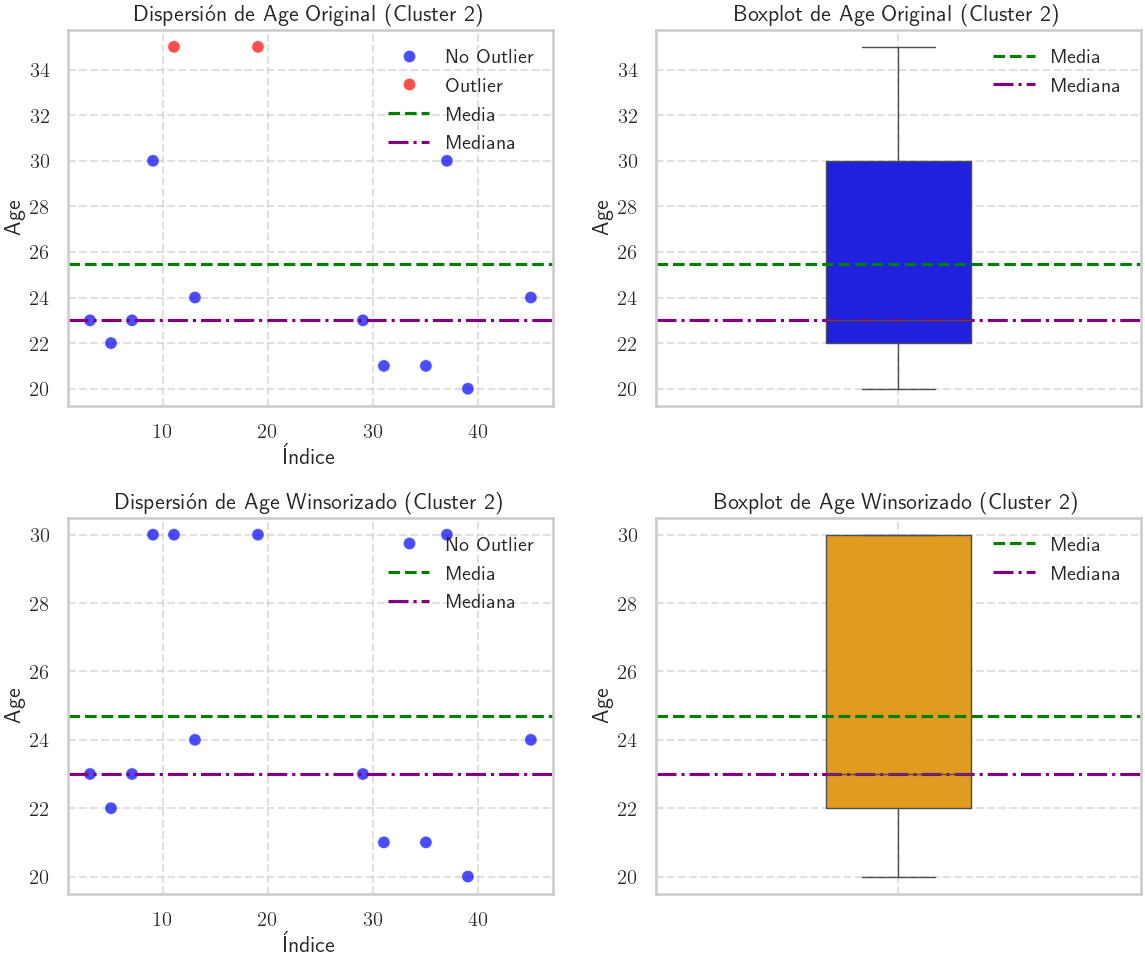

Estadísticos Originales (Cluster 3 - Annual Income (k)):
Min: 70, Max: 120
Media: 86.048, Mediana: 79.000, Desviación estándar: 14.158
Skewness: 1.096

Estadísticos Winsorizados (Cluster 3 - Annual Income (k)):
Min: 70, Max: 103
Media: 84.762, Mediana: 79.000, Desviación estándar: 11.554
Skewness: 0.633


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:103: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\spinz\AppData\Local\Temp\ipykernel_23476\4069032588.py:133: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




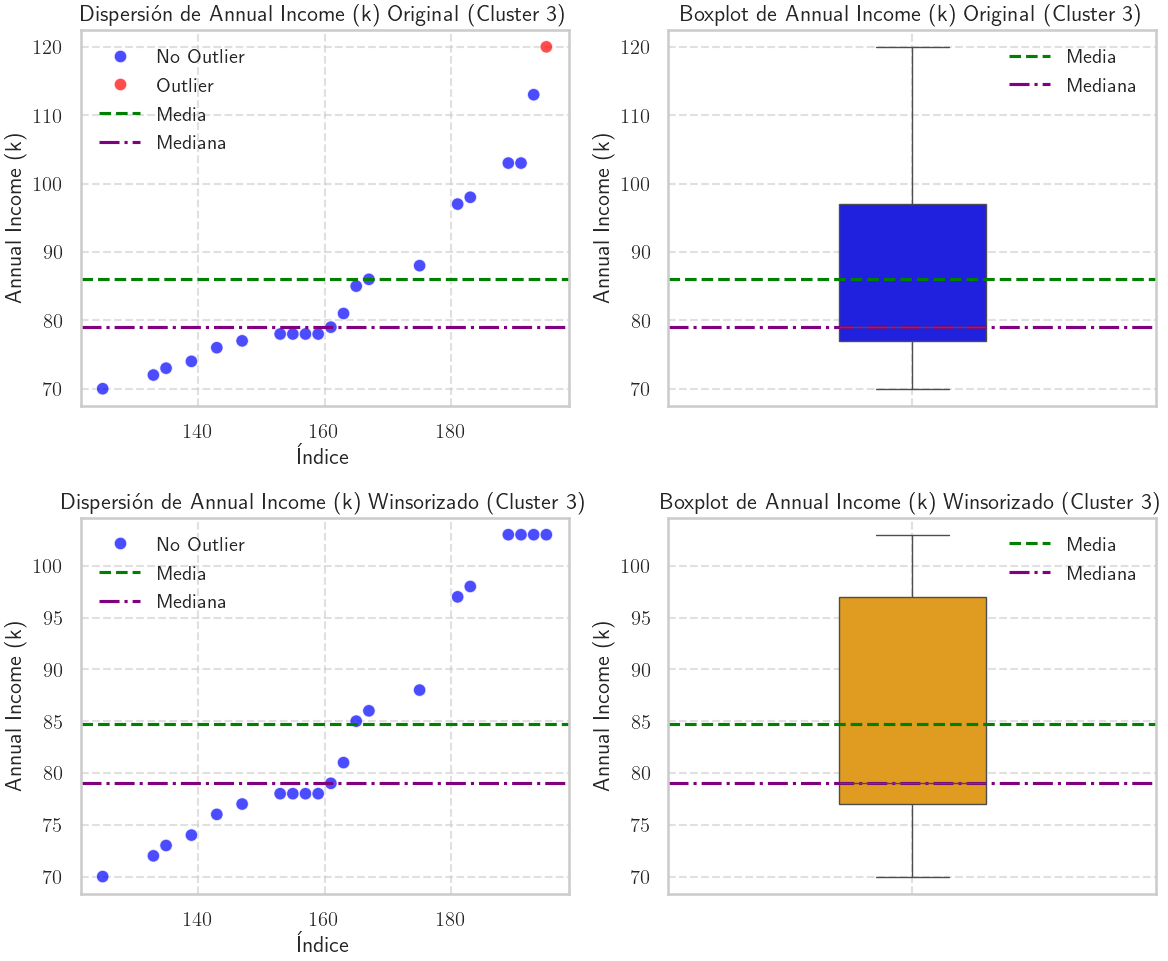

In [165]:
#Cluster 2 columna Spending Age
procesar_cluster(df_cleaned_cluster_3D_femenine, cluster_valor=2, columna="Age", win_limits=[0, 0.2], iqr_factor=0.5, titulo_extra="(Cluster 2)")
#Cluster 3 columna Spending Annual Income (k)
procesar_cluster(df_cleaned_cluster_3D_femenine, cluster_valor=3, columna="Annual Income (k)", win_limits=[0, 0.1], iqr_factor=1, titulo_extra="(Cluster 3)")

In [166]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from rich.console import Console
from rich.table import Table

# Excluir 'Gender' y 'CustomerID' sin eliminarlos del DataFrame original
estadisticas_femenine = df_cleaned_cluster_3D_femenine.drop(columns=['Gender', 'CustomerID'])

# Calcular estadísticas por cluster
estadisticas = estadisticas_femenine.groupby('Cluster').agg(['mean', 'std', 'median'])

# Calcular skewness por cluster
skewness_df = estadisticas_femenine.groupby('Cluster').agg(lambda x: skew(x, nan_policy='omit'))
skewness_df.columns = [(col, 'skew') for col in skewness_df.columns]

# Unir los resultados
estadisticas = pd.concat([estadisticas, skewness_df], axis=1)

# Crear la consola de Rich
console = Console()

# ───────────────────────────────────────────────────
# TABLA PRINCIPAL DE ESTADÍSTICAS
# ───────────────────────────────────────────────────
table_stats = Table(title="Estadísticas por Cluster femenine")

# Agregar columnas a la tabla (incluyendo multiíndices de estadísticas)
table_stats.add_column("Cluster", justify="center", style="bold cyan")

for col in estadisticas.columns:
    stat_name = f"{col[0]} ({col[1]})"
    table_stats.add_column(stat_name, justify="right", style="magenta")

# Agregar filas con los datos
for cluster, row in estadisticas.iterrows():
    table_stats.add_row(str(cluster), *[f"{val:.2f}" for val in row])

# Mostrar la tabla de estadísticas
console.print(table_stats)

# ───────────────────────────────────────────────────
# TABLA DE RANGOS (Media ± Desviación Estándar)
# ───────────────────────────────────────────────────
table_ranges = Table(title="Rangos de Edad, Ingreso y Gasto")

# Columnas principales
table_ranges.add_column("Cluster", justify="center", style="bold cyan")
table_ranges.add_column("Age Range", justify="right", style="yellow")
table_ranges.add_column("Annual Income Range", justify="right", style="green")
table_ranges.add_column("Spending Score Range", justify="right", style="blue")

# Agregar filas con los rangos calculados
for cluster, row in estadisticas.iterrows():
    age_mean = row[('Age', 'mean')]
    age_std = row[('Age', 'std')]
    
    income_mean = row[('Annual Income (k)', 'mean')]
    income_std = row[('Annual Income (k)', 'std')]
    
    spending_mean = row[('Spending Score (1-100)', 'mean')]
    spending_std = row[('Spending Score (1-100)', 'std')]
    
    # Calcular rangos
    age_range = f"{age_mean - age_std:.1f} - {age_mean + age_std:.1f}"
    income_range = f"{income_mean - income_std:.1f} - {income_mean + income_std:.1f}"
    spending_range = f"{spending_mean - spending_std:.1f} - {spending_mean + spending_std:.1f}"
    
    # Agregar fila
    table_ranges.add_row(str(cluster), age_range, income_range, spending_range)

# Mostrar la tabla de rangos
console.print(table_ranges)


                                         Estadísticas por Cluster femenine                                         
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃        ┃        ┃        ┃        ┃ Annual ┃ Annual ┃ Annual ┃ Spen… ┃ Spend… ┃ Spen… ┃        ┃ Annu… ┃ Spend… ┃
┃        ┃        ┃        ┃        ┃ Income ┃ Income ┃ Income ┃ Score ┃  Score ┃ Score ┃        ┃ Inco… ┃  Score ┃
┃        ┃    Age ┃    Age ┃    Age ┃    (k) ┃    (k) ┃    (k) ┃ (1-1… ┃ (1-10… ┃ (1-1… ┃    Age ┃   (k) ┃ (1-10… ┃
┃ Clust… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mean) ┃  (std) ┃ (medi… ┃ (mea… ┃  (std) ┃ (med… ┃ (skew) ┃ (ske… ┃ (skew) ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│   0    │  54.08 │   7.97 │  50.00 │  53.24 │   8.76 │  54.00 │ 49.52 │   6.19 │ 50.00 │   0.63 │  0.04 │  -0.25 │
│   1    │  44.60 │   7.66 │  44.00 │  92.33 │  16.44 │  88.00 │ 21.60 │   9.70 │ 22.00 │   0.18 │  0.65 │   0.04 │
│   2    │  24.69 │   3.86 │  23.00 │  25.69 │   8.24 │  23.00 │ 80.54 │  10.70 │ 77.00 │   0.54 │  0.32 │   0.62 │
│   3    │  32.19 │   3.08 │  32.00 │  84.76 │  11.55 │  79.00 │ 81.67 │   7.83 │ 83.00 │   0.48 │  0.59 │  -0.00 │
│   4    │  41.54 │  10.26 │  42.00 │  26.54 │   7.76 │  28.00 │ 20.69 │  11.93 │ 17.00 │  -0.36 │  0.12 │   0.11 │
│   5    │  27.96 │   6.67 │  27.00 │  57.36 │  10.98 │  60.00 │ 47.12 │   8.19 │ 47.00 │   0.32 │ -0.37 │  -0.14 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

                   Rangos de Edad, Ingreso y Gasto                    
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃   Age Range ┃ Annual Income Range ┃ Spending Score Range ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│    0    │ 46.1 - 62.1 │         44.5 - 62.0 │          43.3 - 55.7 │
│    1    │ 36.9 - 52.3 │        75.9 - 108.8 │          11.9 - 31.3 │
│    2    │ 20.8 - 28.6 │         17.5 - 33.9 │          69.8 - 91.2 │
│    3    │ 29.1 - 35.3 │         73.2 - 96.3 │          73.8 - 89.5 │
│    4    │ 31.3 - 51.8 │         18.8 - 34.3 │           8.8 - 32.6 │
│    5    │ 21.3 - 34.6 │         46.4 - 68.3 │          38.9 - 55.3 │
└─────────┴─────────────┴─────────────────────┴──────────────────────┘

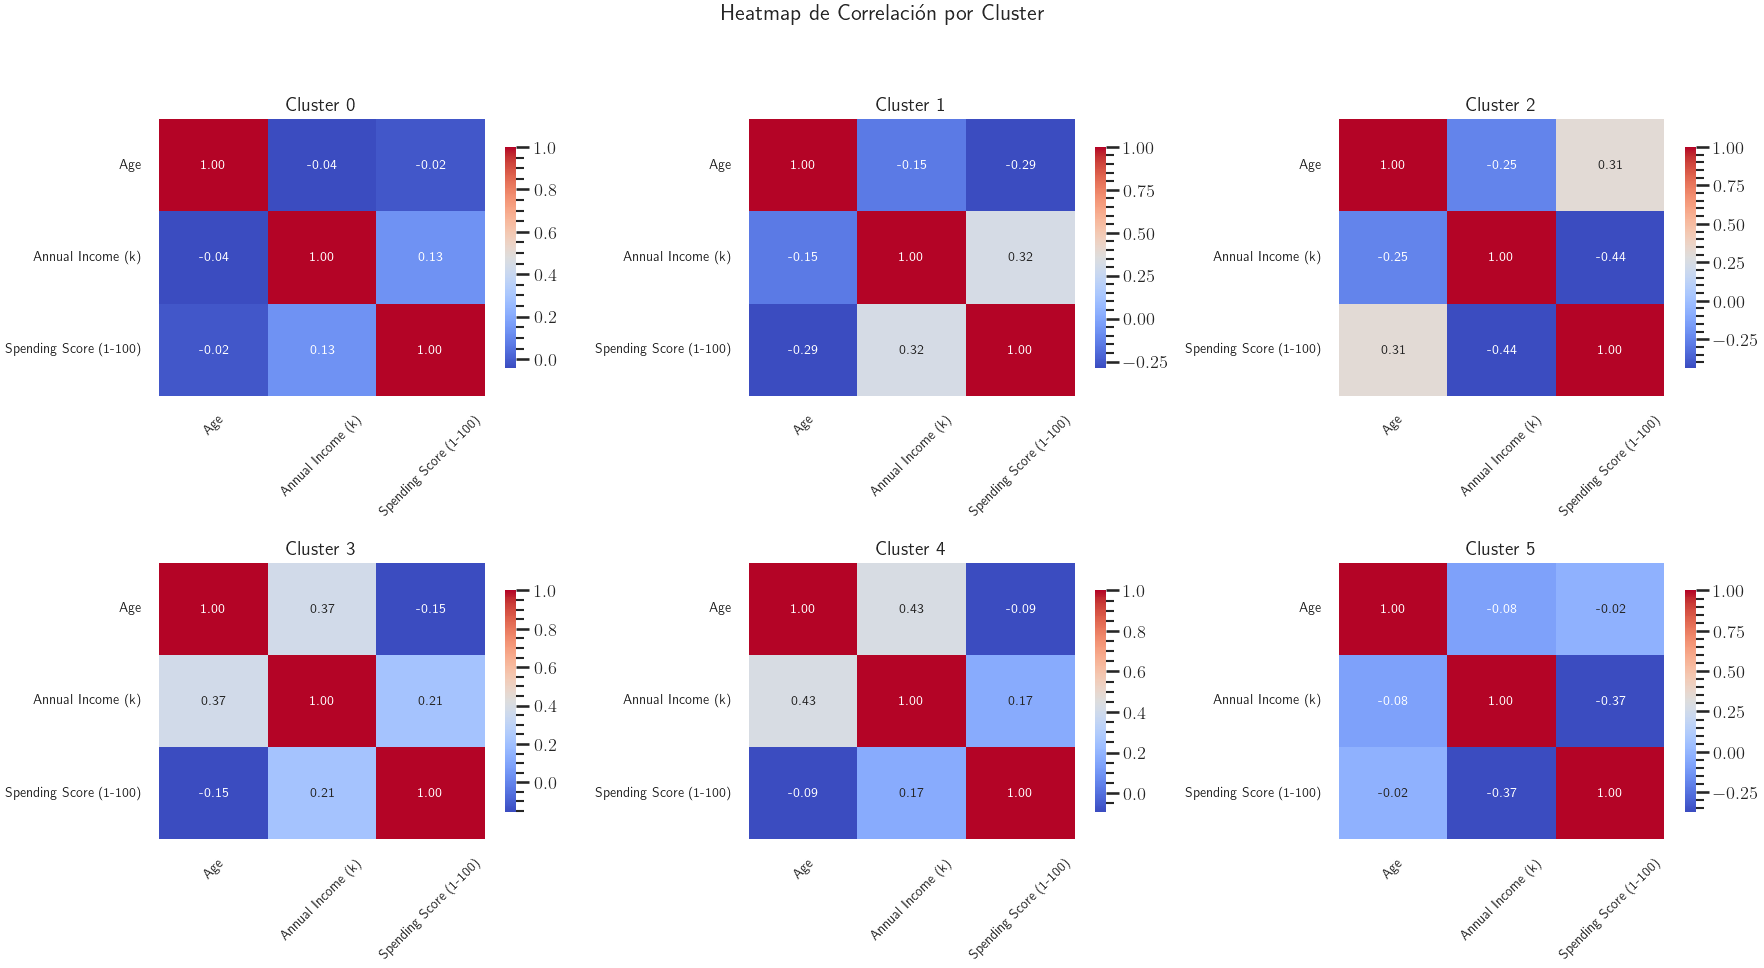

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar el estilo y contexto de Seaborn para una mejor apariencia
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=0.8)

# Excluir 'CustomerID' y 'Gender'
df_filtered = df_cleaned_cluster_3D_femenine.drop(columns=['CustomerID', 'Gender'])

# Obtener los clusters únicos (ordenados, si lo deseas)
clusters = sorted(df_filtered['Cluster'].unique())

# Crear una figura con 2 filas y 3 columnas de subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Iterar por cada cluster y ubicarlos en el subplot correspondiente
for idx, cluster in enumerate(clusters):
    row = idx // 3  # Determina la fila (0 o 1)
    col = idx % 3   # Determina la columna (0, 1 o 2)
    ax = axes[row, col]
    
    # Filtrar los datos para el cluster actual, excluyendo la columna 'Cluster'
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster].drop(columns=['Cluster'])
    
    # Crear el heatmap de correlación para el cluster con ajustes estéticos
    sns.heatmap(
        cluster_data.corr(),
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        ax=ax,
        annot_kws={"size": 10},   # Tamaño de las anotaciones
        cbar_kws={"shrink": 0.8}    # Reducir el tamaño de la barra de color
    )
    ax.set_title(f"Cluster {cluster}", fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # Ajustar rotación y tamaño de etiquetas en el eje x
    ax.tick_params(axis='y', rotation=0, labelsize=10)   # Ajustar etiquetas en el eje y

# Título general para la figura
fig.suptitle("Heatmap de Correlación por Cluster", fontsize=16)

# Ajustar el layout para evitar solapamientos (dejando espacio para el título general)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [168]:
correlation_dict = {}

# Iterar por cada cluster
for cluster in clusters:
    # Filtrar los datos para el cluster actual
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster].drop(columns=['Cluster'])
    
    # Calcular la matriz de correlación y almacenarla en el diccionario
    correlation_dict[cluster] = cluster_data.corr()

# Ahora `correlation_dict` contiene las correlaciones de cada cluster


In [169]:
# Función para determinar el color según las correlaciones importantes
def get_color_for_variable(cluster, variable, corr_dict):
    # Obtener la matriz de correlación para el cluster
    corr_matrix = corr_dict[cluster]
    
    # Lista para almacenar las correlaciones significativas
    significativas = []
    
    # Recorrer cada variable (omitiendo la diagonal)
    for other in corr_matrix.columns:
        if other == variable:
            continue
        valor = corr_matrix.loc[variable, other]
        # Si la correlación es menor a -0.4 o mayor a 0.4 se considera significativa
        if valor < -0.4 or valor > 0.4:
            significativas.append(valor)
    
    # Si hay al menos dos correlaciones significativas, se asigna color anaranjado claro
    if len(significativas) >= 2:
        return "orange1"
    
    # Si hay exactamente una correlación significativa, se asigna
    # rojo brillante si es negativa o verde brillante si es positiva
    elif len(significativas) == 1:
        if significativas[0] < 0:
            return "bright_red"
        else:
            return "bright_green"
    
    # Si no hay correlaciones significativas, se asigna blanco
    return "white"


# Suponiendo que 'estadisticas' es el DataFrame con la media y std calculados por cluster,
# y que 'corr_dict' contiene la matriz de correlación para cada cluster.
# Además, supongamos que los nombres de las columnas en la matriz de correlación son:
# "Age", "Annual Income (k)" y "Spending Score (1-100)"

from rich.table import Table
from rich.console import Console

console = Console()
table_ranges = Table(title="Rangos de Edad, Ingreso y Gasto")

# Columnas principales y columnas adicionales para mostrar el color
table_ranges.add_column("Cluster", justify="center", style="bold cyan")
table_ranges.add_column("Age Range", justify="right")
table_ranges.add_column("Annual Income Range", justify="right")
table_ranges.add_column("Spending Score Range", justify="right")
table_ranges.add_column("Age Color", justify="center")
table_ranges.add_column("Annual Income Color", justify="center")
table_ranges.add_column("Spending Score Color", justify="center")

# Agregar filas con los rangos calculados y aplicando el color según correlación
for cluster, row in estadisticas.iterrows():
    # Calcular media y desviación estándar
    age_mean = row[('Age', 'mean')]
    age_std = row[('Age', 'std')]
    
    income_mean = row[('Annual Income (k)', 'mean')]
    income_std = row[('Annual Income (k)', 'std')]
    
    spending_mean = row[('Spending Score (1-100)', 'mean')]
    spending_std = row[('Spending Score (1-100)', 'std')]
    
    # Calcular rangos
    age_range = f"{age_mean - age_std:.1f} - {age_mean + age_std:.1f}"
    income_range = f"{income_mean - income_std:.1f} - {income_mean + income_std:.1f}"
    spending_range = f"{spending_mean - spending_std:.1f} - {spending_mean + spending_std:.1f}"
    
    # Obtener colores para cada variable basados en la correlación en el cluster
    age_color = get_color_for_variable(cluster, "Age", correlation_dict)
    income_color = get_color_for_variable(cluster, "Annual Income (k)", correlation_dict)
    spending_color = get_color_for_variable(cluster, "Spending Score (1-100)", correlation_dict)
    
    # Aplicar formato de color a los textos (Rich interpreta [color] ... [/color])
    colored_age_range = f"[{age_color}]{age_range}[/{age_color}]"
    colored_income_range = f"[{income_color}]{income_range}[/{income_color}]"
    colored_spending_range = f"[{spending_color}]{spending_range}[/{spending_color}]"
    
    # Agregar fila a la tabla con las columnas de rangos y las de color (se muestran como texto plano)
    table_ranges.add_row(
        str(cluster),
        colored_age_range,
        colored_income_range,
        colored_spending_range,
        age_color,
        income_color,
        spending_color
    )

# Mostrar la tabla de rangos
console.print(table_ranges)


                                          Rangos de Edad, Ingreso y Gasto                                          
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃         ┃             ┃    Annual Income ┃   Spending Score ┃              ┃  Annual Income  ┃  Spending Score  ┃
┃ Cluster ┃   Age Range ┃            Range ┃            Range ┃  Age Color   ┃      Color      ┃      Color       ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│    0    │ 46.1 - 62.1 │      44.5 - 62.0 │      43.3 - 55.7 │    white     │      white      │      white       │
│    1    │ 36.9 - 52.3 │     75.9 - 108.8 │      11.9 - 31.3 │    white     │      white      │      white       │
│    2    │ 20.8 - 28.6 │      17.5 - 33.9 │      69.8 - 91.2 │    white     │   bright_red    │    bright_red    │
│    3    │ 29.1 - 35.3 │      73.2 - 96.3 │      73.8 - 89.5 │    white     │      white      │      white       │
│    4    │ 31.3 - 51.8 │      18.8 - 34.3 │       8.8 - 32.6 │ bright_green │  bright_green   │      white       │
│    5    │ 21.3 - 34.6 │      46.4 - 68.3 │      38.9 - 55.3 │    white     │      white      │      white       │
└─────────┴─────────────┴──────────────────┴──────────────────┴──────────────┴─────────────────┴──────────────────┘